# Xray Stacked Radial Profiles 2D

In [ ]:
import yt
import pyxsim

import h5py
import numpy as np
import illustris_python as il
import glob

from tqdm import tqdm
import os
from regions import RectangleSkyRegion
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy import wcs
from astropy.io import fits
import pylab as plt
#from concurrent.futures import ThreadPoolExecutor, as_completed
from concurrent.futures import ProcessPoolExecutor, as_completed

soxs : [WARNING  ] 2025-05-19 09:42:34,518 Setting 'soxs_data_dir' to /home/tnguser/.cache/soxs for this session. Please update your configuration if you want it somewhere else.


In [ ]:
#PART 2: Simulation Specification
basePath = "../../../sims.TNG/TNG50-1/output/"
snap = 50                                                       #z=1
nbins = 8
r_norm_max = 2
r_norm_min = 1e-2
max_workers = 5
tag = ["Efficient_AGN", "Efficient_Non", "Inefficient_AGN", "Inefficient_Non"]
hm = "1"

In [ ]:
def process_single_halo(args):
    haloID, label = args
    try:
        print(f"Processing {label} halo {haloID}...")
        halo = il.groupcat.loadSingle(basePath, snap, haloID=haloID)

        header = il.groupcat.loadHeader(basePath, snap)
        gas = il.snapshot.loadHalo(basePath, snap, haloID, "gas")
        with h5py.File(il.snapshot.snapPath(basePath, snap), 'r') as f:
            header_snap = dict(f['Header'].attrs)

        filename = f"halo_{label}_{haloID}.hdf5"
        with h5py.File(filename, 'w') as f:
            for key in gas.keys():
                f['PartType0/' + key] = gas[key]
            f.create_group('Header')
            f['Header'].attrs['NumFilesPerSnapshot'] = 1
            f['Header'].attrs['MassTable'] = header_snap['MassTable']
            f['Header'].attrs['BoxSize'] = header['BoxSize']
            f['Header'].attrs['Time'] = header['Time']
            f['Header'].attrs['Redshift'] = header['Redshift']
            f['Header'].attrs['NumPart_ThisFile'] = np.array([gas['count'],0,0,0,0,0])
            f['Header'].attrs['HubbleParam'] = header['HubbleParam']
            f['Header'].attrs['Omega0'] = header['Omega0']
            f['Header'].attrs['OmegaLambda'] = header['OmegaLambda']
            f['Header'].attrs['UnitLength_in_cm'] = header_snap['UnitLength_in_cm']
            f['Header'].attrs['UnitMass_in_g'] = header_snap['UnitMass_in_g']
            f['Header'].attrs['UnitVelocity_in_cm_per_s'] = header_snap['UnitVelocity_in_cm_per_s']

        ds = yt.load(filename)
        c = ds.arr(halo["GroupPos"], "code_length").to("kpc")
        r200 = ds.arr(halo["Group_R_Crit200"], "code_length").to("kpc")
        
        del halo, gas, header
        
        def hot_gas(pfilter, data):
            pfilter1 = data[pfilter.filtered_type, "temperature"] > 3.0e5
            pfilter2 = data["PartType0", "StarFormationRate"] == 0.0
            pfilter3 = data["PartType0", "GFM_CoolingRate"] < 0.0
            return (pfilter1 & pfilter2) & pfilter3

        yt.add_particle_filter("hot_gas", function=hot_gas,
                               filtered_type='gas', requires=["temperature","density"])
        ds.add_particle_filter("hot_gas")

        source_model = pyxsim.CIESourceModel(
            "apec", 0.5, 2.0, 10000,
            ("hot_gas", "metallicity"),
            temperature_field=("hot_gas", "temperature"),
            emission_measure_field=("hot_gas", "emission_measure"),
        )

        xray_fields = source_model.make_source_fields(ds, 0.5, 2)
        
        proj2 = ds.proj(xray_fields[0], axis='z', center=c)
        frb2 = proj2.to_frb(2* r_norm_max * r200, (500, 500), center=c)
        xray_data = frb2[xray_fields[0]]

        ny, nx = xray_data.shape
        center_x, center_y = nx // 2, ny // 2
        y, x = np.indices((ny, nx))
        rp = (np.sqrt((x - center_x)**2 + (y - center_y)**2))/r200
        radii = rp * (2* r_norm_max * r200/500.0)
        r_bins = np.logspace(np.log10(1e-2), np.log10(r_norm_max), nbins + 1)


        def bin_profile(quantity):
            binned = np.array([
                np.mean(quantity[(radii >= r_bins[i]) & (radii < r_bins[i+1])])
                if np.any((radii >= r_bins[i]) & (radii < r_bins[i+1])) else np.nan
                for i in range(nbins)
            ])
            return np.nan_to_num(binned, nan=0.0)

        profile = bin_profile(xray_data)

        for f in [filename, filename + ".ewah"]:
            if os.path.exists(f):
                os.remove(f)

        return (haloID, profile)

    except Exception as e:
        print(f"❌ Failed for halo {haloID}: {e}")
        return (haloID, np.zeros(nbins))


def combined_xray_profiles(halo_list, label):
    xray_profiles = np.zeros((len(halo_list), nbins))

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
    #with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_single_halo, (haloID, label)): i for i, haloID in enumerate(halo_list)}
        for future in tqdm(as_completed(futures), total=len(futures), desc=f"{label} Halos"):
            i = futures[future]
            haloID, profile = future.result()
            xray_profiles[i, :] = profile

    xray_mean = np.nanmean(xray_profiles, axis=0)
    xray_sem = np.nanstd(xray_profiles, axis=0, ddof=1) / np.sqrt(len(halo_list))

    np.savez(f"xray_profile2d4bins_{label}_{hm}.npz", xray_mean=xray_mean, xray_sem=xray_sem)
    print(f"✅ Saved xray_profile2d4bins_{label}_{hm}.npz")


In [ ]:

data = np.load(f"accretor_agn50_hm{hm}.npz")

combined_xray_profiles(data["ha_agn"], tag[0])
combined_xray_profiles(data["hn_agn"], tag[2])
combined_xray_profiles(data["hn_non"], tag[3])

'''
data1 = np.load(f"accretor_agn50_hm1.npz")
data2 = np.load(f"accretor_agn50_hm2.npz")
#data3 = np.load(f"accretor_agn50_hm3.npz")
data4 = np.load(f"accretor_agn50_hm4.npz")

combined_xray_profiles(data1["ha_agn"], tag[0], "1")
combined_xray_profiles(data1["hn_agn"], tag[2], "1")
combined_xray_profiles(data1["hn_non"], tag[3], "1")

combined_xray_profiles(data2["ha_agn"], tag[0], "2")
combined_xray_profiles(data2["hn_agn"], tag[2], "2")
combined_xray_profiles(data2["hn_non"], tag[3], "2")

combined_xray_profiles(data3["ha_agn"], tag[0], "3")
combined_xray_profiles(data3["hn_agn"], tag[2], "3")
combined_xray_profiles(data3["hn_non"], tag[3], "3")

combined_xray_profiles(data4["ha_agn"], tag[0], "4")
combined_xray_profiles(data4["hn_agn"], tag[2], "4")
combined_xray_profiles(data4["hn_non"], tag[3], "4")
'''

Processing Efficient_AGN halo 316...Processing Efficient_AGN halo 461...

Processing Efficient_AGN halo 487...

Efficient_AGN Halos:   0%|          | 0/41 [00:00<?, ?it/s]

Processing Efficient_AGN halo 522...Processing Efficient_AGN halo 514...




yt : [INFO     ] 2025-05-18 13:35:13,697 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:35:13,828 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:35:13,829 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:35:13,831 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:35:13,834 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:35:13,836 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:35:13,837 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:35:13,838 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:35:13,840 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:35:13,840 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:35:13,841 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:35:18,649 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:35:18,651 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:35:18,652 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:35:18,655 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:35:18,933 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:35:18,935 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:35:18,936 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:35:18,938 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:35:19,084 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:35:19,085 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:35:19,087 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:35:19,089 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:35:19,569 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:35:19,571 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:35:19,573 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:35:19,574 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:36:04,324 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:36:05,127 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:36:05,348 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:36:05,434 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:36:06,064 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Efficient_AGN Halos:   2%|▏         | 1/41 [00:56<37:25, 56.14s/it]

Processing Efficient_AGN halo 563...
Processing Efficient_AGN halo 639...

Efficient_AGN Halos:   5%|▍         | 2/41 [00:57<15:22, 23.65s/it]

Efficient_AGN Halos:   7%|▋         | 3/41 [00:57<08:19, 13.13s/it]

Processing Efficient_AGN halo 686...
Processing Efficient_AGN halo 722...


yt : [INFO     ] 2025-05-18 13:36:09,332 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:36:09,433 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:36:09,435 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:36:09,437 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:36:09,440 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:36:09,442 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:36:09,444 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:36:09,445 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:36:09,447 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:36:09,449 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:36:09,451 Parameters: hubble_consta

Processing Efficient_AGN halo 755...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]
yt : [INFO     ] 2025-05-18 13:36:13,068 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:36:13,170 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:36:13,171 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:36:13,173 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:36:13,174 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:36:13,175 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:36:13,176 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:36:13,177 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:36:13,179 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:36:13,180 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]
pyxsim : [INFO     ] 2025-05-18 13:36:14,192 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:36:14,193 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:36:14,195 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:36:14,196 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:36:14,265 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:36:14,266 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:36:14,268 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:36:14,269 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:36:14,365 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:36:14,367 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:36:14,368 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:36:14,369 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:36:17,038 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:36:17,039 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:36:17,041 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:36:17,042 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:36:59,019 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:36:59,112 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:37:00,290 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:37:00,451 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Efficient_AGN Halos:  15%|█▍        | 6/41 [01:50<11:04, 19.00s/it]

Processing Efficient_AGN halo 801...


Efficient_AGN Halos:  17%|█▋        | 7/41 [01:50<07:42, 13.59s/it]

Processing Efficient_AGN halo 809...


Efficient_AGN Halos:  20%|█▉        | 8/41 [01:51<05:24,  9.82s/it]

Processing Efficient_AGN halo 821...


Efficient_AGN Halos:  22%|██▏       | 9/41 [01:51<03:43,  6.99s/it]

Processing Efficient_AGN halo 836...


yt : [INFO     ] 2025-05-18 13:37:02,747 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:37:02,819 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:37:02,820 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:37:02,822 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:37:02,824 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:37:02,825 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:37:02,826 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:37:02,827 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:37:02,828 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:37:02,829 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:37:02,830 Parameters: hubble_consta

Processing Efficient_AGN halo 839...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]
yt : [INFO     ] 2025-05-18 13:37:04,859 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:37:04,933 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:37:04,935 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:37:04,936 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:37:04,938 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:37:04,940 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:37:04,942 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:37:04,943 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:37:04,944 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:37:04,945 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:37:06,180 Allocating for 3.329e+05 particles
Initializing refined index:   0%|          | 0/2 [00:00<?, ?it/s]pyxsim : [INFO     ] 2025-05-18 13:37:06,425 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:37:06,427 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:37:06,430 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:37:06,432 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]
pyxsim : [INFO     ] 2025-05-18 13:37:07,553 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:37:07,555 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:37:07,557 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:37:07,559 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:37:08,205 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:37:08,206 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:37:08,207 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:37:08,208 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:37:09,666 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:37:09,668 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:37:09,671 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:37:09,673 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:37:51,031 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:37:51,305 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:37:52,304 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Efficient_AGN Halos:  27%|██▋       | 11/41 [02:41<09:03, 18.11s/it]

Processing Efficient_AGN halo 856...


Efficient_AGN Halos:  29%|██▉       | 12/41 [02:42<06:12, 12.86s/it]

Processing Efficient_AGN halo 857...


Efficient_AGN Halos:  32%|███▏      | 13/41 [02:42<04:18,  9.22s/it]

Processing Efficient_AGN halo 859...


yt : [INFO     ] 2025-05-18 13:37:53,946 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:37:54,425 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:37:54,519 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:37:54,520 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:37:54,523 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:37:54,525 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:37:54,527 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:37:54,529 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:37:54,531 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:37:54,535 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Efficient_AGN halo 860...


yt : [INFO     ] 2025-05-18 13:37:55,429 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:37:55,430 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:37:55,431 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:37:55,432 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:37:55,434 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:37:55,439 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:37:55,440 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:37:55,441 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:37:55,442 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:37:55,444 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 13:37:55,449 The hot_gas particle filter alread

Processing Efficient_AGN halo 896...

yt : [INFO     ] 2025-05-18 13:37:56,574 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:37:56,580 Parameters: domain_dimensions         = [1 1 1]


yt : [INFO     ] 2025-05-18 13:37:56,581 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:37:56,582 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:37:56,583 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:37:56,587 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:37:56,587 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:37:56,588 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:37:56,589 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:37:56,590 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 13:37:56,592 The hot_gas particle filter already exists. Overriding.
yt : [INFO     ] 2025-05-18 13:37:56,654 Allocating for 3.29e+05 particles
Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.21it/s]
pyxsim : [INFO     ] 20

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:37:58,038 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:37:58,039 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:37:58,040 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:37:58,042 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:37:58,769 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:37:58,770 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:37:58,774 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:37:58,775 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:37:58,801 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:37:58,869 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:37:58,870 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:37:58,872 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:37:58,874 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:37:58,876 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:37:58,877 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:37:58,879 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:37:58,880 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:37:58,881 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:37:58,882 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:38:02,101 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:38:02,102 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:38:02,104 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:38:02,105 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:38:43,298 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:38:43,788 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Efficient_AGN Halos:  39%|███▉      | 16/41 [03:33<07:31, 18.07s/it]

Processing Efficient_AGN halo 920...


yt : [INFO     ] 2025-05-18 13:38:44,922 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Efficient_AGN Halos:  41%|████▏     | 17/41 [03:34<05:09, 12.89s/it]

Processing Efficient_AGN halo 965...


yt : [INFO     ] 2025-05-18 13:38:46,049 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:38:46,282 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:38:46,359 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:38:46,360 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:38:46,361 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:38:46,363 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:38:46,364 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:38:46,365 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:38:46,367 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:38:46,368 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Efficient_AGN halo 978...


yt : [INFO     ] 2025-05-18 13:38:47,105 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:38:47,187 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:38:47,188 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:38:47,189 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:38:47,190 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:38:47,192 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:38:47,193 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:38:47,195 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:38:47,196 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:38:47,197 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:38:47,198 Parameters: hubble_consta

Processing Efficient_AGN halo 980...


yt : [INFO     ] 2025-05-18 13:38:47,740 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:38:47,741 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:38:47,743 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:38:47,745 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:38:47,746 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:38:47,747 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:38:47,748 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:38:47,750 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:38:47,752 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:38:47,752 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 13:38:47,758 The hot_gas particle filter alread

Processing Efficient_AGN halo 990...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]
pyxsim : [INFO     ] 2025-05-18 13:38:49,757 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:38:49,759 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:38:49,761 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:38:49,762 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:38:50,415 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:38:50,417 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:38:50,420 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:38:50,422 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:38:50,477 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:38:50,550 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:38:50,552 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:38:50,553 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:38:50,555 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:38:50,556 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:38:50,557 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:38:50,558 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:38:50,560 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:38:50,561 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:38:50,563 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.99it/s]
pyxsim : [INFO     ] 2025-05-18 13:38:52,503 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:38:52,504 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:38:52,505 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:38:52,507 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:38:53,989 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:38:53,990 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:38:53,992 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:38:53,992 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:39:34,464 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:39:35,150 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Efficient_AGN halo 1024...

Efficient_AGN Halos:  51%|█████     | 21/41 [04:24<05:51, 17.56s/it]

Efficient_AGN Halos:  54%|█████▎    | 22/41 [04:25<03:58, 12.55s/it]

Processing Efficient_AGN halo 1025...


yt : [INFO     ] 2025-05-18 13:39:36,990 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:39:37,053 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:39:37,059 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:39:37,060 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:39:37,061 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:39:37,063 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:39:37,065 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:39:37,066 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:39:37,067 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:39:37,068 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Efficient_AGN halo 1044...


Efficient_AGN Halos:  59%|█████▊    | 24/41 [04:27<01:55,  6.77s/it]

Processing Efficient_AGN halo 1050...


yt : [INFO     ] 2025-05-18 13:39:39,403 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:39:39,475 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:39:39,477 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:39:39,479 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:39:39,481 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:39:39,483 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:39:39,485 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:39:39,486 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:39:39,488 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:39:39,489 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:39:39,490 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:39:40,680 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:39:40,681 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:39:40,683 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:39:40,684 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Efficient_AGN Halos:  61%|██████    | 25/41 [04:30<01:27,  5.49s/it]

Processing Efficient_AGN halo 1063...


yt : [INFO     ] 2025-05-18 13:39:42,752 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:39:42,824 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:39:42,825 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:39:42,827 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:39:42,828 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:39:42,830 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:39:42,831 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:39:42,833 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:39:42,834 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:39:42,835 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:39:42,837 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:39:45,842 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:39:45,843 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:39:45,845 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:39:45,847 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:40:24,485 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Efficient_AGN Halos:  63%|██████▎   | 26/41 [05:14<04:15, 17.05s/it]

Processing Efficient_AGN halo 1086...


yt : [INFO     ] 2025-05-18 13:40:26,163 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:40:26,840 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:40:26,910 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:40:26,911 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:40:26,913 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:40:26,914 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:40:26,915 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:40:26,916 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:40:26,918 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:40:26,919 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Efficient_AGN halo 1140...


yt : [INFO     ] 2025-05-18 13:40:28,294 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:40:28,517 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:40:28,737 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:40:28,816 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:40:28,817 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:40:28,818 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:40:28,820 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:40:28,822 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:40:28,823 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:40:28,823 Parameters: omega_lambda

Processing Efficient_AGN halo 1171...

Efficient_AGN Halos:  68%|██████▊   | 28/41 [05:18<02:01,  9.35s/it]

Efficient_AGN Halos:  71%|███████   | 29/41 [05:18<01:20,  6.73s/it]

Processing Efficient_AGN halo 1202...


pyxsim : [INFO     ] 2025-05-18 13:40:29,992 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:40:29,993 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:40:29,995 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:40:29,996 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:40:30,446 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:40:30,453 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:40:30,519 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:40:30,521 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:40:30,522 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:40:30,523 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:40:30,525 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:40:30,526 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:40:30,527 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:40:30,529 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Efficient_AGN halo 1245...


pyxsim : [INFO     ] 2025-05-18 13:40:32,134 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:40:32,135 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:40:32,137 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:40:32,139 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:40:32,755 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:40:32,826 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:40:32,827 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:40:32,829 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:40:32,831 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:40:32,833 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:40:32,834 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:40:32,836 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:40:32,837 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:40:32,839 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:40:32,840 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:40:34,544 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:40:34,545 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:40:34,546 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:40:34,547 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:40:35,826 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:40:35,828 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:40:35,831 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:40:35,832 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:41:14,454 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Efficient_AGN Halos:  76%|███████▌  | 31/41 [06:04<02:48, 16.83s/it]

Processing Efficient_AGN halo 1276...


yt : [INFO     ] 2025-05-18 13:41:17,387 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:41:17,480 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:41:17,565 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:41:17,567 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:41:17,569 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:41:17,570 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:41:17,572 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:41:17,573 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:41:17,574 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:41:17,575 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Efficient_AGN halo 1381...


yt : [INFO     ] 2025-05-18 13:41:19,007 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Efficient_AGN Halos:  80%|████████  | 33/41 [06:08<01:14,  9.28s/it]

Processing Efficient_AGN halo 1387...


yt : [INFO     ] 2025-05-18 13:41:20,069 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:41:20,141 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:41:20,142 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:41:20,143 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:41:20,145 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:41:20,146 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:41:20,147 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:41:20,148 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:41:20,149 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:41:20,150 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:41:20,152 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:41:20,371 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:41:21,012 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:41:21,086 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:41:21,087 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:41:21,089 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:41:21,090 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:41:21,092 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:41:21,101 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:41:21,103 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:41:21,103 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Efficient_AGN halo 1397...


yt : [INFO     ] 2025-05-18 13:41:21,178 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Efficient_AGN Halos:  85%|████████▌ | 35/41 [06:11<00:30,  5.09s/it]

Processing Efficient_AGN halo 1435...


yt : [INFO     ] 2025-05-18 13:41:22,369 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:41:22,441 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:41:22,443 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:41:22,445 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:41:22,447 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:41:22,449 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:41:22,450 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:41:22,451 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:41:22,452 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:41:22,453 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:41:22,454 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:41:23,379 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:41:23,456 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:41:23,458 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:41:23,460 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:41:23,461 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:41:23,462 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:41:23,464 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:41:23,467 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:41:23,468 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:41:23,470 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:41:23,472 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:41:25,214 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:41:25,216 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:41:25,218 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:41:25,220 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:41:26,163 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:41:26,169 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:41:26,171 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:41:26,173 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:42:04,883 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Efficient_AGN halo 1519...

Efficient_AGN Halos:  88%|████████▊ | 36/41 [06:54<01:23, 16.67s/it]

yt : [INFO     ] 2025-05-18 13:42:07,020 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:42:07,093 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:42:07,094 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:42:07,096 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:42:07,098 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:42:07,100 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:42:07,101 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:42:07,103 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:42:07,104 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:42:07,105 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:42:07,106 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:42:10,434 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Efficient_AGN Halos: 100%|██████████| 41/41 [07:43<00:00, 11.30s/it]

✅ Saved xray_profile2d4bins_Efficient_AGN_1.npz


Processing Inefficient_AGN halo 252...Processing Inefficient_AGN halo 302...
Processing Inefficient_AGN halo 266...Processing Inefficient_AGN halo 304...Processing Inefficient_AGN halo 287...





Inefficient_AGN Halos:   0%|          | 0/884 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-18 13:42:57,356 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:42:57,477 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:42:57,478 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:42:57,479 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:42:57,480 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:42:57,481 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:42:57,483 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:42:57,485 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:42:57,486 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:42:57,487 Parameters: omega_radiation           = 0.0
yt :

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:43:02,982 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:43:02,983 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:43:02,986 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:43:02,988 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:43:03,174 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:43:03,175 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:43:03,177 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:43:03,178 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:43:03,259 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:43:03,261 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:43:03,262 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:43:03,263 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:43:03,432 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:43:03,433 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:43:03,435 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:43:03,437 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:43:47,608 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:43:47,758 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:43:47,807 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:43:47,960 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:43:48,203 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:   0%|          | 1/884 [01:00<14:51:36, 60.58s/it]

Processing Inefficient_AGN halo 313...


Inefficient_AGN Halos:   0%|          | 2/884 [01:02<6:25:43, 26.24s/it] 

Processing Inefficient_AGN halo 321...


yt : [INFO     ] 2025-05-18 13:43:57,658 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Inefficient_AGN Halos:   0%|          | 3/884 [01:03<3:32:10, 14.45s/it]

Processing Inefficient_AGN halo 323...


yt : [INFO     ] 2025-05-18 13:43:57,750 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:43:57,751 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:43:57,752 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:43:57,753 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:43:57,754 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:43:57,755 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:43:57,758 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:43:57,759 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:43:57,760 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:43:57,761 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 13:43:57,777 The hot_gas particle filter alread

Processing Inefficient_AGN halo 326...


yt : [INFO     ] 2025-05-18 13:44:00,428 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:44:00,437 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:44:00,527 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:44:00,528 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:44:00,529 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:44:00,531 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:44:00,533 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:44:00,534 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:44:00,536 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:44:00,537 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:44:00,537 Parameters: c

Processing Inefficient_AGN halo 341...


Initializing refined index:  50%|█████     | 2/4 [00:00<00:00,  4.10it/s]pyxsim : [INFO     ] 2025-05-18 13:44:03,090 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:44:03,091 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:44:03,093 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:44:03,094 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]
yt : [INFO     ] 2025-05-18 13:44:04,705 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:44:04,809 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:44:04,811 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:44:04,812 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:44:04,814 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:44:04,816 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:44:04,817 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:44:04,818 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:44:04,819 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:44:04,820 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index:   0%|          | 0/3 [00:00<?, ?it/s]pyxsim : [INFO     ] 2025-05-18 13:44:05,207 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:44:05,208 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:44:05,210 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:44:05,211 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]
pyxsim : [INFO     ] 2025-05-18 13:44:06,798 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:44:06,799 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:44:06,801 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:44:06,802 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:44:08,946 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:44:08,947 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:44:08,948 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:44:08,949 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:44:49,021 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:44:50,600 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:44:52,347 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:   1%|          | 6/884 [01:58<5:20:03, 21.87s/it]

Processing Inefficient_AGN halo 343...


yt : [INFO     ] 2025-05-18 13:44:53,129 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:   1%|          | 7/884 [02:00<3:43:33, 15.29s/it]

Processing Inefficient_AGN halo 344...


yt : [INFO     ] 2025-05-18 13:44:55,398 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:44:55,484 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:44:55,486 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:44:55,488 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:44:55,490 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:44:55,491 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:44:55,492 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:44:55,492 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:44:55,494 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:44:55,495 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:44:55,497 Parameters: hubble_consta

Processing Inefficient_AGN halo 356...


Inefficient_AGN Halos:   1%|          | 9/884 [02:04<2:00:11,  8.24s/it]]

Processing Inefficient_AGN halo 377...


Initializing refined index: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]
pyxsim : [INFO     ] 2025-05-18 13:44:59,728 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:44:59,729 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:44:59,731 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:44:59,731 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:   1%|          | 10/884 [02:05<1:25:04,  5.84s/it]

Processing Inefficient_AGN halo 379...


yt : [INFO     ] 2025-05-18 13:45:02,333 Calculating time from 5.007e-01 to be 1.855e+17 seconds
pyxsim : [INFO     ] 2025-05-18 13:45:02,362 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:45:02,365 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:45:02,367 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:45:02,368 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:45:02,409 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:45:02,411 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:45:02,412 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:45:02,413 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:45:02,414 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:45:02,415 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:45:02,416 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:45:02,417 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:45:02,418 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:45:02,419 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 13:45:02,434 The hot_gas particle filter alread

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:45:06,627 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:45:06,629 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:45:06,630 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:45:06,631 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:45:06,715 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:45:06,716 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:45:06,717 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:45:06,718 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:45:44,891 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:45:47,702 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:   1%|          | 11/884 [02:54<4:37:48, 19.09s/it]

Processing Inefficient_AGN halo 380...


yt : [INFO     ] 2025-05-18 13:45:52,535 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:45:52,652 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:45:52,658 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:45:52,667 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:45:52,668 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:45:52,669 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:45:52,671 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:45:52,671 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:45:52,672 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:45:52,675 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:45:52,675 Parameters: hubble_consta

Processing Inefficient_AGN halo 382...


Initializing refined index: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]
yt : [INFO     ] 2025-05-18 13:45:55,030 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:45:55,108 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:45:55,110 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:45:55,111 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:45:55,113 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:45:55,115 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:45:55,116 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:45:55,118 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:45:55,119 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:45:55,121 Parameters: omega_radiation         

Processing Inefficient_AGN halo 389...
Processing Inefficient_AGN halo 390...


pyxsim : [INFO     ] 2025-05-18 13:45:57,415 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:45:57,416 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:45:57,417 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:45:57,418 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:   2%|▏         | 15/884 [03:03<1:31:00,  6.28s/it]

Processing Inefficient_AGN halo 396...


yt : [INFO     ] 2025-05-18 13:45:58,804 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:45:58,878 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:45:58,879 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:45:58,880 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:45:58,883 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:45:58,884 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:45:58,885 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:45:58,886 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:45:58,887 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:45:58,888 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:45:58,890 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]
yt : [INFO     ] 2025-05-18 13:46:01,719 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:46:01,788 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:46:01,789 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:46:01,790 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:46:01,791 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:46:01,793 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:46:01,794 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:46:01,795 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:46:01,796 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:46:01,797 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]
pyxsim : [INFO     ] 2025-05-18 13:46:03,435 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:46:03,436 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:46:03,438 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:46:03,440 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:46:05,909 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:46:05,911 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:46:05,912 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:46:05,913 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:46:42,878 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:46:46,080 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 404...


Inefficient_AGN Halos:   2%|▏         | 16/884 [03:51<4:02:13, 16.74s/it]yt : [INFO     ] 2025-05-18 13:46:48,667 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:46:48,743 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:46:48,745 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:46:48,747 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:46:48,748 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:46:48,750 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:46:48,752 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:46:48,755 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:46:48,757 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:46:48,758 Parameters: omega_radiation          

Processing Inefficient_AGN halo 405...


Initializing refined index: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]
yt : [INFO     ] 2025-05-18 13:46:50,849 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:46:52,011 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:46:52,152 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:46:52,153 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:46:52,159 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:46:52,160 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:46:52,161 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:46:52,163 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:46:52,163 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:46:

Processing Inefficient_AGN halo 419...

Inefficient_AGN Halos:   2%|▏         | 18/884 [03:57<2:28:50, 10.31s/it]

Initializing refined index: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]pyxsim : [INFO     ] 2025-05-18 13:46:53,171 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:46:53,173 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:46:53,174 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:46:53,204 Using temperature field '('hot_gas', 'temperature')'.
Initializing refined index: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Processing Inefficient_AGN halo 420...


Inefficient_AGN Halos:   2%|▏         | 19/884 [04:00<1:57:36,  8.16s/it]yt : [INFO     ] 2025-05-18 13:46:54,984 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:46:55,051 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:46:55,053 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:46:55,054 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:46:55,055 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:46:55,057 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:46:55,058 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:46:55,096 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:46:55,101 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:46:55,102 Parameters: omega_radiation          

Processing Inefficient_AGN halo 422...


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:46:56,603 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:46:56,676 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:46:56,677 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:46:56,678 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:46:56,679 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:46:56,680 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:46:56,682 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:46:56,683 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:46:56,684 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:46:56,685 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:46:56,687 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]
pyxsim : [INFO     ] 2025-05-18 13:47:01,342 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:47:01,343 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:47:01,345 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:47:01,346 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:47:02,316 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:47:02,318 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:47:02,319 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:47:02,320 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:47:39,574 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:   2%|▏         | 21/884 [04:48<4:18:17, 17.96s/it]

Processing Inefficient_AGN halo 427...


yt : [INFO     ] 2025-05-18 13:47:45,249 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:47:45,314 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:47:45,316 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:47:45,317 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:47:45,319 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:47:45,320 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:47:45,321 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:47:45,322 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:47:45,324 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:47:45,325 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:47:45,326 Parameters: hubble_consta

Processing Inefficient_AGN halo 439...


pyxsim : [INFO     ] 2025-05-18 13:47:49,685 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:47:49,689 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:47:49,703 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:47:49,704 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:47:50,348 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:   3%|▎         | 23/884 [04:56<2:33:32, 10.70s/it]

Processing Inefficient_AGN halo 442...


yt : [INFO     ] 2025-05-18 13:47:51,144 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:47:51,213 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:47:51,215 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:47:51,216 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:47:51,218 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:47:51,220 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:47:51,222 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:47:51,223 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:47:51,225 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:47:51,226 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:47:51,227 Parameters: hubble_consta

Processing Inefficient_AGN halo 446...


Initializing refined index: 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]
yt : [INFO     ] 2025-05-18 13:47:52,899 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:47:52,978 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:47:52,981 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:47:52,987 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:47:52,988 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:47:52,989 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:47:52,989 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:47:52,990 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:47:52,990 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:47:52,991 Parameters: omega_radiation         

Processing Inefficient_AGN halo 449...


Initializing refined index:   0%|          | 0/2 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-18 13:47:53,112 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:47:53,113 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:47:53,115 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:47:53,116 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:47:53,117 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:47:53,118 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:47:53,119 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:47:53,120 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:47:53,120 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:47:53,121 Parameters: hubble_constant           = 0.6774
yt : [WARN

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]
pyxsim : [INFO     ] 2025-05-18 13:47:56,757 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:47:56,758 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:47:56,759 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:47:56,760 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:47:57,223 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:47:57,224 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:47:57,225 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:47:57,226 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:47:59,429 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:47:59,430 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:47:59,432 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:47:59,433 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:48:35,426 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:   3%|▎         | 26/884 [05:44<4:13:21, 17.72s/it]

Processing Inefficient_AGN halo 454...


yt : [INFO     ] 2025-05-18 13:48:41,016 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:48:41,083 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:48:41,084 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:48:41,085 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:48:41,086 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:48:41,089 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:48:41,090 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:48:41,095 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:48:41,095 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:48:41,096 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:48:41,097 Parameters: hubble_consta

Processing Inefficient_AGN halo 463...


yt : [INFO     ] 2025-05-18 13:48:45,229 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 13:48:45,476 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:48:45,478 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:48:45,480 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:48:45,481 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:48:46,584 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:48:46,863 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:48:46,937 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:48:46,939 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:48:46,940 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:48:46,942 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:48:46,943 Parameters: cosmological_simulation   = True
Inefficient_AGN Halos:   3%|▎         | 28/884 [05:52<2:31:39, 10.63s/it]yt : [INFO     ] 2025-05-18 13:48:46,963 Parameters: current_redshift          = 0.9972942257819404


Processing Inefficient_AGN halo 464...


yt : [INFO     ] 2025-05-18 13:48:46,965 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:48:46,966 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:48:46,975 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:48:46,976 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 13:48:46,989 The hot_gas particle filter already exists. Overriding.
yt : [INFO     ] 2025-05-18 13:48:47,007 Allocating for 6.09e+05 particles
Inefficient_AGN Halos:   3%|▎         | 29/884 [05:53<1:51:32,  7.83s/it]

Processing Inefficient_AGN halo 466...


Inefficient_AGN Halos:   3%|▎         | 30/884 [05:55<1:23:54,  5.90s/it]

Processing Inefficient_AGN halo 467...


yt : [INFO     ] 2025-05-18 13:48:50,041 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:48:50,114 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:48:50,115 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:48:50,116 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:48:50,117 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:48:50,119 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:48:50,120 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:48:50,121 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:48:50,122 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:48:50,123 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:48:50,124 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]
pyxsim : [INFO     ] 2025-05-18 13:48:54,349 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:48:54,351 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:48:54,352 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:48:54,353 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:48:56,078 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:48:56,079 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:48:56,082 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:48:56,084 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:48:56,124 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:48:56,125 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:48:56,127 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:48:56,128 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:49:31,689 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:   4%|▎         | 31/884 [06:40<4:12:02, 17.73s/it]

Processing Inefficient_AGN halo 471...


yt : [INFO     ] 2025-05-18 13:49:36,864 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:49:36,937 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:49:36,939 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:49:36,941 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:49:36,942 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:49:36,943 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:49:36,944 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:49:36,945 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:49:36,946 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:49:36,947 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:49:36,949 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:49:40,920 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:49:42,017 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 476...


Inefficient_AGN Halos:   4%|▎         | 33/884 [06:49<2:33:23, 10.81s/it]

Processing Inefficient_AGN halo 478...


yt : [INFO     ] 2025-05-18 13:49:44,293 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:49:44,363 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:49:44,364 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:49:44,366 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:49:44,368 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:49:44,369 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:49:44,370 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:49:44,371 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:49:44,372 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:49:44,373 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:49:44,374 Parameters: hubble_consta

Processing Inefficient_AGN halo 481...


Inefficient_AGN Halos:   4%|▍         | 35/884 [06:51<1:20:54,  5.72s/it]

Processing Inefficient_AGN halo 485...


yt : [INFO     ] 2025-05-18 13:49:46,406 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:49:46,480 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:49:46,481 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:49:46,483 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:49:46,484 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:49:46,486 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:49:46,487 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:49:46,488 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:49:46,489 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:49:46,490 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:49:46,491 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]
pyxsim : [INFO     ] 2025-05-18 13:49:50,065 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:49:50,066 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:49:50,068 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:49:50,069 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:49:51,258 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:49:51,260 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:49:51,261 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:49:51,262 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:49:51,612 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:49:51,614 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:49:51,615 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:49:51,616 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:50:27,529 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:   4%|▍         | 36/884 [07:36<4:06:32, 17.44s/it]

Processing Inefficient_AGN halo 488...


yt : [INFO     ] 2025-05-18 13:50:33,657 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:50:33,726 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:50:33,727 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:50:33,729 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:50:33,730 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:50:33,732 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:50:33,734 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:50:33,739 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:50:33,739 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:50:33,742 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:50:33,742 Parameters: hubble_consta

Processing Inefficient_AGN halo 495...


yt : [INFO     ] 2025-05-18 13:50:37,631 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:50:37,855 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 13:50:37,974 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:50:37,975 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:50:37,976 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:50:37,978 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:50:38,919 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:50:38,983 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:50:38,984 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:50:38,986 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:50:38,987 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:50:38,991 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:50:38,992 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:50:38,993 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:50:38,993 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:50:38,994 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:50:38,995 Parameters: hubble_consta

Processing Inefficient_AGN halo 496...


Inefficient_AGN Halos:   4%|▍         | 39/884 [07:46<1:49:45,  7.79s/it]

Processing Inefficient_AGN halo 498...


Inefficient_AGN Halos:   5%|▍         | 40/884 [07:46<1:17:34,  5.51s/it]

Processing Inefficient_AGN halo 499...


yt : [INFO     ] 2025-05-18 13:50:41,422 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:50:41,489 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:50:41,491 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:50:41,492 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:50:41,493 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:50:41,499 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:50:41,500 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:50:41,501 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:50:41,502 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:50:41,503 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:50:41,504 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]
pyxsim : [INFO     ] 2025-05-18 13:50:45,478 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:50:45,480 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:50:45,482 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:50:45,483 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:50:46,528 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:50:46,529 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:50:46,531 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:50:46,532 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:50:46,845 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:50:46,847 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:50:46,848 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:50:46,849 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:51:24,500 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 500...


Inefficient_AGN Halos:   5%|▍         | 41/884 [08:32<4:07:56, 17.65s/it]yt : [INFO     ] 2025-05-18 13:51:29,038 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:51:29,307 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:51:29,376 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:51:29,377 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:51:29,378 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:51:29,379 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:51:29,380 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:51:29,381 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:51:29,382 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:51:2

Processing Inefficient_AGN halo 502...


yt : [INFO     ] 2025-05-18 13:51:31,613 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:51:32,822 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:51:32,891 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:51:32,892 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:51:32,893 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:51:32,894 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:51:32,895 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:51:32,896 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:51:32,897 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:51:32,897 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]


Processing Inefficient_AGN halo 503...

Inefficient_AGN Halos:   5%|▍         | 43/884 [08:40<2:28:00, 10.56s/it]

Inefficient_AGN Halos:   5%|▍         | 44/884 [08:41<1:48:44,  7.77s/it]

Processing Inefficient_AGN halo 504...


yt : [INFO     ] 2025-05-18 13:51:36,094 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Inefficient_AGN Halos:   5%|▌         | 45/884 [08:41<1:17:14,  5.52s/it]

Processing Inefficient_AGN halo 505...


yt : [INFO     ] 2025-05-18 13:51:36,160 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:51:36,161 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:51:36,162 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:51:36,163 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:51:36,165 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:51:36,166 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:51:36,167 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:51:36,168 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:51:36,169 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:51:36,171 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 13:51:36,180 The hot_gas particle filter alread

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:51:37,399 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:51:37,473 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:51:37,475 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:51:37,476 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:51:37,477 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:51:37,478 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:51:37,479 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:51:37,479 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:51:37,480 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:51:37,481 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:51:37,482 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:51:41,703 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:51:41,705 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:51:41,706 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:51:41,707 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:51:42,136 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:51:42,137 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:51:42,139 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:51:42,140 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:52:18,887 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 506...


Inefficient_AGN Halos:   5%|▌         | 46/884 [09:27<4:05:52, 17.60s/it]yt : [INFO     ] 2025-05-18 13:52:23,008 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:52:23,635 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:52:23,702 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:52:23,704 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:52:23,705 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:52:23,706 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:52:23,707 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:52:23,708 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:52:23,708 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:52:2

Processing Inefficient_AGN halo 507...


yt : [INFO     ] 2025-05-18 13:52:26,346 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:52:27,081 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:52:27,150 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:52:27,152 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:52:27,155 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:52:27,156 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:52:27,158 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:52:27,159 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:52:27,160 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:52:27,161 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 3/3 [00:00<00:00,  3.55it/s]
yt : [INFO     ] 2025-05-18 13:52:28,514 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 508...


Inefficient_AGN Halos:   6%|▌         | 49/884 [09:36<1:50:24,  7.93s/it]

Processing Inefficient_AGN halo 509...

pyxsim : [INFO     ] 2025-05-18 13:52:30,917 kT_min = 0.025 keV


pyxsim : [INFO     ] 2025-05-18 13:52:30,918 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:52:30,921 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:52:30,921 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:52:30,987 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:52:31,060 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:52:31,061 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:52:31,062 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:52:31,063 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:52:31,064 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:52:31,066 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:52:31,067 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:52:31,068 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:52:31,069 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:52:31,071 Parameters: hubble_consta

Processing Inefficient_AGN halo 510...


Initializing refined index: 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]
yt : [INFO     ] 2025-05-18 13:52:32,760 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:52:32,827 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:52:32,828 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:52:32,829 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:52:32,830 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:52:32,831 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:52:32,832 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:52:32,833 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:52:32,834 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:52:32,835 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:52:36,218 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:52:36,219 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:52:36,221 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:52:36,222 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:52:37,065 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:52:37,066 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:52:37,067 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:52:37,068 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:53:14,032 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:53:16,853 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:   6%|▌         | 51/884 [10:22<4:04:37, 17.62s/it]

Processing Inefficient_AGN halo 511...


yt : [INFO     ] 2025-05-18 13:53:18,940 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:53:19,007 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:53:19,008 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:53:19,009 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:53:19,010 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:53:19,012 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:53:19,013 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:53:19,014 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:53:19,014 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:53:19,015 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:53:19,016 Parameters: hubble_consta

Processing Inefficient_AGN halo 512...


Initializing refined index: 100%|██████████| 3/3 [00:00<00:00,  3.70it/s]
yt : [INFO     ] 2025-05-18 13:53:21,213 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:53:21,612 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:53:21,686 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:53:21,687 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:53:21,688 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:53:21,690 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:53:21,691 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:53:21,693 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:53:21,694 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:53:

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Processing Inefficient_AGN halo 515...


Inefficient_AGN Halos:   6%|▌         | 54/884 [10:30<1:44:08,  7.53s/it]

Processing Inefficient_AGN halo 523...


pyxsim : [INFO     ] 2025-05-18 13:53:26,015 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:53:26,017 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:53:26,019 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:53:26,020 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:53:26,311 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:53:26,380 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:53:26,381 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:53:26,383 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:53:26,384 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:53:26,385 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:53:26,387 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:53:26,391 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:53:26,392 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:53:26,393 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:53:26,394 Parameters: hubble_consta

Processing Inefficient_AGN halo 525...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]
yt : [INFO     ] 2025-05-18 13:53:28,750 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:53:28,817 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:53:28,818 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:53:28,820 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:53:28,821 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:53:28,822 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:53:28,822 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:53:28,823 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:53:28,825 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:53:28,826 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:53:30,557 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:53:30,559 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:53:30,560 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:53:30,562 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:53:32,969 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:53:32,971 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:53:32,973 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:53:32,975 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:54:09,509 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:54:11,485 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:   6%|▋         | 56/884 [11:17<4:05:18, 17.78s/it]

Processing Inefficient_AGN halo 526...
Processing Inefficient_AGN halo 528...


Inefficient_AGN Halos:   6%|▋         | 57/884 [11:19<2:58:51, 12.98s/it]yt : [INFO     ] 2025-05-18 13:54:14,268 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:54:14,333 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:54:14,334 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:54:14,335 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:54:14,337 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:54:14,338 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:54:14,339 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:54:14,340 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:54:14,342 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:54:14,343 Parameters: omega_radiation          

Processing Inefficient_AGN halo 529...


pyxsim : [INFO     ] 2025-05-18 13:54:18,278 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:54:18,280 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:54:18,282 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:54:18,284 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:   7%|▋         | 59/884 [11:23<1:40:33,  7.31s/it]

Processing Inefficient_AGN halo 531...


yt : [INFO     ] 2025-05-18 13:54:19,152 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:54:19,687 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:54:19,760 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:54:19,762 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:54:19,763 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:54:19,765 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:54:19,767 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:54:19,768 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:54:19,770 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:54:19,771 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  5.12it/s]yt : [INFO     ] 2025-05-18 13:54:20,428 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:54:20,500 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:54:20,501 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:54:20,503 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:54:20,506 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:54:20,507 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:54:20,508 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:54:20,509 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:54:20,511 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:54:20,512 Parameters: omega_radiation          

Processing Inefficient_AGN halo 532...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]
yt : [INFO     ] 2025-05-18 13:54:23,048 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:54:23,123 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:54:23,124 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:54:23,125 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:54:23,127 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:54:23,131 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:54:23,131 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:54:23,133 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:54:23,135 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:54:23,136 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]
pyxsim : [INFO     ] 2025-05-18 13:54:24,437 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:54:24,438 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:54:24,441 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:54:24,442 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:54:27,298 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:54:27,299 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:54:27,304 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:54:27,305 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:55:05,921 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:55:07,155 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:   7%|▋         | 61/884 [12:14<4:13:39, 18.49s/it]

Processing Inefficient_AGN halo 533...
Processing Inefficient_AGN halo 534...

Inefficient_AGN Halos:   7%|▋         | 62/884 [12:15<2:59:59, 13.14s/it]

yt : [INFO     ] 2025-05-18 13:55:10,764 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:55:10,831 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:55:10,832 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:55:10,833 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:55:10,834 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:55:10,836 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:55:10,837 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:55:10,838 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:55:10,838 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:55:10,839 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:55:10,840 Parameters: hubble_consta

Processing Inefficient_AGN halo 536...


pyxsim : [INFO     ] 2025-05-18 13:55:14,496 kT_min = 0.025 keV
yt : [INFO     ] 2025-05-18 13:55:14,501 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 13:55:14,501 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:55:14,503 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:55:14,505 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:55:15,157 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:55:15,159 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:55:15,165 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:55:15,168 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:55:15,192 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:55:15,268 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:55:15,269 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:55:15,271 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:55:15,273 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:55:15,275 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:55:15,276 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:55:15,277 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:55:15,278 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:55:15,280 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:55:15,281 Parameters: hubble_consta

Processing Inefficient_AGN halo 537...


Inefficient_AGN Halos:   7%|▋         | 65/884 [12:22<1:20:01,  5.86s/it]

Processing Inefficient_AGN halo 538...


yt : [INFO     ] 2025-05-18 13:55:17,336 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:55:17,400 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:55:17,401 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:55:17,403 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:55:17,404 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:55:17,407 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:55:17,408 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:55:17,409 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:55:17,411 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:55:17,412 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:55:17,414 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]
pyxsim : [INFO     ] 2025-05-18 13:55:21,064 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:55:21,066 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:55:21,069 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:55:21,070 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:55:22,326 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:55:22,328 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:55:22,329 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:55:22,330 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:56:01,736 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:56:02,373 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:   7%|▋         | 66/884 [13:10<4:11:08, 18.42s/it]

Processing Inefficient_AGN halo 539...


Inefficient_AGN Halos:   8%|▊         | 67/884 [13:10<2:56:44, 12.98s/it]

Processing Inefficient_AGN halo 541...


yt : [INFO     ] 2025-05-18 13:56:05,465 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:56:06,065 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:56:06,139 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:56:06,140 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:56:06,143 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:56:06,144 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:56:06,145 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:56:06,151 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:56:06,152 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:56:06,153 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 542...


yt : [INFO     ] 2025-05-18 13:56:07,925 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Initializing refined index: 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]
yt : [INFO     ] 2025-05-18 13:56:08,940 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 13:56:09,618 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:56:09,619 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:56:09,621 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:56:09,623 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:   8%|▊         | 69/884 [13:15<1:44:13,  7.67s/it]

Processing Inefficient_AGN halo 543...


yt : [INFO     ] 2025-05-18 13:56:10,711 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:56:10,779 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:56:10,780 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:56:10,785 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:56:10,788 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:56:10,791 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:56:10,793 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:56:10,795 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:56:10,796 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:56:10,797 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:56:10,799 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:56:11,463 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:56:11,528 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:56:11,529 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:56:11,530 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:56:11,532 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:56:11,534 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:56:11,535 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:56:11,536 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:56:11,537 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:56:11,539 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:56:11,540 Parameters: hubble_consta

Processing Inefficient_AGN halo 544...


Initializing refined index: 100%|██████████| 3/3 [00:00<00:00,  3.71it/s]
yt : [INFO     ] 2025-05-18 13:56:13,127 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:56:13,196 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:56:13,198 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:56:13,199 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:56:13,201 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:56:13,203 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:56:13,204 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:56:13,206 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:56:13,207 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:56:13,209 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:56:15,151 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:56:15,153 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:56:15,155 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:56:15,157 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:56:16,851 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:56:16,853 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:56:16,856 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:56:16,858 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:56:57,208 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:56:58,074 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:   8%|▊         | 71/884 [14:05<4:11:59, 18.60s/it]

Processing Inefficient_AGN halo 546...
Processing Inefficient_AGN halo 547...


yt : [INFO     ] 2025-05-18 13:57:00,718 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:57:01,383 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:57:01,465 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:57:01,466 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:57:01,467 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:57:01,468 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:57:01,470 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:57:01,471 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:57:01,473 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:57:01,475 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 548...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]
yt : [INFO     ] 2025-05-18 13:57:03,865 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:   8%|▊         | 74/884 [14:09<1:52:50,  8.36s/it]

Processing Inefficient_AGN halo 551...


yt : [INFO     ] 2025-05-18 13:57:05,004 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:57:05,111 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:57:05,112 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:57:05,113 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:57:05,115 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:57:05,116 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:57:05,116 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:57:05,117 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:57:05,118 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:57:05,123 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:57:05,124 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:   8%|▊         | 75/884 [14:11<1:28:54,  6.59s/it]

Processing Inefficient_AGN halo 552...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]
yt : [INFO     ] 2025-05-18 13:57:06,340 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:57:06,417 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:57:06,419 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:57:06,420 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:57:06,421 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:57:06,424 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:57:06,426 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:57:06,427 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:57:06,428 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:57:06,430 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]
yt : [INFO     ] 2025-05-18 13:57:07,488 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:57:07,562 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:57:07,563 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:57:07,564 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:57:07,565 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:57:07,567 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:57:07,568 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:57:07,569 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:57:07,571 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:57:07,571 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:57:09,927 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:57:09,928 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:57:09,931 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:57:09,932 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:57:11,360 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:57:11,362 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:57:11,363 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:57:11,365 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:57:52,256 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:57:53,319 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 555...

Inefficient_AGN Halos:   9%|▊         | 76/884 [14:59<4:02:05, 17.98s/it]

yt : [INFO     ] 2025-05-18 13:57:54,740 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:57:55,582 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:   9%|▊         | 77/884 [15:01<2:58:47, 13.29s/it]

Processing Inefficient_AGN halo 556...


yt : [INFO     ] 2025-05-18 13:57:56,786 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:57:56,858 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:57:56,860 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:57:56,866 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:57:56,868 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:57:56,870 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:57:56,875 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:57:56,883 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:57:56,886 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:57:56,887 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:57:56,887 Parameters: hubble_consta

Processing Inefficient_AGN halo 558...

Inefficient_AGN Halos:   9%|▉         | 78/884 [15:02<2:12:29,  9.86s/it]

yt : [INFO     ] 2025-05-18 13:57:57,238 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:57:57,303 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:57:57,304 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:57:57,305 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:57:57,306 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:57:57,309 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:57:57,310 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:57:57,311 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:57:57,312 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:57:57,313 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:57:57,315 Parameters: hubble_consta

Processing Inefficient_AGN halo 560...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]
yt : [INFO     ] 2025-05-18 13:57:58,701 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:57:58,768 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:57:58,769 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:57:58,772 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:57:58,773 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:57:58,775 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:57:58,776 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:57:58,777 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:57:58,777 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:57:58,778 Parameters: omega_radiation         

Processing Inefficient_AGN halo 561...


Initializing refined index: 100%|██████████| 3/3 [00:00<00:00,  3.51it/s]
yt : [INFO     ] 2025-05-18 13:58:00,101 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:58:00,166 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:58:00,167 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:58:00,172 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:58:00,174 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:58:00,176 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:58:00,177 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:58:00,178 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:58:00,179 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:58:00,180 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:58:00,635 Allocating for 4.743e+05 particles
Initializing refined index:   0%|          | 0/2 [00:00<?, ?it/s]pyxsim : [INFO     ] 2025-05-18 13:58:01,054 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:58:01,055 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:58:01,056 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:58:01,057 Using temperature field '('hot_gas', 'temperature')'.
Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  5.42it/s]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]
pyxsim : [INFO     ] 2025-05-18 13:58:02,830 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:58:02,831 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:58:02,832 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:58:02,833 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:58:04,147 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:58:04,148 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:58:04,150 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:58:04,151 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:58:04,513 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:58:04,515 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:58:04,517 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:58:04,518 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:58:46,749 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:58:47,564 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 562...

Inefficient_AGN Halos:   9%|▉         | 81/884 [15:54<4:07:53, 18.52s/it]

yt : [INFO     ] 2025-05-18 13:58:49,831 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:   9%|▉         | 82/884 [15:55<2:59:00, 13.39s/it]

Processing Inefficient_AGN halo 565...


yt : [INFO     ] 2025-05-18 13:58:50,319 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:58:50,385 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:58:50,386 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:58:50,387 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:58:50,388 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:58:50,390 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:58:50,391 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:58:50,392 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:58:50,394 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:58:50,396 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:58:50,397 Parameters: hubble_consta

Processing Inefficient_AGN halo 566...


Inefficient_AGN Halos:  10%|▉         | 84/884 [15:59<1:39:29,  7.46s/it]

Processing Inefficient_AGN halo 568...


yt : [INFO     ] 2025-05-18 13:58:54,013 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:58:54,087 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:58:54,095 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:58:54,120 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:58:54,138 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:58:54,147 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:58:54,148 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:58:54,151 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:58:54,152 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:58:54,153 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:58:54,155 Parameters: hubble_consta

Processing Inefficient_AGN halo 569...


Initializing refined index:  67%|██████▋   | 2/3 [00:00<00:00,  5.46it/s]pyxsim : [INFO     ] 2025-05-18 13:58:54,738 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:58:54,740 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:58:54,741 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:58:54,742 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]
yt : [INFO     ] 2025-05-18 13:58:55,302 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:58:55,373 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:58:55,374 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:58:55,376 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:58:55,376 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:58:55,378 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:58:55,379 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:58:55,383 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:58:55,384 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:58:55,387 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:58:56,172 Allocating for 4.545e+05 particles
Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]
pyxsim : [INFO     ] 2025-05-18 13:58:58,301 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:58:58,302 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:58:58,304 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:58:58,305 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:58:59,218 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:58:59,220 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:58:59,221 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:58:59,222 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 13:58:59,789 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:58:59,791 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:58:59,793 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:58:59,794 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:59:41,792 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:59:43,820 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 570...

Inefficient_AGN Halos:  10%|▉         | 86/884 [16:49<4:09:05, 18.73s/it]

yt : [INFO     ] 2025-05-18 13:59:45,167 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 13:59:45,784 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:59:45,851 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:59:45,852 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:59:45,853 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:59:45,854 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:59:45,855 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:59:45,856 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:59:45,857 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:59:45,859 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 571...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]
yt : [INFO     ] 2025-05-18 13:59:47,955 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:59:48,038 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:59:48,040 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:59:48,041 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:59:48,051 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:59:48,052 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:59:48,053 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:59:48,056 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:59:48,056 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:59:48,057 Parameters: omega_radiation         

Processing Inefficient_AGN halo 572...

Initializing coarse index :   0%|          | 0/2 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:59:48,098 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  10%|█         | 89/884 [16:53<1:35:34,  7.21s/it]

Processing Inefficient_AGN halo 573...


Inefficient_AGN Halos:  10%|█         | 90/884 [16:55<1:13:17,  5.54s/it]

Processing Inefficient_AGN halo 574...


pyxsim : [INFO     ] 2025-05-18 13:59:50,168 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 13:59:50,170 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 13:59:50,172 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 13:59:50,172 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 13:59:50,430 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 13:59:50,502 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 13:59:50,503 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 13:59:50,504 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 13:59:50,508 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 13:59:50,509 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 13:59:50,510 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 13:59:50,511 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 13:59:50,512 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 13:59:50,513 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 13:59:50,514 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]
yt : [INFO     ] 2025-05-18 14:01:36,859 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]
yt : [INFO     ] 2025-05-18 14:01:37,328 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  11%|█         | 98/884 [18:43<2:14:12, 10.24s/it]

Processing Inefficient_AGN halo 584...


Inefficient_AGN Halos:  11%|█         | 99/884 [18:44<1:39:15,  7.59s/it]

Processing Inefficient_AGN halo 587...
Processing Inefficient_AGN halo 588...


yt : [INFO     ] 2025-05-18 14:01:39,797 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:01:39,864 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:01:39,865 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:01:39,866 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:01:39,867 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:01:39,868 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:01:39,869 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:01:39,869 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:01:39,870 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:01:39,871 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:01:39,871 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]
pyxsim : [INFO     ] 2025-05-18 14:01:40,656 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:01:40,657 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:01:40,658 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:01:40,659 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:01:40,838 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:01:40,894 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:01:40,912 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:01:40,913 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:01:40,914 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:01:40,916 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:01:40,919 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:01:40,920 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:01:40,922 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:01:40,924 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:01:40,925 Parameters: o

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:01:44,705 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:01:44,706 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:01:44,708 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:01:44,709 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:01:44,755 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:01:44,756 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:01:44,757 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:01:44,759 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:02:27,252 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:02:27,832 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  11%|█▏        | 101/884 [19:35<3:24:37, 15.68s/it]

Processing Inefficient_AGN halo 589...
Processing Inefficient_AGN halo 590...

Inefficient_AGN Halos:  12%|█▏        | 102/884 [19:35<2:35:27, 11.93s/it]

yt : [INFO     ] 2025-05-18 14:02:30,974 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:02:31,548 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:02:31,584 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:02:31,619 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:02:31,620 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:02:31,622 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:02:31,623 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:02:31,625 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:02:31,626 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:02:31,627 Parameters: omega_lambda              = 0.6911
yt : [INFO 

Processing Inefficient_AGN halo 591...


Inefficient_AGN Halos:  12%|█▏        | 104/884 [19:39<1:34:14,  7.25s/it]

Processing Inefficient_AGN halo 592...


Inefficient_AGN Halos:  12%|█▏        | 105/884 [19:39<1:08:47,  5.30s/it]

Processing Inefficient_AGN halo 593...


yt : [INFO     ] 2025-05-18 14:02:34,764 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:02:34,840 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:02:34,841 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:02:34,843 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:02:34,845 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:02:34,846 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:02:34,847 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:02:34,848 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:02:34,851 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:02:34,853 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:02:34,854 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing coarse index : 100%|██████████| 2/2 [00:00<00:00, 38.54it/s]pyxsim : [INFO     ] 2025-05-18 14:02:35,728 kT_min = 0.025 keV

pyxsim : [INFO     ] 2025-05-18 14:02:35,729 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:02:35,730 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:02:35,731 Using temperature field '('hot_gas', 'temperature')'.
Initializing refined index:   0%|          | 0/2 [00:00<?, ?it/s]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]
pyxsim : [INFO     ] 2025-05-18 14:02:38,652 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:02:38,653 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:02:38,655 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:02:38,656 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:02:39,331 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:02:39,333 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:02:39,335 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:02:39,337 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:02:39,412 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:02:39,414 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:02:39,416 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:02:39,416 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:03:21,998 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:03:22,331 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 595...


Inefficient_AGN Halos:  12%|█▏        | 107/884 [20:29<2:46:31, 12.86s/it]

Processing Inefficient_AGN halo 596...


yt : [INFO     ] 2025-05-18 14:03:25,775 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:03:25,842 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:03:25,843 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:03:25,844 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:03:25,845 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:03:25,846 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:03:25,847 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:03:25,847 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:03:25,848 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:03:25,849 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:03:25,850 Parameters: hubble_consta

Processing Inefficient_AGN halo 597...
Processing Inefficient_AGN halo 598...


Inefficient_AGN Halos:  12%|█▏        | 110/884 [20:35<1:15:15,  5.83s/it]

Processing Inefficient_AGN halo 599...


pyxsim : [INFO     ] 2025-05-18 14:03:29,675 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:03:29,699 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:03:29,699 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:03:29,700 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:03:29,700 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:03:29,701 Using temperature field '('hot_gas', 'temperature')'.
pyxsim : [INFO     ] 2025-05-18 14:03:29,701 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:03:29,702 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:03:30,268 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:03:30,335 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:03:30,336 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:03:30,337 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:03:30,339 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:03:30,340 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:03:30,341 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:03:30,342 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:03:30,343 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:03:30,344 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:03:30,345 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:03:34,386 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:03:34,388 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:03:34,389 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:03:34,390 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:03:34,994 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:03:34,996 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:03:34,997 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:03:34,999 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:04:16,130 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:04:17,353 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  13%|█▎        | 111/884 [21:23<3:30:43, 16.36s/it]

Processing Inefficient_AGN halo 600...


Inefficient_AGN Halos:  13%|█▎        | 112/884 [21:25<2:40:07, 12.44s/it]

Processing Inefficient_AGN halo 601...


yt : [INFO     ] 2025-05-18 14:04:19,858 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:04:19,938 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:04:19,939 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:04:19,940 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:04:19,942 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:04:19,943 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:04:19,943 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:04:19,944 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:04:19,945 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:04:19,945 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:04:19,946 Parameters: hubble_consta

Processing Inefficient_AGN halo 602...


pyxsim : [INFO     ] 2025-05-18 14:04:23,482 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:04:23,485 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:04:23,487 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:04:23,488 Using temperature field '('hot_gas', 'temperature')'.
Inefficient_AGN Halos:  13%|█▎        | 114/884 [21:29<1:35:23,  7.43s/it]

Processing Inefficient_AGN halo 603...


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  13%|█▎        | 115/884 [21:29<1:08:32,  5.35s/it]

Processing Inefficient_AGN halo 604...


yt : [INFO     ] 2025-05-18 14:04:23,753 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:04:23,821 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:04:23,822 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:04:23,823 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:04:23,825 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:04:23,826 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:04:23,827 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:04:23,828 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:04:23,829 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:04:23,829 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:04:23,830 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:04:26,093 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:04:26,158 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:04:26,159 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:04:26,160 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:04:26,161 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:04:26,162 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:04:26,163 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:04:26,166 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:04:26,167 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:04:26,168 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:04:26,169 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:04:30,916 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:04:30,918 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:04:30,919 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:04:30,920 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:04:31,104 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:04:31,105 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:04:31,106 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:04:31,107 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:05:12,005 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:05:12,701 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  13%|█▎        | 116/884 [22:19<3:54:50, 18.35s/it]

Processing Inefficient_AGN halo 605...
Processing Inefficient_AGN halo 606...


Inefficient_AGN Halos:  13%|█▎        | 117/884 [22:20<2:49:05, 13.23s/it]yt : [INFO     ] 2025-05-18 14:05:15,477 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:05:15,979 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:05:15,984 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:05:16,046 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:05:16,047 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:05:16,048 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:05:16,051 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:05:16,051 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:05:16,052 Parameters: cosmological_simulation   = True
yt : [INFO     ] 202

Processing Inefficient_AGN halo 607...


yt : [INFO     ] 2025-05-18 14:05:18,237 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:05:18,798 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:05:18,866 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:05:18,868 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:05:18,869 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:05:18,870 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:05:18,871 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:05:18,871 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:05:18,872 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:05:18,873 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:05:21,002 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:05:21,004 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:05:21,007 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:05:21,008 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  13%|█▎        | 119/884 [22:26<1:44:26,  8.19s/it]

Processing Inefficient_AGN halo 608...


Inefficient_AGN Halos:  14%|█▎        | 120/884 [22:26<1:14:10,  5.83s/it]

Processing Inefficient_AGN halo 609...


yt : [INFO     ] 2025-05-18 14:05:22,310 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:05:22,376 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:05:22,377 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:05:22,379 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:05:22,381 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:05:22,382 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:05:22,384 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:05:22,384 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:05:22,385 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:05:22,386 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:05:22,388 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]
pyxsim : [INFO     ] 2025-05-18 14:05:26,465 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:05:26,466 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:05:26,468 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:05:26,468 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:05:27,146 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:05:27,147 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:05:27,148 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:05:27,149 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:06:07,513 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:06:08,861 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  14%|█▎        | 121/884 [23:14<3:54:19, 18.43s/it]

Processing Inefficient_AGN halo 610...


yt : [INFO     ] 2025-05-18 14:06:10,651 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 611...

Inefficient_AGN Halos:  14%|█▍        | 122/884 [23:16<2:49:02, 13.31s/it]

yt : [INFO     ] 2025-05-18 14:06:11,077 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:06:11,150 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:06:11,151 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:06:11,153 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:06:11,155 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:06:11,156 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:06:11,157 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:06:11,159 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:06:11,160 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:06:11,161 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:06:11,163 Parameters: hubble_consta

Processing Inefficient_AGN halo 612...


yt : [INFO     ] 2025-05-18 14:06:13,105 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]
yt : [INFO     ] 2025-05-18 14:06:14,436 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:06:14,501 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:06:14,503 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:06:14,505 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:06:14,507 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:06:14,509 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:06:14,510 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:06:14,512 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:06:

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  14%|█▍        | 124/884 [23:20<1:36:49,  7.64s/it]

Processing Inefficient_AGN halo 613...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]
pyxsim : [INFO     ] 2025-05-18 14:06:15,822 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:06:15,823 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:06:15,824 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:06:15,825 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:06:16,115 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:06:16,871 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:06:16,940 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:06:16,942 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:06:16,943 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:06:16,944 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:06:16,946 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:06:16,946 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:06:16,947 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:06:16,948 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 614...


pyxsim : [INFO     ] 2025-05-18 14:06:18,202 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:06:18,203 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:06:18,205 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:06:18,206 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:06:19,474 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:06:19,540 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:06:19,541 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:06:19,542 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:06:19,543 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:06:19,544 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:06:19,545 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:06:19,545 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:06:19,546 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:06:19,547 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:06:19,547 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:06:23,522 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:06:23,523 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:06:23,524 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:06:23,525 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:07:01,547 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:07:02,489 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 615...


Inefficient_AGN Halos:  14%|█▍        | 127/884 [24:10<2:43:54, 12.99s/it]

Processing Inefficient_AGN halo 616...


yt : [INFO     ] 2025-05-18 14:07:05,247 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:07:05,348 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:07:05,366 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:07:05,371 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:07:05,379 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:07:05,380 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:07:05,380 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:07:05,381 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:07:05,382 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:07:05,383 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:07:05,383 Parameters: hubble_consta

Processing Inefficient_AGN halo 617...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]
yt : [INFO     ] 2025-05-18 14:07:08,043 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:07:08,084 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:07:08,140 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:07:08,141 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:07:08,142 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:07:08,143 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:07:08,145 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:07:08,146 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:07:08,147 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:07:

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]
yt : [INFO     ] 2025-05-18 14:07:09,591 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  15%|█▍        | 129/884 [24:15<1:37:44,  7.77s/it]

Processing Inefficient_AGN halo 618...


pyxsim : [INFO     ] 2025-05-18 14:07:10,087 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:07:10,088 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:07:10,089 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:07:10,090 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:07:11,423 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:07:11,495 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:07:11,496 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:07:11,497 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:07:11,497 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:07:11,499 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:07:11,503 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:07:11,504 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:07:11,505 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:07:11,506 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:07:11,506 Parameters: hubble_consta

Processing Inefficient_AGN halo 619...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  5.14it/s]pyxsim : [INFO     ] 2025-05-18 14:07:12,067 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:07:12,069 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:07:12,071 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:07:12,072 Using temperature field '('hot_gas', 'temperature')'.
Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:07:13,011 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:07:13,077 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:07:13,078 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:07:13,079 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:07:13,080 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:07:13,081 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:07:13,082 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:07:13,082 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:07:13,083 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:07:13,084 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:07:13,085 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:07:16,888 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:07:16,889 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:07:16,891 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:07:16,892 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:07:55,459 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:07:56,704 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  15%|█▍        | 131/884 [25:02<3:44:00, 17.85s/it]

Processing Inefficient_AGN halo 620...


yt : [INFO     ] 2025-05-18 14:07:58,533 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:07:59,005 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Inefficient_AGN Halos:  15%|█▍        | 132/884 [25:04<2:42:53, 13.00s/it]

Processing Inefficient_AGN halo 621...


yt : [INFO     ] 2025-05-18 14:07:59,092 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:07:59,095 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:07:59,099 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:07:59,100 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:07:59,101 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:07:59,102 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:07:59,102 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:07:59,107 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:07:59,108 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:07:59,110 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 14:07:59,113 The hot_gas particle filter alread

Processing Inefficient_AGN halo 622...


yt : [INFO     ] 2025-05-18 14:08:02,206 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:08:02,216 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:08:02,281 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:08:02,282 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:08:02,283 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:08:02,285 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:08:02,286 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:08:02,287 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:08:02,288 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:08:02,289 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:08:02,986 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]
pyxsim : [INFO     ] 2025-05-18 14:08:03,663 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:08:03,665 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:08:03,667 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:08:03,669 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  15%|█▌        | 134/884 [25:09<1:37:28,  7.80s/it]

Processing Inefficient_AGN halo 623...


Inefficient_AGN Halos:  15%|█▌        | 135/884 [25:10<1:10:34,  5.65s/it]

Processing Inefficient_AGN halo 624...


yt : [INFO     ] 2025-05-18 14:08:05,694 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:08:05,785 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:08:05,786 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:08:05,787 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:08:05,788 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:08:05,789 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:08:05,790 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:08:05,791 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:08:05,791 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:08:05,792 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:08:05,793 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]
pyxsim : [INFO     ] 2025-05-18 14:08:10,040 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:08:10,042 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:08:10,044 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:08:10,045 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:08:10,594 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:08:10,596 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:08:10,598 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:08:10,599 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:08:50,151 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:08:50,338 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 625...

Inefficient_AGN Halos:  15%|█▌        | 136/884 [25:57<3:43:39, 17.94s/it]

Inefficient_AGN Halos:  15%|█▌        | 137/884 [25:57<2:38:17, 12.71s/it]

Processing Inefficient_AGN halo 626...


yt : [INFO     ] 2025-05-18 14:08:53,005 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:08:53,068 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:08:53,069 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:08:53,070 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:08:53,071 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:08:53,072 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:08:53,073 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:08:53,075 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:08:53,075 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:08:53,076 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:08:53,077 Parameters: hubble_consta

Processing Inefficient_AGN halo 627...


yt : [INFO     ] 2025-05-18 14:08:57,006 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:08:57,135 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:08:57,203 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:08:57,204 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:08:57,205 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:08:57,207 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:08:57,208 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:08:57,209 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:08:57,210 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:08:57,211 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  5.27it/s]pyxsim : [INFO     ] 2025-05-18 14:08:57,769 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:08:57,771 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:08:57,774 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:08:57,775 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  16%|█▌        | 139/884 [26:04<1:38:43,  7.95s/it]

Processing Inefficient_AGN halo 628...


Inefficient_AGN Halos:  16%|█▌        | 140/884 [26:05<1:12:22,  5.84s/it]

Processing Inefficient_AGN halo 629...


yt : [INFO     ] 2025-05-18 14:09:00,318 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:09:00,385 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:09:00,386 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:09:00,387 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:09:00,388 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:09:00,390 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:09:00,392 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:09:00,393 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:09:00,394 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:09:00,395 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:09:00,396 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:09:01,874 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:09:01,944 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:09:01,945 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:09:01,947 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:09:01,948 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:09:01,949 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:09:01,950 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:09:01,951 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:09:01,955 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:09:01,959 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:09:01,960 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:09:05,955 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:09:05,956 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:09:05,958 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:09:05,959 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:09:44,202 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:09:45,951 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 630...


Inefficient_AGN Halos:  16%|█▌        | 141/884 [26:51<3:42:13, 17.95s/it]yt : [INFO     ] 2025-05-18 14:09:47,316 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:09:47,394 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:09:47,396 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:09:47,398 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:09:47,399 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:09:47,401 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:09:47,402 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:09:47,404 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:09:47,406 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:09:47,407 Parameters: omega_radiation         

Processing Inefficient_AGN halo 631...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]
yt : [INFO     ] 2025-05-18 14:09:49,417 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_AGN halo 632...


Inefficient_AGN Halos:  16%|█▌        | 143/884 [26:54<1:59:30,  9.68s/it]yt : [INFO     ] 2025-05-18 14:09:49,502 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:09:49,503 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:09:49,505 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:09:49,506 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:09:49,507 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:09:49,508 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:09:49,509 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:09:49,511 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:09:49,512 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:09:49,513 Parameters: hubble_constant           = 0.6774
y

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]
yt : [INFO     ] 2025-05-18 14:09:52,669 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:09:52,808 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 14:09:53,411 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:09:53,412 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:09:53,413 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:09:53,414 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  16%|█▋        | 144/884 [27:00<1:43:33,  8.40s/it]

Processing Inefficient_AGN halo 633...
Processing Inefficient_AGN halo 634...


pyxsim : [INFO     ] 2025-05-18 14:09:54,994 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:09:54,996 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:09:54,997 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:09:54,998 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:09:56,258 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:09:56,331 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:09:56,332 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:09:56,333 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:09:56,335 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:09:56,336 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:09:56,340 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:09:56,341 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:09:56,343 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:09:56,343 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:09:56,345 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:10:00,127 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:10:00,128 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:10:00,129 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:10:40,003 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:10:40,709 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  17%|█▋        | 146/884 [27:47<3:09:38, 15.42s/it]

Processing Inefficient_AGN halo 635...


Inefficient_AGN Halos:  17%|█▋        | 147/884 [27:48<2:24:22, 11.75s/it]

Processing Inefficient_AGN halo 636...


yt : [INFO     ] 2025-05-18 14:10:43,212 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:10:43,284 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:10:43,286 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:10:43,287 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:10:43,288 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:10:43,291 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:10:43,295 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:10:43,297 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:10:43,299 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:10:43,300 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:10:43,301 Parameters: hubble_consta

Processing Inefficient_AGN halo 637...


yt : [INFO     ] 2025-05-18 14:10:45,502 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:10:45,505 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:10:45,506 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:10:45,507 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:10:45,511 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:10:45,511 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:10:45,512 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:10:45,513 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:10:45,514 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:10:45,514 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 14:10:45,518 The hot_gas particle filter alread

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:10:47,147 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:10:47,220 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:10:47,221 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:10:47,222 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:10:47,223 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:10:47,227 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:10:47,228 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:10:47,229 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:10:47,230 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:10:47,231 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:10:47,232 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  17%|█▋        | 149/884 [27:55<1:39:43,  8.14s/it]

Processing Inefficient_AGN halo 638...


Inefficient_AGN Halos:  17%|█▋        | 150/884 [27:56<1:12:46,  5.95s/it]

Processing Inefficient_AGN halo 640...


yt : [INFO     ] 2025-05-18 14:10:51,322 Calculating time from 5.007e-01 to be 1.855e+17 seconds
pyxsim : [INFO     ] 2025-05-18 14:10:51,347 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:10:51,349 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:10:51,351 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:10:51,352 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:10:51,396 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:10:51,397 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:10:51,398 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:10:51,399 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:10:51,400 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:10:51,401 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:10:51,402 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:10:51,403 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:10:51,403 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:10:51,404 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 14:10:51,411 The hot_gas particle filter alread

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:10:55,805 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:10:55,807 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:10:55,808 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:10:55,809 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:11:33,526 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:11:34,974 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  17%|█▋        | 151/884 [28:40<3:27:22, 16.97s/it]

Processing Inefficient_AGN halo 641...


yt : [INFO     ] 2025-05-18 14:11:36,624 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:11:36,889 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:11:36,969 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:11:36,970 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:11:36,971 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:11:36,972 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:11:36,973 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:11:36,974 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:11:36,977 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:11:36,979 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 642...

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]]
yt : [INFO     ] 2025-05-18 14:11:38,615 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:11:38,691 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:11:38,695 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:11:38,696 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:11:38,697 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:11:38,698 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:11:38,699 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:11:38,702 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:11:38,703 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:11:38,704 Parameters: omega_radiation        

Processing Inefficient_AGN halo 643...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]
yt : [INFO     ] 2025-05-18 14:11:40,191 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:11:40,263 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:11:40,264 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:11:40,265 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:11:40,266 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:11:40,267 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:11:40,268 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:11:40,269 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:11:40,270 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:11:40,271 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]
yt : [INFO     ] 2025-05-18 14:11:41,281 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 14:11:42,831 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:11:42,833 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:11:42,834 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:11:42,835 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:11:42,890 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  17%|█▋        | 154/884 [28:48<1:37:50,  8.04s/it]

Processing Inefficient_AGN halo 644...


pyxsim : [INFO     ] 2025-05-18 14:11:44,552 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:11:44,553 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:11:44,555 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:11:44,556 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:11:45,047 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Inefficient_AGN Halos:  18%|█▊        | 155/884 [28:50<1:14:21,  6.12s/it]

Processing Inefficient_AGN halo 645...


yt : [INFO     ] 2025-05-18 14:11:45,116 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:11:45,117 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:11:45,118 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:11:45,119 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:11:45,123 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:11:45,124 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:11:45,125 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:11:45,126 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:11:45,127 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:11:45,128 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 14:11:45,131 The hot_gas particle filter alread

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:11:50,448 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:11:50,449 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:11:50,452 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:11:50,453 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:12:26,977 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:12:29,206 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  18%|█▊        | 156/884 [29:34<3:31:28, 17.43s/it]

Processing Inefficient_AGN halo 646...


yt : [INFO     ] 2025-05-18 14:12:30,685 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:12:30,759 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:12:30,760 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:12:30,762 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:12:30,764 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:12:30,766 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:12:30,767 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:12:30,769 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:12:30,770 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:12:30,771 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:12:30,772 Parameters: hubble_consta

Processing Inefficient_AGN halo 647...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]
yt : [INFO     ] 2025-05-18 14:12:32,942 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:12:33,009 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:12:33,010 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:12:33,011 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:12:33,013 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:12:33,014 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:12:33,015 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:12:33,016 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:12:33,017 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:12:33,018 Parameters: omega_radiation         

Processing Inefficient_AGN halo 649...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]
yt : [INFO     ] 2025-05-18 14:12:34,685 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:12:34,759 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:12:34,761 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:12:34,762 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:12:34,763 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:12:34,765 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:12:34,766 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:12:34,768 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:12:34,769 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:12:34,770 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]
pyxsim : [INFO     ] 2025-05-18 14:12:36,360 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:12:36,361 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:12:36,363 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:12:36,364 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:12:37,649 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  18%|█▊        | 159/884 [29:43<1:37:06,  8.04s/it]

Processing Inefficient_AGN halo 650...


pyxsim : [INFO     ] 2025-05-18 14:12:38,314 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:12:38,315 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:12:38,317 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:12:38,318 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:12:39,064 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:12:39,142 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:12:39,143 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:12:39,144 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:12:39,146 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:12:39,147 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:12:39,150 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:12:39,151 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:12:39,152 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:12:39,153 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:12:39,154 Parameters: hubble_consta

Processing Inefficient_AGN halo 651...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]
yt : [INFO     ] 2025-05-18 14:12:41,306 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:12:41,379 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:12:41,381 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:12:41,382 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:12:41,383 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:12:41,384 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:12:41,386 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:12:41,387 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:12:41,388 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:12:41,390 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:12:45,100 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:12:45,101 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:12:45,104 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:12:45,106 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:13:19,869 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 652...


Inefficient_AGN Halos:  18%|█▊        | 161/884 [30:27<3:25:04, 17.02s/it]yt : [INFO     ] 2025-05-18 14:13:22,765 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:13:23,176 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:13:23,251 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:13:23,252 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:13:23,254 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:13:23,257 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:13:23,259 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:13:23,260 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:13:23,261 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:13:

Processing Inefficient_AGN halo 653...


yt : [INFO     ] 2025-05-18 14:13:25,572 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:13:25,953 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:13:26,029 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:13:26,031 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:13:26,032 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:13:26,033 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:13:26,035 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:13:26,036 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:13:26,037 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:13:26,038 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  18%|█▊        | 163/884 [30:33<1:58:09,  9.83s/it]

Processing Inefficient_AGN halo 654...


yt : [INFO     ] 2025-05-18 14:13:29,102 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:13:29,169 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:13:29,170 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:13:29,172 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:13:29,173 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:13:29,175 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:13:29,176 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:13:29,179 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:13:29,180 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:13:29,181 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:13:29,182 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]
yt : [INFO     ] 2025-05-18 14:13:30,702 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:13:32,239 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  19%|█▊        | 164/884 [30:38<1:40:33,  8.38s/it]

Processing Inefficient_AGN halo 655...


pyxsim : [INFO     ] 2025-05-18 14:13:32,759 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:13:32,760 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:13:32,762 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:13:32,762 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:13:34,016 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:13:34,082 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:13:34,083 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:13:34,084 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:13:34,086 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:13:34,087 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:13:34,088 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:13:34,089 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:13:34,089 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:13:34,090 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:13:34,091 Parameters: hubble_consta

Processing Inefficient_AGN halo 656...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]
yt : [INFO     ] 2025-05-18 14:13:35,544 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:13:35,607 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:13:35,608 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:13:35,610 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:13:35,611 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:13:35,615 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:13:35,616 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:13:35,617 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:13:35,618 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:13:35,619 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:13:39,512 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:13:39,513 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:13:39,516 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:13:39,517 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:14:12,799 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  19%|█▉        | 166/884 [31:20<3:17:40, 16.52s/it]

Processing Inefficient_AGN halo 657...


yt : [INFO     ] 2025-05-18 14:14:15,853 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:14:16,377 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:14:16,458 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:14:16,459 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:14:16,461 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:14:16,462 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:14:16,464 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:14:16,465 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:14:16,467 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:14:16,468 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 658...


Inefficient_AGN Halos:  19%|█▉        | 167/884 [31:23<2:30:14, 12.57s/it]yt : [INFO     ] 2025-05-18 14:14:19,029 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:14:19,098 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:14:19,099 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:14:19,101 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:14:19,102 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:14:19,107 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:14:19,108 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:14:19,109 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:14:19,111 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:14:19,112 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  19%|█▉        | 168/884 [31:27<1:59:53, 10.05s/it]

Processing Inefficient_AGN halo 659...


yt : [INFO     ] 2025-05-18 14:14:23,065 Calculating time from 5.007e-01 to be 1.855e+17 seconds
pyxsim : [INFO     ] 2025-05-18 14:14:23,105 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:14:23,107 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:14:23,111 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:14:23,112 Using temperature field '('hot_gas', 'temperature')'.
yt : [INFO     ] 2025-05-18 14:14:23,137 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:14:23,138 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:14:23,139 Parameters: domain_left_edge          = [0. 0. 0.]


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:14:23,140 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:14:23,141 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:14:23,142 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:14:23,143 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:14:23,143 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:14:23,144 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:14:23,145 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 14:14:23,147 The hot_gas particle filter already exists. Overriding.
yt : [INFO     ] 2025-05-18 14:14:23,164 Allocating for 2.443e+05 particles
yt : [INFO     ] 2025-05-18 14:14:23,968 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  19%|█▉        | 169/884 [31:31<1:

Processing Inefficient_AGN halo 660...


yt : [INFO     ] 2025-05-18 14:14:26,410 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 14:14:26,471 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:14:26,472 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:14:26,474 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:14:26,475 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:14:27,215 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:14:27,284 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:14:27,285 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:14:27,287 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:14:27,288 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:14:27,290 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:14:27,291 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:14:27,292 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:14:27,294 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:14:27,295 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:14:27,296 Parameters: hubble_consta

Processing Inefficient_AGN halo 661...


yt : [INFO     ] 2025-05-18 14:14:30,053 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:14:30,116 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:14:30,118 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:14:30,119 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:14:30,121 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:14:30,122 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:14:30,123 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:14:30,124 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:14:30,125 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:14:30,126 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:14:30,127 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:14:33,532 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:14:33,534 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:14:33,536 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:14:33,537 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:15:06,703 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 662...

Inefficient_AGN Halos:  19%|█▉        | 171/884 [32:14<3:18:06, 16.67s/it]

yt : [INFO     ] 2025-05-18 14:15:10,328 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:15:10,398 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:15:10,399 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:15:10,401 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:15:10,402 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:15:10,404 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:15:10,404 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:15:10,405 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:15:10,409 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:15:10,410 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:15:10,414 Parameters: hubble_consta

Processing Inefficient_AGN halo 663...


yt : [INFO     ] 2025-05-18 14:15:13,734 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 14:15:13,775 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:15:13,776 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:15:13,778 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:15:13,779 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:15:14,656 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:15:14,725 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:15:14,726 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:15:14,727 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:15:14,728 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:15:14,731 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:15:14,732 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:15:14,733 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:15:14,733 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:15:14,734 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:15:14,735 Parameters: hubble_consta

Processing Inefficient_AGN halo 664...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]
yt : [INFO     ] 2025-05-18 14:15:16,418 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:15:16,490 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:15:16,491 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:15:16,494 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:15:16,495 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:15:16,497 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:15:16,498 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:15:16,499 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:15:16,500 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:15:16,501 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  20%|█▉        | 174/884 [32:25<1:37:37,  8.25s/it]

Processing Inefficient_AGN halo 665...


pyxsim : [INFO     ] 2025-05-18 14:15:20,527 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:15:20,528 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:15:20,530 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:15:20,531 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:15:21,413 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:15:21,489 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:15:21,491 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:15:21,492 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:15:21,493 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:15:21,494 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:15:21,495 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:15:21,496 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:15:21,497 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:15:21,498 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:15:21,499 Parameters: hubble_consta

Processing Inefficient_AGN halo 666...


yt : [INFO     ] 2025-05-18 14:15:25,345 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:15:25,423 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:15:25,424 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:15:25,425 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:15:25,426 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:15:25,431 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:15:25,432 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:15:25,433 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:15:25,434 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:15:25,435 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:15:25,436 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]
pyxsim : [INFO     ] 2025-05-18 14:15:29,224 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:15:29,225 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:15:29,226 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:15:29,227 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:16:01,761 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  20%|█▉        | 176/884 [33:08<3:16:55, 16.69s/it]

Processing Inefficient_AGN halo 667...


yt : [INFO     ] 2025-05-18 14:16:04,936 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:16:05,012 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:16:05,014 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:16:05,016 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:16:05,018 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:16:05,019 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:16:05,020 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:16:05,022 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:16:05,023 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:16:05,025 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:16:05,026 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  20%|██        | 177/884 [33:15<2:39:49, 13.56s/it]

Processing Inefficient_AGN halo 668...


yt : [INFO     ] 2025-05-18 14:16:11,081 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:16:11,148 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:16:11,149 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:16:11,151 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:16:11,153 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:16:11,156 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:16:11,159 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:16:11,160 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:16:11,162 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:16:11,163 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:16:11,163 Parameters: hubble_consta

Processing Inefficient_AGN halo 669...


pyxsim : [INFO     ] 2025-05-18 14:16:14,806 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:16:14,808 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:16:14,809 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:16:14,811 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:16:17,354 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:16:17,538 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:16:17,627 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:16:17,628 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:16:17,630 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:16:17,632 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:16:17,634 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:16:17,636 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:16:17,637 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:16:17,639 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 670...


yt : [INFO     ] 2025-05-18 14:16:19,610 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:16:20,677 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:16:20,745 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:16:20,746 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:16:20,748 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:16:20,749 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:16:20,750 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:16:20,751 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:16:20,752 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:16:20,752 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:16:24,533 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:16:24,534 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:16:24,536 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:16:24,537 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  20%|██        | 180/884 [33:31<1:37:15,  8.29s/it]

Processing Inefficient_AGN halo 671...


yt : [INFO     ] 2025-05-18 14:16:27,221 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:16:27,302 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:16:27,303 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:16:27,305 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:16:27,306 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:16:27,308 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:16:27,309 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:16:27,803 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:16:27,804 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:16:27,805 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:16:27,807 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:16:56,562 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 672...

Inefficient_AGN Halos:  20%|██        | 181/884 [34:04<3:03:43, 15.68s/it]

yt : [INFO     ] 2025-05-18 14:17:00,173 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:17:00,241 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:17:00,243 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:17:00,244 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:17:00,245 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:17:00,247 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:17:00,248 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:17:00,249 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:17:00,251 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:17:00,252 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:17:00,253 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  21%|██        | 182/884 [34:11<2:34:06, 13.17s/it]

Processing Inefficient_AGN halo 673...


yt : [INFO     ] 2025-05-18 14:17:07,514 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:17:07,586 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:17:07,587 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:17:07,588 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:17:07,591 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:17:07,592 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:17:07,593 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:17:07,594 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:17:07,597 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:17:07,598 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:17:07,599 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:17:11,331 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:17:11,649 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  21%|██        | 183/884 [34:18<2:13:13, 11.40s/it]

Processing Inefficient_AGN halo 674...


Inefficient_AGN Halos:  21%|██        | 184/884 [34:19<1:33:58,  8.06s/it]

Processing Inefficient_AGN halo 675...


yt : [INFO     ] 2025-05-18 14:17:14,373 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:17:14,445 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:17:14,446 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:17:14,448 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:17:14,450 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:17:14,452 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:17:14,453 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:17:14,454 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:17:14,455 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:17:14,456 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:17:14,459 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:17:18,923 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:17:18,924 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:17:18,926 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:17:18,927 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  21%|██        | 185/884 [34:24<1:26:06,  7.39s/it]

Processing Inefficient_AGN halo 676...


yt : [INFO     ] 2025-05-18 14:17:20,797 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:17:20,867 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:17:20,868 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:17:20,869 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:17:20,870 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:17:20,871 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:17:20,876 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:17:20,877 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:17:20,879 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:17:20,881 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:17:20,882 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:17:49,849 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  21%|██        | 186/884 [34:57<2:52:23, 14.82s/it]

Processing Inefficient_AGN halo 677...


yt : [INFO     ] 2025-05-18 14:17:52,759 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:17:52,832 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:17:52,833 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:17:52,835 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:17:52,836 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:17:52,837 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:17:52,838 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:17:52,839 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:17:52,840 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:17:52,841 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:17:52,842 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:17:57,734 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  21%|██        | 187/884 [35:05<2:29:18, 12.85s/it]

Processing Inefficient_AGN halo 678...


yt : [INFO     ] 2025-05-18 14:18:01,067 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:18:01,137 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:18:01,139 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:18:01,140 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:18:01,141 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:18:01,142 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:18:01,143 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:18:01,144 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:18:01,145 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:18:01,146 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:18:01,147 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:18:05,200 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 679...

Inefficient_AGN Halos:  21%|██▏       | 188/884 [35:11<2:05:00, 10.78s/it]

Inefficient_AGN Halos:  21%|██▏       | 189/884 [35:12<1:32:18,  7.97s/it]

Processing Inefficient_AGN halo 680...


yt : [INFO     ] 2025-05-18 14:18:07,323 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:18:07,398 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:18:07,399 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:18:07,400 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:18:07,401 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:18:07,402 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:18:07,403 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:18:07,404 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:18:07,405 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:18:07,409 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:18:07,410 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:18:12,082 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:18:12,084 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:18:12,085 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:18:12,088 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  21%|██▏       | 190/884 [35:18<1:24:54,  7.34s/it]

Processing Inefficient_AGN halo 681...


yt : [INFO     ] 2025-05-18 14:18:14,536 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:18:14,609 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:18:14,610 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:18:14,612 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:18:14,613 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:18:14,614 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:18:14,615 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:18:14,616 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:18:14,618 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:18:14,619 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:18:14,621 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:18:42,942 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  22%|██▏       | 191/884 [35:50<2:49:33, 14.68s/it]

Processing Inefficient_AGN halo 682...


yt : [INFO     ] 2025-05-18 14:18:46,520 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:18:46,585 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:18:46,587 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:18:46,588 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:18:46,590 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:18:46,591 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:18:46,592 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:18:46,594 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:18:46,595 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:18:46,596 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:18:46,597 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:18:51,105 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 684...

Inefficient_AGN Halos:  22%|██▏       | 192/884 [35:58<2:27:04, 12.75s/it]

yt : [INFO     ] 2025-05-18 14:18:54,668 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:18:54,735 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:18:54,736 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:18:54,738 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:18:54,739 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:18:54,740 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:18:54,741 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:18:54,742 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:18:54,743 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:18:54,745 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:18:54,746 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  22%|██▏       | 193/884 [36:05<2:07:39, 11.08s/it]

Processing Inefficient_AGN halo 687...
Processing Inefficient_AGN halo 688...


yt : [INFO     ] 2025-05-18 14:19:01,684 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:19:01,725 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:19:01,754 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:19:01,756 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:19:01,757 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:19:01,758 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:19:01,759 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:19:01,760 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:19:01,761 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:19:01,762 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:19:01,762 Parameters: o

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:19:05,749 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:19:05,750 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:19:05,751 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:19:05,752 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  22%|██▏       | 195/884 [36:11<1:24:54,  7.39s/it]

Processing Inefficient_AGN halo 689...


yt : [INFO     ] 2025-05-18 14:19:07,889 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:19:07,961 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:19:07,962 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:19:07,964 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:19:07,966 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:19:07,967 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:19:07,968 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:19:07,969 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:19:07,970 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:19:07,971 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:19:07,972 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:19:35,904 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 690...


Inefficient_AGN Halos:  22%|██▏       | 196/884 [36:43<2:32:24, 13.29s/it]yt : [INFO     ] 2025-05-18 14:19:39,082 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:19:39,146 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:19:39,148 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:19:39,149 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:19:39,152 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:19:39,154 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:19:39,156 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:19:39,157 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:19:39,159 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:19:39,160 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:19:44,233 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  22%|██▏       | 197/884 [36:51<2:17:55, 12.05s/it]

Processing Inefficient_AGN halo 691...


yt : [INFO     ] 2025-05-18 14:19:47,601 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:19:47,666 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:19:47,668 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:19:47,670 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:19:47,671 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:19:47,673 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:19:47,675 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:19:47,676 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:19:47,677 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:19:47,678 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:19:47,680 Parameters: hubble_consta

Processing Inefficient_AGN halo 692...


pyxsim : [INFO     ] 2025-05-18 14:19:51,922 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:19:51,924 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:19:51,926 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:19:51,927 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:19:53,202 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:19:53,270 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:19:53,271 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:19:53,273 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:19:53,274 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:19:53,276 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:19:53,277 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:19:53,277 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:19:53,278 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:19:53,279 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:19:53,280 Parameters: hubble_consta

Processing Inefficient_AGN halo 693...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]
yt : [INFO     ] 2025-05-18 14:19:55,327 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:19:55,393 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:19:55,394 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:19:55,395 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:19:55,397 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:19:55,398 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:19:55,400 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:19:55,401 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:19:55,403 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:19:55,404 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Processing Inefficient_AGN halo 694...


Inefficient_AGN Halos:  23%|██▎       | 200/884 [37:04<1:22:22,  7.23s/it]pyxsim : [INFO     ] 2025-05-18 14:19:59,471 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:19:59,472 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:19:59,474 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:19:59,475 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:20:00,395 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:20:00,463 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:20:00,464 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:20:00,466 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:20:00,467 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:20:00,468 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:20:00,469 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:20:00,470 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:20:00,471 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:20:00,472 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:20:00,479 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:20:28,142 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  23%|██▎       | 201/884 [37:35<2:40:39, 14.11s/it]

Processing Inefficient_AGN halo 695...


yt : [INFO     ] 2025-05-18 14:20:31,781 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:20:31,851 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:20:31,852 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:20:31,854 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:20:31,856 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:20:31,857 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:20:31,859 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:20:31,860 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:20:31,861 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:20:31,862 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:20:31,863 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:20:37,131 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  23%|██▎       | 202/884 [37:44<2:24:17, 12.69s/it]

Processing Inefficient_AGN halo 696...


yt : [INFO     ] 2025-05-18 14:20:41,205 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:20:41,279 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:20:41,280 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:20:41,282 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:20:41,283 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:20:41,285 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:20:41,286 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:20:41,288 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:20:41,289 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:20:41,290 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:20:41,291 Parameters: hubble_consta

Processing Inefficient_AGN halo 697...


yt : [INFO     ] 2025-05-18 14:20:44,944 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 14:20:45,337 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:20:45,339 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:20:45,341 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:20:45,342 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:20:45,885 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:20:45,955 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:20:45,957 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:20:45,958 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:20:45,959 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:20:45,960 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:20:45,961 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:20:45,963 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:20:45,963 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:20:45,964 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:20:45,967 Parameters: hubble_consta

Processing Inefficient_AGN halo 698...


yt : [INFO     ] 2025-05-18 14:20:48,152 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:20:48,226 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:20:48,227 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:20:48,229 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:20:48,230 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:20:48,231 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:20:48,232 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:20:48,233 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:20:48,234 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:20:48,235 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:20:48,236 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:20:49,980 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 699...


Inefficient_AGN Halos:  23%|██▎       | 205/884 [37:57<1:21:03,  7.16s/it]pyxsim : [INFO     ] 2025-05-18 14:20:52,059 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:20:52,060 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:20:52,063 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:20:52,065 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:20:53,481 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:20:53,557 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:20:53,559 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:20:53,561 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:20:53,562 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:20:53,564 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:20:53,565 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:20:53,567 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:20:53,568 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:20:53,570 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:20:53,571 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:21:21,976 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  23%|██▎       | 206/884 [38:29<2:45:26, 14.64s/it]

Processing Inefficient_AGN halo 700...


yt : [INFO     ] 2025-05-18 14:21:25,741 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:21:25,807 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:21:25,808 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:21:25,809 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:21:25,810 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:21:25,811 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:21:25,812 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:21:25,815 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:21:25,815 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:21:25,816 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:21:25,817 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:21:32,611 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  23%|██▎       | 207/884 [38:40<2:31:59, 13.47s/it]

Processing Inefficient_AGN halo 701...


yt : [INFO     ] 2025-05-18 14:21:36,328 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:21:36,401 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:21:36,403 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:21:36,404 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:21:36,406 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:21:36,408 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:21:36,408 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:21:36,410 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:21:36,411 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:21:36,412 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:21:36,413 Parameters: hubble_consta

Processing Inefficient_AGN halo 702...


yt : [INFO     ] 2025-05-18 14:21:38,714 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 14:21:40,207 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:21:40,208 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:21:40,210 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:21:40,211 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  24%|██▎       | 209/884 [38:46<1:30:01,  8.00s/it]

Processing Inefficient_AGN halo 703...


yt : [INFO     ] 2025-05-18 14:21:40,915 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:21:40,989 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:21:40,991 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:21:40,992 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:21:40,993 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:21:40,995 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:21:40,996 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:21:40,997 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:21:40,999 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:21:40,999 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:21:41,000 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:21:46,077 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:21:46,079 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:21:46,080 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:21:46,081 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  24%|██▍       | 210/884 [38:52<1:23:01,  7.39s/it]

Processing Inefficient_AGN halo 704...


yt : [INFO     ] 2025-05-18 14:21:47,578 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:21:47,648 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:21:47,650 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:21:47,651 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:21:47,652 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:21:47,653 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:21:47,655 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:21:47,656 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:21:47,658 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:21:47,659 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:21:47,660 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:22:17,183 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 705...

Inefficient_AGN Halos:  24%|██▍       | 211/884 [39:24<2:47:25, 14.93s/it]

yt : [INFO     ] 2025-05-18 14:22:21,254 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:22:21,328 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:22:21,329 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:22:21,331 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:22:21,333 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:22:21,335 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:22:21,336 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:22:21,338 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:22:21,339 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:22:21,340 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:22:21,342 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:22:28,904 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  24%|██▍       | 212/884 [39:36<2:38:13, 14.13s/it]

Processing Inefficient_AGN halo 706...


yt : [INFO     ] 2025-05-18 14:22:32,928 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:22:33,011 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:22:33,012 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:22:33,014 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:22:33,015 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:22:33,016 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:22:33,017 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:22:33,018 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:22:33,020 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:22:33,021 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:22:33,022 Parameters: hubble_consta

Processing Inefficient_AGN halo 707...
Processing Inefficient_AGN halo 708...


pyxsim : [INFO     ] 2025-05-18 14:22:36,817 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:22:36,818 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:22:36,820 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:22:36,821 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:22:37,287 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:22:37,354 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:22:37,355 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:22:37,356 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:22:37,357 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:22:37,359 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:22:37,360 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:22:37,361 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:22:37,363 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:22:37,364 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:22:37,365 Parameters: hubble_consta

Processing Inefficient_AGN halo 709...


pyxsim : [INFO     ] 2025-05-18 14:22:41,462 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:22:41,464 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:22:41,466 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:22:41,467 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:22:41,737 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:22:41,739 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:22:41,741 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:22:41,742 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:22:42,466 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:22:42,541 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:22:42,543 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:22:42,544 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:22:42,545 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:22:42,547 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:22:42,548 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:22:42,549 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:22:42,550 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:22:42,551 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:22:42,552 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:23:11,305 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 710...

Inefficient_AGN Halos:  24%|██▍       | 216/884 [40:18<2:28:58, 13.38s/it]

yt : [INFO     ] 2025-05-18 14:23:14,802 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:23:14,870 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:23:14,872 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:23:14,873 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:23:14,874 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:23:14,876 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:23:14,881 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:23:14,882 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:23:14,883 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:23:14,884 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:23:14,884 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:23:23,169 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  25%|██▍       | 217/884 [40:30<2:25:04, 13.05s/it]

Processing Inefficient_AGN halo 711...


yt : [INFO     ] 2025-05-18 14:23:26,468 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:23:26,536 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:23:26,539 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:23:26,541 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:23:26,543 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:23:26,545 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:23:26,547 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:23:26,548 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:23:26,549 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:23:26,551 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:23:26,552 Parameters: hubble_consta

Processing Inefficient_AGN halo 712...


pyxsim : [INFO     ] 2025-05-18 14:23:30,057 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:23:30,058 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:23:30,061 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:23:30,063 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  25%|██▍       | 219/884 [40:36<1:28:57,  8.03s/it]

Processing Inefficient_AGN halo 713...


yt : [INFO     ] 2025-05-18 14:23:31,110 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:23:31,182 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:23:31,183 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:23:31,185 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:23:31,186 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:23:31,188 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:23:31,191 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:23:31,192 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:23:31,195 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:23:31,196 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:23:31,201 Parameters: hubble_consta

Processing Inefficient_AGN halo 714...


pyxsim : [INFO     ] 2025-05-18 14:23:35,518 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:23:35,520 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:23:35,523 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:23:35,524 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:23:35,642 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:23:35,644 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:23:35,645 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:23:35,646 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:23:36,277 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:23:36,351 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:23:36,352 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:23:36,354 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:23:36,355 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:23:36,356 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:23:36,357 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:23:36,358 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:23:36,359 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:23:36,361 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:23:36,362 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:24:05,317 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  25%|██▌       | 221/884 [41:12<2:37:55, 14.29s/it]

Processing Inefficient_AGN halo 715...


yt : [INFO     ] 2025-05-18 14:24:09,172 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:24:09,244 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:24:09,245 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:24:09,246 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:24:09,247 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:24:09,249 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:24:09,250 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:24:09,251 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:24:09,253 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:24:09,254 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:24:09,255 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:24:19,434 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  25%|██▌       | 222/884 [41:26<2:37:27, 14.27s/it]

Processing Inefficient_AGN halo 716...


yt : [INFO     ] 2025-05-18 14:24:22,325 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:24:22,884 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:24:22,925 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:24:22,980 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:24:22,981 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:24:22,983 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:24:22,984 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:24:22,987 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:24:22,989 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:24:22,990 Parameters: omega_lambda

Processing Inefficient_AGN halo 717...


Inefficient_AGN Halos:  25%|██▌       | 224/884 [41:30<1:26:07,  7.83s/it]

Processing Inefficient_AGN halo 718...


yt : [INFO     ] 2025-05-18 14:24:25,851 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:24:25,914 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:24:25,915 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:24:25,917 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:24:25,919 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:24:25,920 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:24:25,922 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:24:25,923 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:24:25,924 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:24:25,925 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:24:25,927 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.90it/s]yt : [INFO     ] 2025-05-18 14:24:26,558 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:24:26,628 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:24:26,629 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:24:26,631 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:24:26,632 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:24:26,635 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:24:26,636 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:24:26,637 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:24:26,638 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:24:26,639 Parameters: omega_radiation          

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:24:30,129 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:24:30,131 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:24:30,132 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:24:30,133 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  25%|██▌       | 225/884 [41:35<1:18:38,  7.16s/it]

Processing Inefficient_AGN halo 719...


yt : [INFO     ] 2025-05-18 14:24:32,010 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:24:32,084 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:24:32,085 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:24:32,087 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:24:32,087 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:24:32,089 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:24:32,090 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:24:32,091 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:24:32,092 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:24:32,093 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:24:32,093 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:25:00,414 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  26%|██▌       | 226/884 [42:08<2:40:49, 14.66s/it]

Processing Inefficient_AGN halo 720...


yt : [INFO     ] 2025-05-18 14:25:04,142 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:25:04,211 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:25:04,212 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:25:04,213 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:25:04,215 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:25:04,216 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:25:04,218 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:25:04,219 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:25:04,221 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:25:04,223 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:25:04,225 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:25:12,069 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 723...

Inefficient_AGN Halos:  26%|██▌       | 227/884 [42:19<2:28:27, 13.56s/it]

yt : [INFO     ] 2025-05-18 14:25:15,296 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:25:15,374 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:25:15,375 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:25:15,377 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:25:15,379 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:25:15,381 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:25:15,383 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:25:15,384 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:25:15,386 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:25:15,388 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:25:15,389 Parameters: hubble_consta

Processing Inefficient_AGN halo 724...


yt : [INFO     ] 2025-05-18 14:25:19,195 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:25:19,262 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:25:19,263 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:25:19,264 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:25:19,266 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:25:19,268 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:25:19,270 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:25:19,271 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:25:19,274 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:25:19,275 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:25:19,276 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  26%|██▌       | 229/884 [42:25<1:29:07,  8.16s/it]

Processing Inefficient_AGN halo 725...


yt : [INFO     ] 2025-05-18 14:25:21,503 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:25:21,574 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:25:21,575 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:25:21,576 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:25:21,577 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:25:21,579 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:25:21,580 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:25:21,581 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:25:21,582 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:25:21,583 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:25:21,584 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:25:22,880 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  26%|██▌       | 230/884 [42:30<1:17:23,  7.10s/it]

Processing Inefficient_AGN halo 726...


pyxsim : [INFO     ] 2025-05-18 14:25:25,180 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:25:25,182 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:25:25,185 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:25:25,186 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:25:25,951 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:25:26,018 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:25:26,019 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:25:26,021 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:25:26,022 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:25:26,023 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:25:26,027 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:25:26,028 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:25:26,029 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:25:26,030 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:25:26,031 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:25:56,074 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  26%|██▌       | 231/884 [43:03<2:42:09, 14.90s/it]

Processing Inefficient_AGN halo 727...


yt : [INFO     ] 2025-05-18 14:25:59,266 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:25:59,331 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:25:59,333 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:25:59,334 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:25:59,335 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:25:59,336 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:25:59,338 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:25:59,340 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:25:59,341 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:25:59,342 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:25:59,343 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:26:05,734 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  26%|██▌       | 232/884 [43:12<2:25:15, 13.37s/it]

Processing Inefficient_AGN halo 728...


yt : [INFO     ] 2025-05-18 14:26:08,658 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:26:09,061 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:26:09,127 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:26:09,128 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:26:09,129 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:26:09,131 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:26:09,133 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:26:09,134 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:26:09,136 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:26:09,138 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 729...


yt : [INFO     ] 2025-05-18 14:26:11,919 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:26:11,984 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:26:11,985 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:26:11,986 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:26:11,987 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:26:11,988 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:26:11,990 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:26:11,991 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:26:11,992 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:26:11,993 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:26:11,994 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  26%|██▋       | 234/884 [43:19<1:28:51,  8.20s/it]

Processing Inefficient_AGN halo 730...


yt : [INFO     ] 2025-05-18 14:26:14,640 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:26:15,303 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:26:15,370 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:26:15,371 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:26:15,373 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:26:15,374 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:26:15,376 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:26:15,377 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:26:15,379 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:26:15,380 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


Processing Inefficient_AGN halo 731...

Inefficient_AGN Halos:  27%|██▋       | 235/884 [43:21<1:09:02,  6.38s/it]

yt : [INFO     ] 2025-05-18 14:26:17,620 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:26:17,699 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:26:17,700 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:26:17,701 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:26:17,702 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:26:17,704 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:26:17,705 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:26:17,706 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:26:17,707 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:26:17,708 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:26:17,709 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:26:22,094 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:26:22,096 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:26:22,098 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:26:22,100 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:26:48,029 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 732...

Inefficient_AGN Halos:  27%|██▋       | 236/884 [43:55<2:36:51, 14.52s/it]

yt : [INFO     ] 2025-05-18 14:26:51,462 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:26:51,558 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:26:51,560 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:26:51,561 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:26:51,562 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:26:51,564 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:26:51,564 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:26:51,565 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:26:51,572 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:26:51,573 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:26:51,574 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:26:58,120 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  27%|██▋       | 237/884 [44:05<2:23:01, 13.26s/it]

Processing Inefficient_AGN halo 733...


yt : [INFO     ] 2025-05-18 14:27:01,297 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:27:01,627 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:27:01,696 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:27:01,697 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:27:01,702 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:27:01,704 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:27:01,705 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:27:01,706 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:27:01,708 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:27:01,711 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 735...


yt : [INFO     ] 2025-05-18 14:27:04,608 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:27:05,011 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:27:05,084 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:27:05,085 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:27:05,087 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:27:05,087 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:27:05,089 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:27:05,089 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:27:05,091 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:27:05,092 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]


Processing Inefficient_AGN halo 736...

Inefficient_AGN Halos:  27%|██▋       | 239/884 [44:12<1:28:11,  8.20s/it]

yt : [INFO     ] 2025-05-18 14:27:07,579 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:27:07,975 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:27:08,049 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:27:08,052 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:27:08,054 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:27:08,056 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:27:08,063 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:27:08,064 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:27:08,065 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:27:08,066 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  27%|██▋       | 240/884 [44:15<1:11:21,  6.65s/it]

Processing Inefficient_AGN halo 737...


yt : [INFO     ] 2025-05-18 14:27:11,031 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:27:11,206 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:27:11,208 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:27:11,210 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:27:11,211 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:27:11,212 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:27:11,213 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:27:11,215 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:27:11,216 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:27:11,217 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:27:11,218 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:27:14,781 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:27:14,783 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:27:14,784 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:27:14,785 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:27:42,121 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  27%|██▋       | 241/884 [44:49<2:40:51, 15.01s/it]

Processing Inefficient_AGN halo 738...


yt : [INFO     ] 2025-05-18 14:27:45,749 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:27:45,821 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:27:45,822 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:27:45,823 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:27:45,824 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:27:45,825 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:27:45,826 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:27:45,827 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:27:45,829 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:27:45,837 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:27:45,837 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:27:51,790 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  27%|██▋       | 242/884 [44:59<2:22:30, 13.32s/it]

Processing Inefficient_AGN halo 739...


yt : [INFO     ] 2025-05-18 14:27:55,010 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:27:55,090 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:27:55,091 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:27:55,092 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:27:55,093 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:27:55,094 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:27:55,095 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:27:55,095 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:27:55,099 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:27:55,099 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:27:55,102 Parameters: hubble_consta

Processing Inefficient_AGN halo 740...


pyxsim : [INFO     ] 2025-05-18 14:27:58,507 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:27:58,509 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:27:58,510 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:27:58,511 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:27:58,592 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:27:59,971 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:28:00,041 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:28:00,042 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:28:00,043 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:28:00,044 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:28:00,045 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:28:00,046 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:28:00,046 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:28:00,047 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 741...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]
yt : [INFO     ] 2025-05-18 14:28:01,931 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:28:02,009 Parameters: current_time              = 1.854965744709531e+17 s
Inefficient_AGN Halos:  28%|██▊       | 245/884 [45:07<1:06:28,  6.24s/it]

Processing Inefficient_AGN halo 742...


yt : [INFO     ] 2025-05-18 14:28:02,025 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:28:02,031 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:28:02,038 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:28:02,040 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:28:02,040 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:28:02,041 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:28:02,042 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:28:02,042 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:28:02,043 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 14:28:02,049 The hot_gas particle filter already exists. Overriding.
yt : [INFO     ] 2025-05-18 14:28:02,067 Allocating for 3.15e+05 particles
Initiali

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]
pyxsim : [INFO     ] 2025-05-18 14:28:06,085 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:28:06,087 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:28:06,089 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:28:06,090 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:28:06,614 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:28:06,616 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:28:06,617 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:28:06,619 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:28:35,613 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  28%|██▊       | 246/884 [45:42<2:38:51, 14.94s/it]

Processing Inefficient_AGN halo 743...


yt : [INFO     ] 2025-05-18 14:28:40,213 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:28:40,284 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:28:40,285 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:28:40,286 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:28:40,287 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:28:40,288 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:28:40,290 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:28:40,291 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:28:40,292 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:28:40,292 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:28:40,294 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:28:44,260 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  28%|██▊       | 247/884 [45:51<2:19:55, 13.18s/it]

Processing Inefficient_AGN halo 744...


yt : [INFO     ] 2025-05-18 14:28:47,696 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:28:47,764 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:28:47,765 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:28:47,766 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:28:47,767 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:28:47,770 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:28:47,771 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:28:47,772 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:28:47,773 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:28:47,773 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:28:47,775 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:28:51,659 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:28:52,259 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  28%|██▊       | 248/884 [45:57<1:57:03, 11.04s/it]

Processing Inefficient_AGN halo 745...


Inefficient_AGN Halos:  28%|██▊       | 249/884 [45:59<1:25:37,  8.09s/it]

Processing Inefficient_AGN halo 746...


yt : [INFO     ] 2025-05-18 14:28:53,661 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:28:53,730 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:28:53,731 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:28:53,732 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:28:53,733 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:28:53,734 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:28:53,739 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:28:53,739 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:28:53,740 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:28:53,741 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:28:53,742 Parameters: hubble_consta

Processing Inefficient_AGN halo 747...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]
yt : [INFO     ] 2025-05-18 14:28:55,190 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:28:55,259 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:28:55,261 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:28:55,262 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:28:55,263 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:28:55,264 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:28:55,267 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:28:55,268 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:28:55,269 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:28:55,270 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:28:58,568 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:28:58,570 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:28:58,571 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:28:58,573 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:28:58,944 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:28:58,947 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:28:58,948 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:28:58,949 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:29:31,211 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 748...

Inefficient_AGN Halos:  28%|██▊       | 251/884 [46:38<2:46:28, 15.78s/it]

yt : [INFO     ] 2025-05-18 14:29:35,107 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:29:35,173 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:29:35,174 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:29:35,175 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:29:35,176 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:29:35,178 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:29:35,179 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:29:35,179 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:29:35,183 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:29:35,184 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:29:35,184 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  29%|██▊       | 252/884 [46:44<2:16:15, 12.94s/it]

Processing Inefficient_AGN halo 749...


yt : [INFO     ] 2025-05-18 14:29:40,736 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:29:40,801 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:29:40,802 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:29:40,803 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:29:40,805 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:29:40,808 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:29:40,809 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:29:40,810 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:29:40,810 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:29:40,811 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:29:40,813 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:29:45,647 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 750...

Inefficient_AGN Halos:  29%|██▊       | 253/884 [46:51<1:55:18, 10.97s/it]

Inefficient_AGN Halos:  29%|██▊       | 254/884 [46:51<1:22:49,  7.89s/it]

Processing Inefficient_AGN halo 751...


Inefficient_AGN Halos:  29%|██▉       | 255/884 [46:52<1:00:35,  5.78s/it]

Processing Inefficient_AGN halo 752...


yt : [INFO     ] 2025-05-18 14:29:47,508 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:29:47,572 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:29:47,573 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:29:47,575 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:29:47,577 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:29:47,580 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:29:47,581 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:29:47,583 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:29:47,585 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:29:47,586 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:29:47,588 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:29:52,008 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:29:52,008 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:29:52,009 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:29:52,010 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:29:52,252 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:29:52,254 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:29:52,255 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:29:52,255 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:30:26,965 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  29%|██▉       | 256/884 [47:34<2:53:47, 16.60s/it]

Processing Inefficient_AGN halo 753...


yt : [INFO     ] 2025-05-18 14:30:31,136 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:30:31,201 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:30:31,203 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:30:31,205 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:30:31,206 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:30:31,208 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:30:31,209 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:30:31,211 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:30:31,212 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:30:31,213 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:30:31,214 Parameters: hubble_consta

Processing Inefficient_AGN halo 754...


yt : [INFO     ] 2025-05-18 14:30:34,575 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:30:34,646 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:30:34,647 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:30:34,648 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:30:34,649 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:30:34,651 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:30:34,652 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:30:34,653 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:30:34,655 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:30:34,655 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:30:34,656 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.40it/s]
yt : [INFO     ] 2025-05-18 14:30:37,434 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:30:38,411 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 14:30:38,532 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:30:38,542 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:30:38,548 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:30:38,549 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:30:39,272 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 756...


Inefficient_AGN Halos:  29%|██▉       | 259/884 [47:45<1:21:44,  7.85s/it]

Processing Inefficient_AGN halo 757...


yt : [INFO     ] 2025-05-18 14:30:40,807 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:30:40,882 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:30:40,883 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:30:40,885 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:30:40,887 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:30:40,889 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:30:40,891 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:30:40,893 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:30:40,894 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:30:40,895 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:30:40,896 Parameters: hubble_consta

Processing Inefficient_AGN halo 758...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.35it/s]
yt : [INFO     ] 2025-05-18 14:30:41,708 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:30:41,773 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:30:41,775 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:30:41,776 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:30:41,778 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:30:41,779 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:30:41,780 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:30:41,781 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:30:41,782 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:30:41,783 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:30:45,749 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:30:45,751 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:30:45,753 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:30:45,754 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:30:46,615 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:30:46,616 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:30:46,618 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:30:46,619 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:31:20,974 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  30%|██▉       | 261/884 [48:28<2:51:19, 16.50s/it]

Processing Inefficient_AGN halo 759...


yt : [INFO     ] 2025-05-18 14:31:24,433 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:31:24,497 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:31:24,499 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:31:24,501 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:31:24,502 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:31:24,504 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:31:24,506 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:31:24,508 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:31:24,509 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:31:24,511 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:31:24,513 Parameters: hubble_consta

Processing Inefficient_AGN halo 760...


Inefficient_AGN Halos:  30%|██▉       | 262/884 [48:32<2:14:30, 12.98s/it]pyxsim : [INFO     ] 2025-05-18 14:31:28,128 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:31:28,129 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:31:28,135 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:31:28,137 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:31:28,865 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:31:28,936 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:31:28,937 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:31:28,939 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:31:28,940 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:31:28,941 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:31:28,942 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:31:28,943 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:31:28,947 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:31:28,947 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:31:28,948 Parameters: hubble_consta

Processing Inefficient_AGN halo 761...


yt : [INFO     ] 2025-05-18 14:31:32,129 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:31:32,202 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:31:32,203 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:31:32,206 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:31:32,208 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:31:32,210 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:31:32,212 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:31:32,213 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:31:32,214 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:31:32,215 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:31:32,216 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:31:32,535 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]
yt : [INFO     ] 2025-05-18 14:31:33,969 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  30%|██▉       | 264/884 [48:39<1:24:13,  8.15s/it]

Processing Inefficient_AGN halo 762...


pyxsim : [INFO     ] 2025-05-18 14:31:35,720 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:31:35,722 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:31:35,725 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:31:35,726 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:31:35,852 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Inefficient_AGN Halos:  30%|██▉       | 265/884 [48:41<1:03:07,  6.12s/it]

Processing Inefficient_AGN halo 763...


yt : [INFO     ] 2025-05-18 14:31:35,929 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:31:35,931 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:31:35,932 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:31:35,935 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:31:35,936 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:31:35,937 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:31:35,938 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:31:35,939 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:31:35,939 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:31:35,941 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 14:31:35,943 The hot_gas particle filter alread

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:31:40,908 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:31:40,910 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:31:40,912 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:31:40,913 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:32:14,907 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  30%|███       | 266/884 [49:22<2:50:56, 16.60s/it]

Processing Inefficient_AGN halo 764...


yt : [INFO     ] 2025-05-18 14:32:18,808 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:32:18,878 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:32:18,879 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:32:18,880 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:32:18,882 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:32:18,883 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:32:18,883 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:32:18,884 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:32:18,885 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:32:18,887 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:32:18,888 Parameters: hubble_consta

Processing Inefficient_AGN halo 765...


pyxsim : [INFO     ] 2025-05-18 14:32:22,186 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:32:22,187 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:32:22,189 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:32:22,190 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:32:22,335 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:32:22,404 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:32:22,405 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:32:22,406 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:32:22,407 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:32:22,408 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:32:22,409 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:32:22,410 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:32:22,411 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:32:22,415 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:32:22,415 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  30%|███       | 268/884 [49:31<1:48:12, 10.54s/it]

Processing Inefficient_AGN halo 766...


yt : [INFO     ] 2025-05-18 14:32:27,463 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:32:27,526 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:32:27,528 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:32:27,529 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:32:27,530 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:32:27,532 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:32:27,533 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:32:27,534 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:32:27,535 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:32:27,536 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:32:27,537 Parameters: hubble_consta

Processing Inefficient_AGN halo 767...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.72it/s]]
yt : [INFO     ] 2025-05-18 14:32:28,070 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:32:29,171 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:32:29,264 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:32:29,265 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:32:29,282 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:32:29,283 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:32:29,286 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:32:29,287 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:32:29,288 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:32

Processing Inefficient_AGN halo 768...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]
pyxsim : [INFO     ] 2025-05-18 14:32:30,723 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:32:30,725 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:32:30,727 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:32:30,728 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:32:31,165 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:32:31,232 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:32:31,233 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:32:31,234 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:32:31,235 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:32:31,238 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:32:31,239 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:32:31,241 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:32:31,243 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:32:31,244 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:32:31,246 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:32:34,719 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:32:34,720 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:32:34,721 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:32:34,722 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:33:10,251 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  31%|███       | 271/884 [50:17<2:53:18, 16.96s/it]

Processing Inefficient_AGN halo 769...


yt : [INFO     ] 2025-05-18 14:33:13,254 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:33:13,777 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:33:13,844 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:33:13,845 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:33:13,847 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:33:13,849 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:33:13,850 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:33:13,851 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:33:13,852 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:33:13,853 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 770...


yt : [INFO     ] 2025-05-18 14:33:15,223 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:33:16,463 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:33:16,533 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:33:16,534 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:33:16,807 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:33:17,106 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:33:17,109 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:33:17,112 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:33:17,113 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:33:17,114 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 771...


yt : [INFO     ] 2025-05-18 14:33:17,145 Allocating for 2.886e+05 particles
Initializing refined index:   0%|          | 0/2 [00:00<?, ?it/s]pyxsim : [INFO     ] 2025-05-18 14:33:17,447 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:33:17,448 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:33:17,450 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:33:17,451 Using temperature field '('hot_gas', 'temperature')'.
Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]
yt : [INFO     ] 2025-05-18 14:33:18,884 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:33:18,958 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:33:18,959 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:33:18,961 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:33:18,962 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:33:18,963 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:33:18,964 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:33:18,965 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:33:18,966 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:33:18,967 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  31%|███       | 274/884 [50:27<1:22:38,  8.13s/it]

Processing Inefficient_AGN halo 772...


yt : [INFO     ] 2025-05-18 14:33:22,318 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 14:33:23,019 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:33:23,021 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:33:23,022 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:33:23,023 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:33:23,309 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:33:23,392 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:33:23,396 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:33:23,411 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:33:23,412 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:33:23,413 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:33:23,413 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:33:23,427 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:33:23,432 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:33:23,435 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:33:23,447 Parameters: hubble_consta

Processing Inefficient_AGN halo 773...


yt : [INFO     ] 2025-05-18 14:33:25,608 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:33:25,676 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:33:25,678 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:33:25,679 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:33:25,680 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:33:25,682 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:33:25,684 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:33:25,687 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:33:25,688 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:33:25,689 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:33:25,690 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:33:29,913 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:33:29,915 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:33:29,917 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:33:29,918 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:34:03,850 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  31%|███       | 276/884 [51:10<2:50:17, 16.81s/it]

Processing Inefficient_AGN halo 774...


yt : [INFO     ] 2025-05-18 14:34:07,024 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:34:07,089 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:34:07,091 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:34:07,091 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:34:07,092 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:34:07,094 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:34:07,095 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:34:07,097 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:34:07,098 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:34:07,099 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:34:07,101 Parameters: hubble_consta

Processing Inefficient_AGN halo 775...

Inefficient_AGN Halos:  31%|███▏      | 277/884 [51:15<2:11:57, 13.04s/it]

yt : [INFO     ] 2025-05-18 14:34:10,815 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:34:10,886 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:34:10,887 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:34:10,888 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:34:10,889 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:34:10,890 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:34:10,890 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:34:10,891 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:34:10,892 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:34:10,893 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:34:10,893 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.33it/s]


Processing Inefficient_AGN halo 776...

Inefficient_AGN Halos:  31%|███▏      | 278/884 [51:17<1:38:02,  9.71s/it]

yt : [INFO     ] 2025-05-18 14:34:12,810 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:34:12,876 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:34:12,878 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:34:12,880 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:34:12,882 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:34:12,885 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:34:12,886 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:34:12,888 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:34:12,889 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:34:12,891 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:34:12,892 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  32%|███▏      | 279/884 [51:20<1:18:53,  7.82s/it]

Processing Inefficient_AGN halo 777...


yt : [INFO     ] 2025-05-18 14:34:16,142 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:34:16,209 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:34:16,210 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:34:16,211 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:34:16,213 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:34:16,214 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:34:16,215 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:34:16,215 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:34:16,216 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:34:16,217 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:34:16,219 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  32%|███▏      | 280/884 [51:23<1:04:38,  6.42s/it]

Processing Inefficient_AGN halo 778...


yt : [INFO     ] 2025-05-18 14:34:19,581 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:34:19,649 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:34:19,650 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:34:19,651 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:34:19,653 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:34:19,654 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:34:19,656 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:34:19,657 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:34:19,657 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:34:19,658 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:34:19,659 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.35it/s]
pyxsim : [INFO     ] 2025-05-18 14:34:22,900 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:34:22,901 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:34:22,903 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:34:22,905 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:34:57,346 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  32%|███▏      | 281/884 [52:04<2:48:22, 16.75s/it]

Processing Inefficient_AGN halo 779...


yt : [INFO     ] 2025-05-18 14:35:00,728 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:35:01,565 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:35:01,785 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:35:01,856 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:35:01,859 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:35:01,889 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:35:01,893 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:35:01,894 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:35:01,900 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:35:01,901 Parameters: omega_lambda

Processing Inefficient_AGN halo 780...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]


Processing Inefficient_AGN halo 781...


Inefficient_AGN Halos:  32%|███▏      | 283/884 [52:08<1:32:11,  9.20s/it]yt : [INFO     ] 2025-05-18 14:35:04,010 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:35:04,083 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:35:04,084 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:35:04,085 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:35:04,086 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:35:04,087 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:35:04,090 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:35:04,091 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:35:04,092 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:35:04,093 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:35:06,008 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 14:35:07,615 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:35:07,636 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:35:07,637 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:35:07,638 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  32%|███▏      | 284/884 [52:13<1:17:32,  7.75s/it]

Processing Inefficient_AGN halo 783...


pyxsim : [INFO     ] 2025-05-18 14:35:07,745 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:35:07,746 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:35:07,747 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:35:07,748 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:35:08,773 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:35:08,852 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:35:08,853 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:35:08,854 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:35:08,855 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:35:08,856 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:35:08,857 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:35:08,858 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:35:08,859 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:35:08,859 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:35:08,860 Parameters: hubble_consta

Processing Inefficient_AGN halo 784...


yt : [INFO     ] 2025-05-18 14:35:12,494 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:35:12,567 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:35:12,568 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:35:12,569 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:35:12,571 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:35:12,573 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:35:12,574 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:35:12,575 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:35:12,576 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:35:12,579 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:35:12,579 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]
pyxsim : [INFO     ] 2025-05-18 14:35:16,197 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:35:16,198 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:35:16,200 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:35:16,200 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:35:52,498 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:35:52,977 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  32%|███▏      | 286/884 [52:59<2:53:55, 17.45s/it]

Processing Inefficient_AGN halo 785...


Inefficient_AGN Halos:  32%|███▏      | 287/884 [53:00<2:03:37, 12.42s/it]

Processing Inefficient_AGN halo 786...


yt : [INFO     ] 2025-05-18 14:35:55,136 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:35:56,415 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:35:56,493 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:35:56,494 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:35:56,495 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:35:56,496 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:35:56,497 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:35:56,498 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:35:56,499 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:35:56,500 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 787...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]
yt : [INFO     ] 2025-05-18 14:35:58,289 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:35:58,357 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:35:58,358 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:35:58,362 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:35:58,363 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:35:58,364 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:35:58,365 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:35:58,365 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:35:58,366 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:35:58,367 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:36:00,843 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:36:00,845 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:36:00,846 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:36:00,847 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  33%|███▎      | 289/884 [53:06<1:16:01,  7.67s/it]

Processing Inefficient_AGN halo 788...


yt : [INFO     ] 2025-05-18 14:36:02,028 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:36:02,096 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:36:02,097 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:36:02,099 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:36:02,100 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:36:02,101 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:36:02,102 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:36:02,104 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:36:02,105 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:36:02,105 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:36:02,106 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  33%|███▎      | 290/884 [53:09<1:02:26,  6.31s/it]

Processing Inefficient_AGN halo 789...


pyxsim : [INFO     ] 2025-05-18 14:36:05,436 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:36:05,437 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:36:05,438 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:36:05,439 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:36:05,593 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:36:05,667 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:36:05,668 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:36:05,670 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:36:05,671 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:36:05,672 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:36:05,673 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:36:05,674 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:36:05,679 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:36:05,680 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:36:05,681 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:36:46,730 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:36:46,758 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  33%|███▎      | 291/884 [53:53<2:55:14, 17.73s/it]

Processing Inefficient_AGN halo 791...


Inefficient_AGN Halos:  33%|███▎      | 292/884 [53:54<2:03:25, 12.51s/it]

Processing Inefficient_AGN halo 792...


yt : [INFO     ] 2025-05-18 14:36:49,936 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:36:50,363 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:36:50,499 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:36:50,500 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:36:50,502 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:36:50,503 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:36:50,504 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:36:50,506 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:36:50,507 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:36:50,508 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 793...


yt : [INFO     ] 2025-05-18 14:36:51,988 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:36:52,945 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:36:53,013 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:36:53,015 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:36:53,016 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:36:53,017 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:36:53,019 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:36:53,022 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:36:53,023 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:36:53,024 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 794...


pyxsim : [INFO     ] 2025-05-18 14:36:53,975 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:36:53,977 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:36:53,979 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:36:53,980 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:36:54,838 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:36:54,839 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:36:54,840 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:36:54,841 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:36:55,037 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:36:55,110 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:36:55,111 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:36:55,113 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:36:55,114 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:36:55,115 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:36:55,119 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:36:55,119 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:36:55,120 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:36:55,123 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:36:55,123 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Processing Inefficient_AGN halo 795...


Inefficient_AGN Halos:  33%|███▎      | 295/884 [54:02<1:01:29,  6.26s/it]yt : [INFO     ] 2025-05-18 14:36:58,659 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:36:58,736 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:36:58,737 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:36:58,738 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:36:58,740 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:36:58,741 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:36:58,743 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:36:58,743 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:36:58,744 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:36:58,745 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.17it/s]
pyxsim : [INFO     ] 2025-05-18 14:37:02,138 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:37:02,139 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:37:02,140 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:37:02,141 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:37:39,187 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  33%|███▎      | 296/884 [54:46<2:50:21, 17.38s/it]

Processing Inefficient_AGN halo 796...


yt : [INFO     ] 2025-05-18 14:37:40,856 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:37:42,236 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:37:42,306 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:37:42,307 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:37:42,308 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:37:42,309 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:37:42,309 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:37:42,310 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:37:42,311 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:37:42,312 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 798...

Inefficient_AGN Halos:  34%|███▎      | 297/884 [54:48<2:05:12, 12.80s/it]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]
yt : [INFO     ] 2025-05-18 14:37:44,391 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Inefficient_AGN Halos:  34%|███▎      | 298/884 [54:49<1:32:00,  9.42s/it]

Processing Inefficient_AGN halo 799...


yt : [INFO     ] 2025-05-18 14:37:44,464 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:37:44,465 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:37:44,466 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:37:44,467 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:37:44,468 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:37:44,470 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:37:44,471 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:37:44,473 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:37:44,474 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:37:44,475 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 14:37:44,477 The hot_gas particle filter alread

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  34%|███▍      | 299/884 [54:53<1:13:29,  7.54s/it]

Processing Inefficient_AGN halo 800...


yt : [INFO     ] 2025-05-18 14:37:47,891 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 14:37:47,949 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:37:47,950 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:37:47,953 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:37:47,954 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:37:48,940 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:37:49,016 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:37:49,017 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:37:49,018 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:37:49,019 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:37:49,020 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:37:49,021 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:37:49,022 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:37:49,022 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:37:49,023 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:37:49,024 Parameters: hubble_consta

Processing Inefficient_AGN halo 802...

Inefficient_AGN Halos:  34%|███▍      | 300/884 [54:55<57:05,  5.87s/it]  

pyxsim : [INFO     ] 2025-05-18 14:37:49,616 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:37:49,618 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:37:49,619 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:37:49,620 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]
yt : [INFO     ] 2025-05-18 14:37:50,716 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:37:50,784 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:37:50,785 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:37:50,786 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:37:50,787 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:37:50,789 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:37:50,790 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:37:50,791 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:37:50,791 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:37:50,792 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:37:54,248 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:37:54,249 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:37:54,251 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:37:54,252 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:38:33,980 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:38:34,150 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 803...

Inefficient_AGN Halos:  34%|███▍      | 301/884 [55:41<2:54:34, 17.97s/it]

yt : [INFO     ] 2025-05-18 14:38:36,436 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:38:37,213 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:38:37,299 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:38:37,300 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:38:37,302 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:38:37,303 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:38:37,304 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:38:37,306 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:38:37,307 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:38:37,308 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 804...


Inefficient_AGN Halos:  34%|███▍      | 303/884 [55:43<1:30:52,  9.38s/it]

Processing Inefficient_AGN halo 805...


yt : [INFO     ] 2025-05-18 14:38:38,919 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:38:38,993 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:38:38,994 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:38:38,996 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:38:38,999 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:38:39,001 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:38:39,003 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:38:39,005 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:38:39,006 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:38:39,007 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:38:39,008 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:38:40,773 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  34%|███▍      | 304/884 [55:47<1:14:13,  7.68s/it]

Processing Inefficient_AGN halo 806...


Inefficient_AGN Halos:  35%|███▍      | 305/884 [55:47<53:12,  5.51s/it]  

Processing Inefficient_AGN halo 807...


pyxsim : [INFO     ] 2025-05-18 14:38:42,687 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:38:42,689 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:38:42,691 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:38:42,693 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:38:43,179 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:38:43,180 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:38:43,183 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:38:43,184 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:38:43,378 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:38:43,450 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:38:43,452 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:38:43,453 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:38:43,455 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:38:43,457 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:38:43,458 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:38:43,460 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:38:43,466 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:38:43,467 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:38:43,468 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:38:48,048 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:38:48,049 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:38:48,050 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:38:48,051 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:39:27,206 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:39:27,910 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  35%|███▍      | 306/884 [56:34<2:51:02, 17.76s/it]

Processing Inefficient_AGN halo 808...


yt : [INFO     ] 2025-05-18 14:39:28,957 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  35%|███▍      | 307/884 [56:35<2:02:24, 12.73s/it]

Processing Inefficient_AGN halo 810...


yt : [INFO     ] 2025-05-18 14:39:30,056 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:39:30,129 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:39:30,131 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:39:30,132 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:39:30,133 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:39:30,134 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:39:30,135 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:39:30,137 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:39:30,138 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:39:30,139 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:39:30,140 Parameters: hubble_consta

Processing Inefficient_AGN halo 811...

yt : [INFO     ] 2025-05-18 14:39:30,984 Parameters: domain_dimensions         = [1 1 1]
Inefficient_AGN Halos:  35%|███▍      | 308/884 [56:36<1:28:59,  9.27s/it]yt : [INFO     ] 2025-05-18 14:39:30,985 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:39:30,986 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:39:30,987 Parameters: cosmological_simulation   = True


yt : [INFO     ] 2025-05-18 14:39:30,988 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:39:30,988 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:39:30,989 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:39:30,990 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:39:30,990 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 14:39:30,995 The hot_gas particle filter already exists. Overriding.
yt : [INFO     ] 2025-05-18 14:39:31,016 Allocating for 3.059e+05 particles
Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]
yt : [INFO     ] 2025-05-18 14:39:32,459 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:39:32,524 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:39:32,525 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO   

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:39:34,291 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 14:39:34,463 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:39:34,464 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:39:34,467 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:39:34,469 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:39:35,193 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  35%|███▍      | 309/884 [56:41<1:15:31,  7.88s/it]

Processing Inefficient_AGN halo 812...


pyxsim : [INFO     ] 2025-05-18 14:39:36,206 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:39:36,208 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:39:36,210 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:39:36,211 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:39:36,749 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:39:36,823 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:39:36,824 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:39:36,825 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:39:36,827 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:39:36,828 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:39:36,829 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:39:36,831 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:39:36,831 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:39:36,833 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:39:36,835 Parameters: hubble_consta

Processing Inefficient_AGN halo 813...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]
yt : [INFO     ] 2025-05-18 14:39:37,989 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:39:38,058 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:39:38,059 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:39:38,060 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:39:38,061 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:39:38,062 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:39:38,063 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:39:38,064 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:39:38,065 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:39:38,066 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:39:41,339 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:39:41,340 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:39:41,342 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:39:41,343 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:40:21,058 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:40:21,189 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:40:22,412 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  35%|███▌      | 311/884 [57:28<2:50:31, 17.86s/it]

Processing Inefficient_AGN halo 814...
Processing Inefficient_AGN halo 815...


yt : [INFO     ] 2025-05-18 14:40:24,170 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:40:24,244 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:40:24,246 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:40:24,248 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:40:24,255 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:40:24,259 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:40:24,268 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:40:24,269 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:40:24,274 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:40:24,275 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:40:24,276 Parameters: hubble_consta

Processing Inefficient_AGN halo 816...


yt : [INFO     ] 2025-05-18 14:40:24,417 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:40:24,418 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:40:24,419 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:40:24,420 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:40:24,421 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:40:24,422 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:40:24,423 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:40:24,423 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:40:24,424 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:40:24,425 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 14:40:24,427 The hot_gas particle filter alread

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:40:28,281 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:40:28,285 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:40:28,287 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:40:28,291 Using temperature field '('hot_gas', 'temperature')'.


Processing Inefficient_AGN halo 817...

Inefficient_AGN Halos:  36%|███▌      | 314/884 [57:33<1:20:47,  8.50s/it]


Processing Inefficient_AGN halo 818...


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:40:29,468 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:40:29,470 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:40:29,471 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:40:29,472 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:40:29,896 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:40:29,963 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:40:29,964 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:40:29,965 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:40:29,967 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:40:29,968 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:40:29,971 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:40:29,972 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:40:29,974 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:40:29,975 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:40:29,976 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:40:33,654 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:40:33,655 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:40:33,656 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:40:33,657 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:41:15,027 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:41:15,264 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  36%|███▌      | 316/884 [58:22<2:22:04, 15.01s/it]

Processing Inefficient_AGN halo 819...


yt : [INFO     ] 2025-05-18 14:41:16,777 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  36%|███▌      | 317/884 [58:22<1:49:54, 11.63s/it]

Processing Inefficient_AGN halo 820...


yt : [INFO     ] 2025-05-18 14:41:18,322 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:41:18,388 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:41:18,389 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:41:18,391 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:41:18,393 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:41:18,394 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:41:18,395 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:41:18,396 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:41:18,396 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:41:18,397 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:41:18,398 Parameters: hubble_consta

Processing Inefficient_AGN halo 822...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]
yt : [INFO     ] 2025-05-18 14:41:20,416 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:41:20,502 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:41:20,503 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:41:20,504 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:41:20,505 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:41:20,506 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:41:20,507 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:41:20,508 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:41:20,509 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:41:20,509 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  36%|███▌      | 319/884 [58:28<1:14:22,  7.90s/it]

Processing Inefficient_AGN halo 823...
Processing Inefficient_AGN halo 824...


Inefficient_AGN Halos:  36%|███▌      | 320/884 [58:28<54:58,  5.85s/it]  yt : [INFO     ] 2025-05-18 14:41:23,926 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:41:23,996 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:41:23,997 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:41:23,998 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:41:23,999 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:41:24,003 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:41:24,004 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:41:24,005 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:41:24,005 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:41:24,007 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:41:24,244 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:41:24,245 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:41:24,247 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:41:24,248 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:41:24,248 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:41:24,249 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:41:24,250 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:41:24,251 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:41:24,252 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:41:24,253 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 14:41:24,255 The hot_gas particle filter alread

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:41:27,464 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:41:27,466 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:41:27,468 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:41:27,468 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:42:07,876 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:42:09,230 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  36%|███▋      | 321/884 [59:15<2:41:27, 17.21s/it]

Processing Inefficient_AGN halo 825...


yt : [INFO     ] 2025-05-18 14:42:11,207 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  36%|███▋      | 322/884 [59:16<1:59:37, 12.77s/it]

Processing Inefficient_AGN halo 826...


yt : [INFO     ] 2025-05-18 14:42:12,261 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:42:12,336 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:42:12,337 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:42:12,339 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:42:12,342 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:42:12,343 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:42:12,344 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:42:12,345 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:42:12,346 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:42:12,347 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:42:12,348 Parameters: hubble_consta

Processing Inefficient_AGN halo 827...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]
yt : [INFO     ] 2025-05-18 14:42:14,212 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:42:14,286 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:42:14,287 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:42:14,288 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:42:14,289 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:42:14,292 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:42:14,293 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:42:14,295 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:42:14,296 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:42:14,297 Parameters: omega_radiation         

Processing Inefficient_AGN halo 828...
Processing Inefficient_AGN halo 830...

Inefficient_AGN Halos:  37%|███▋      | 325/884 [59:21<51:14,  5.50s/it]  

pyxsim : [INFO     ] 2025-05-18 14:42:16,669 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:42:16,671 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:42:16,672 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:42:16,673 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:42:16,931 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:42:16,933 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:42:16,934 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:42:16,935 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:42:17,095 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:42:17,163 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:42:17,164 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:42:17,165 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:42:17,166 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:42:17,167 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:42:17,171 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:42:17,172 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:42:17,172 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:42:17,173 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:42:17,174 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]
pyxsim : [INFO     ] 2025-05-18 14:42:21,146 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:42:21,147 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:42:21,150 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:42:21,151 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:42:21,334 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:42:21,336 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:42:21,340 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:42:21,342 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:43:01,598 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  37%|███▋      | 326/884 [1:00:09<2:47:25, 18.00s/it]

Processing Inefficient_AGN halo 831...


yt : [INFO     ] 2025-05-18 14:43:04,284 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:43:05,772 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:43:05,840 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:43:05,841 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:43:05,843 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:43:05,844 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:43:05,846 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:43:05,846 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:43:05,847 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:43:05,848 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 832...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.22it/s]
yt : [INFO     ] 2025-05-18 14:43:07,440 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:43:07,508 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:43:07,509 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:43:07,510 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:43:07,512 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:43:07,513 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:43:07,514 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:43:07,516 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:43:07,517 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:43:07,519 Parameters: omega_radiation         

Processing Inefficient_AGN halo 834...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.39it/s]
yt : [INFO     ] 2025-05-18 14:43:08,670 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:43:09,035 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:43:09,110 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:43:09,112 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:43:09,113 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:43:09,115 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:43:09,116 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:43:09,117 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:43:09,119 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:43:

Processing Inefficient_AGN halo 835...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]
pyxsim : [INFO     ] 2025-05-18 14:43:09,964 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:43:09,965 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:43:09,968 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:43:09,969 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  37%|███▋      | 330/884 [1:00:15<50:19,  5.45s/it]  

Processing Inefficient_AGN halo 837...


pyxsim : [INFO     ] 2025-05-18 14:43:10,947 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:43:10,949 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:43:10,952 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:43:10,953 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:43:11,049 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:43:11,121 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:43:11,123 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:43:11,124 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:43:11,125 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:43:11,126 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:43:11,127 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:43:11,128 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:43:11,129 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:43:11,131 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:43:11,132 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:43:14,435 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:43:14,437 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:43:14,439 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:43:14,440 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:43:15,424 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:43:15,425 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:43:15,427 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:43:15,429 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:43:55,761 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 838...


Inefficient_AGN Halos:  37%|███▋      | 331/884 [1:01:02<2:44:13, 17.82s/it]yt : [INFO     ] 2025-05-18 14:43:58,039 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:43:59,129 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:43:59,194 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:43:59,196 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:43:59,197 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:43:59,199 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:43:59,202 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:43:59,203 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:43:59,205 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:4

Processing Inefficient_AGN halo 840...


yt : [INFO     ] 2025-05-18 14:44:00,064 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:44:00,376 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:44:01,171 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:44:01,243 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:44:01,244 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:44:01,246 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:44:01,255 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:44:01,257 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:44:01,263 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:44:01,264 Parameters: omega_lambda

Processing Inefficient_AGN halo 841...


Inefficient_AGN Halos:  38%|███▊      | 334/884 [1:01:07<1:03:47,  6.96s/it]

Processing Inefficient_AGN halo 842...


pyxsim : [INFO     ] 2025-05-18 14:44:02,936 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:44:02,937 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:44:02,939 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:44:02,940 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:44:03,014 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:44:03,096 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:44:03,097 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:44:03,104 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:44:03,105 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:44:03,106 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:44:03,106 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:44:03,107 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:44:03,108 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:44:03,109 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:44:03,109 Parameters: hubble_consta

Processing Inefficient_AGN halo 843...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]
yt : [INFO     ] 2025-05-18 14:44:04,852 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:44:04,926 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:44:04,928 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:44:04,930 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:44:04,931 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:44:04,933 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:44:04,935 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:44:04,936 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:44:04,936 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:44:04,937 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]
pyxsim : [INFO     ] 2025-05-18 14:44:06,053 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:44:06,055 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:44:06,058 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:44:06,059 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:44:07,027 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:44:07,029 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:44:07,031 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:44:07,031 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:44:08,707 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:44:08,709 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:44:08,710 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:44:08,711 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:44:50,050 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  38%|███▊      | 336/884 [1:01:57<2:45:56, 18.17s/it]

Processing Inefficient_AGN halo 844...


yt : [INFO     ] 2025-05-18 14:44:52,476 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:44:53,279 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:44:53,353 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:44:53,354 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:44:53,356 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:44:53,358 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:44:53,360 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:44:53,361 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:44:53,362 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:44:53,363 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 845...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]
yt : [INFO     ] 2025-05-18 14:44:54,071 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:44:55,048 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:44:55,123 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:44:55,124 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:44:55,125 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:44:55,126 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:44:55,127 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:44:55,128 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:44:55,130 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:44:

Processing Inefficient_AGN halo 846...


pyxsim : [INFO     ] 2025-05-18 14:44:57,162 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:44:57,164 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:44:57,165 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:44:57,166 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:44:57,215 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:44:57,285 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:44:57,286 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:44:57,287 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:44:57,288 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:44:57,290 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:44:57,290 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:44:57,292 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:44:57,293 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:44:57,295 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:44:57,296 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:44:59,161 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 14:45:00,935 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:45:00,936 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:45:00,938 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:45:00,941 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  38%|███▊      | 339/884 [1:02:07<1:19:33,  8.76s/it]

Processing Inefficient_AGN halo 847...


yt : [INFO     ] 2025-05-18 14:45:03,057 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:45:03,121 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:45:03,123 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:45:03,125 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:45:03,127 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:45:03,129 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:45:03,131 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:45:03,132 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:45:03,133 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:45:03,134 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:45:03,136 Parameters: hubble_consta

Processing Inefficient_AGN halo 848...


pyxsim : [INFO     ] 2025-05-18 14:45:07,457 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:45:07,459 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:45:07,461 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:45:07,463 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:45:07,855 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:45:07,928 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:45:07,929 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:45:07,930 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:45:07,932 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:45:07,933 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:45:07,933 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:45:07,935 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:45:07,935 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:45:07,936 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:45:07,939 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:45:43,722 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:45:43,929 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  39%|███▊      | 341/884 [1:02:51<2:33:58, 17.01s/it]

Processing Inefficient_AGN halo 849...
Processing Inefficient_AGN halo 850...


yt : [INFO     ] 2025-05-18 14:45:46,986 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:45:47,233 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:45:47,305 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:45:47,307 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:45:47,308 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:45:47,309 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:45:47,310 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:45:47,311 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:45:47,312 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:45:47,315 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 851...


yt : [INFO     ] 2025-05-18 14:45:49,866 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:45:49,933 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:45:49,935 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:45:49,936 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:45:49,936 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:45:49,938 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:45:49,939 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:45:49,940 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:45:49,941 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:45:49,942 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:45:49,943 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:45:53,058 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:45:53,059 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:45:53,061 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:45:53,062 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:45:53,761 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  39%|███▉      | 344/884 [1:03:00<1:21:32,  9.06s/it]

Processing Inefficient_AGN halo 852...


yt : [INFO     ] 2025-05-18 14:45:57,185 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:45:57,260 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:45:57,261 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:45:57,263 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:45:57,264 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:45:57,266 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:45:57,267 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:45:57,268 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:45:57,270 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:45:57,271 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:45:57,272 Parameters: hubble_consta

Processing Inefficient_AGN halo 853...


pyxsim : [INFO     ] 2025-05-18 14:46:01,048 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:46:01,049 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:46:01,051 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:46:01,052 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:46:02,159 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:46:02,234 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:46:02,235 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:46:02,237 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:46:02,238 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:46:02,240 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:46:02,241 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:46:02,242 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:46:02,243 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:46:02,244 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:46:02,245 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:46:37,591 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:46:37,867 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  39%|███▉      | 346/884 [1:03:44<2:25:41, 16.25s/it]

Processing Inefficient_AGN halo 854...


yt : [INFO     ] 2025-05-18 14:46:39,319 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  39%|███▉      | 347/884 [1:03:45<1:46:52, 11.94s/it]

Processing Inefficient_AGN halo 855...


Inefficient_AGN Halos:  39%|███▉      | 348/884 [1:03:45<1:18:16,  8.76s/it]

Processing Inefficient_AGN halo 858...


yt : [INFO     ] 2025-05-18 14:46:40,649 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:46:40,723 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:46:40,724 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:46:40,725 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:46:40,727 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:46:40,729 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:46:40,730 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:46:40,731 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:46:40,733 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:46:40,734 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:46:40,735 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:46:44,200 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:46:44,202 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:46:44,203 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:46:44,204 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:46:45,072 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:46:45,074 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:46:45,076 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:46:45,078 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:46:51,327 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  39%|███▉      | 349/884 [1:03:58<1:28:04,  9.88s/it]

Processing Inefficient_AGN halo 861...


yt : [INFO     ] 2025-05-18 14:46:54,552 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:46:54,620 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:46:54,622 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:46:54,624 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:46:54,625 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:46:54,627 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:46:54,628 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:46:54,629 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:46:54,630 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:46:54,631 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:46:54,634 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  40%|███▉      | 350/884 [1:04:05<1:21:02,  9.11s/it]

Processing Inefficient_AGN halo 862...


yt : [INFO     ] 2025-05-18 14:47:01,606 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:47:01,678 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:47:01,680 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:47:01,681 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:47:01,682 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:47:01,683 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:47:01,684 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:47:01,685 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:47:01,686 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:47:01,687 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:47:01,689 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:47:29,866 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:47:31,118 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  40%|███▉      | 351/884 [1:04:36<2:18:25, 15.58s/it]

Processing Inefficient_AGN halo 863...


yt : [INFO     ] 2025-05-18 14:47:31,474 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  40%|███▉      | 352/884 [1:04:38<1:41:05, 11.40s/it]

Processing Inefficient_AGN halo 864...
Processing Inefficient_AGN halo 865...


yt : [INFO     ] 2025-05-18 14:47:33,125 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:47:33,206 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:47:33,207 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:47:33,209 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:47:33,210 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:47:33,212 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:47:33,213 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:47:33,215 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:47:33,216 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:47:33,218 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:47:33,219 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:47:37,480 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:47:37,482 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:47:37,484 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:47:37,486 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:47:37,854 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:47:37,855 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:47:37,857 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:47:37,858 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:47:49,823 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  40%|████      | 354/884 [1:04:56<1:31:57, 10.41s/it]

Processing Inefficient_AGN halo 866...


yt : [INFO     ] 2025-05-18 14:47:53,697 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:47:54,408 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:47:54,476 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:47:54,477 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:47:54,479 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:47:54,480 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:47:54,481 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:47:54,482 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:47:54,483 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:47:54,484 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 867...


pyxsim : [INFO     ] 2025-05-18 14:47:58,456 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:47:58,458 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:47:58,459 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:47:58,460 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:47:58,745 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:47:58,819 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:47:58,820 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:47:58,822 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:47:58,823 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:47:58,824 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:47:58,825 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:47:58,827 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:47:58,828 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:47:58,829 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:47:58,830 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:48:23,202 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:48:24,062 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:48:24,290 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  40%|████      | 356/884 [1:05:29<2:02:43, 13.95s/it]

Processing Inefficient_AGN halo 868...


Inefficient_AGN Halos:  40%|████      | 357/884 [1:05:31<1:32:57, 10.58s/it]

Processing Inefficient_AGN halo 869...
Processing Inefficient_AGN halo 870...


yt : [INFO     ] 2025-05-18 14:48:26,519 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:48:26,595 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:48:26,596 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:48:26,597 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:48:26,599 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:48:26,601 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:48:26,602 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:48:26,603 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:48:26,604 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:48:26,605 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:48:26,607 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:48:30,940 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:48:30,942 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:48:30,943 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:48:30,944 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:48:31,005 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:48:31,006 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:48:31,009 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:48:31,011 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:48:46,265 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 871...

Inefficient_AGN Halos:  41%|████      | 359/884 [1:05:53<1:34:12, 10.77s/it]

yt : [INFO     ] 2025-05-18 14:48:49,163 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:48:49,826 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:48:49,899 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:48:49,900 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:48:49,901 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:48:49,901 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:48:49,902 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:48:49,910 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:48:49,911 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:48:49,913 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 872...


Initializing refined index: 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]
yt : [INFO     ] 2025-05-18 14:48:51,918 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:48:51,989 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:48:51,990 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:48:51,992 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:48:51,994 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:48:51,996 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:48:51,998 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:48:51,999 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:48:52,000 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:48:52,001 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:48:55,520 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:48:55,522 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:48:55,523 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:48:55,524 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:49:17,083 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:49:17,546 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:49:18,584 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  41%|████      | 361/884 [1:06:24<1:59:31, 13.71s/it]

Processing Inefficient_AGN halo 873...


Inefficient_AGN Halos:  41%|████      | 362/884 [1:06:24<1:28:58, 10.23s/it]

Processing Inefficient_AGN halo 874...


Inefficient_AGN Halos:  41%|████      | 363/884 [1:06:25<1:06:54,  7.71s/it]

Processing Inefficient_AGN halo 875...


yt : [INFO     ] 2025-05-18 14:49:20,839 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:49:20,915 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:49:20,916 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:49:20,917 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:49:20,921 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:49:20,922 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:49:20,924 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:49:20,925 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:49:20,926 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:49:20,927 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:49:20,928 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:49:24,984 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:49:24,985 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:49:24,987 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:49:24,988 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:49:25,512 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:49:25,513 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:49:25,515 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:49:25,517 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:49:41,425 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  41%|████      | 364/884 [1:06:48<1:43:07, 11.90s/it]

Processing Inefficient_AGN halo 876...


yt : [INFO     ] 2025-05-18 14:49:44,739 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:49:44,807 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:49:44,808 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:49:44,809 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:49:44,811 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:49:44,813 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:49:44,814 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:49:44,815 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:49:44,816 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:49:44,817 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:49:44,818 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:49:49,780 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  41%|████▏     | 365/884 [1:06:58<1:38:06, 11.34s/it]

Processing Inefficient_AGN halo 877...


yt : [INFO     ] 2025-05-18 14:49:54,596 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:49:54,668 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:49:54,670 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:49:54,672 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:49:54,674 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:49:54,676 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:49:54,677 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:49:54,679 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:49:54,680 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:49:54,681 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:49:54,682 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:50:09,735 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 878...


Inefficient_AGN Halos:  41%|████▏     | 366/884 [1:07:16<1:54:37, 13.28s/it]yt : [INFO     ] 2025-05-18 14:50:11,754 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:50:11,822 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:50:12,505 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:50:12,575 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:50:12,576 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:50:12,576 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:50:12,577 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:50:12,578 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:50:12,583 Parameters: current_redshift          = 0.997294

Processing Inefficient_AGN halo 879...


Inefficient_AGN Halos:  42%|████▏     | 368/884 [1:07:19<1:02:02,  7.21s/it]

Processing Inefficient_AGN halo 880...


yt : [INFO     ] 2025-05-18 14:50:14,608 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:50:14,676 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:50:14,677 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:50:14,681 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:50:14,682 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:50:14,683 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:50:14,684 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:50:14,691 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:50:14,692 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:50:14,693 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:50:14,694 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:50:17,950 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:50:17,952 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:50:17,954 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:50:17,955 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:50:17,992 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:50:17,994 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:50:17,995 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:50:17,998 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:50:48,137 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 881...

Inefficient_AGN Halos:  42%|████▏     | 369/884 [1:07:55<2:15:31, 15.79s/it]

yt : [INFO     ] 2025-05-18 14:50:51,376 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:50:51,450 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:50:51,451 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:50:51,452 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:50:51,452 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:50:51,453 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:50:51,454 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:50:51,455 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:50:51,456 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:50:51,457 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:50:51,458 Parameters: hubble_consta

Processing Inefficient_AGN halo 882...


yt : [INFO     ] 2025-05-18 14:50:56,793 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:50:56,897 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:50:56,898 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:50:56,899 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:50:56,900 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:50:56,901 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:50:56,902 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:50:56,903 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:50:56,904 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:50:56,904 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:50:56,905 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]
pyxsim : [INFO     ] 2025-05-18 14:51:00,803 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:51:00,804 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:51:00,806 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:51:00,807 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:51:02,881 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:51:04,191 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  42%|████▏     | 371/884 [1:08:10<1:40:11, 11.72s/it]

Processing Inefficient_AGN halo 883...


yt : [INFO     ] 2025-05-18 14:51:04,909 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  42%|████▏     | 372/884 [1:08:10<1:12:09,  8.46s/it]

Processing Inefficient_AGN halo 884...


Inefficient_AGN Halos:  42%|████▏     | 373/884 [1:08:11<52:11,  6.13s/it]  

Processing Inefficient_AGN halo 885...


yt : [INFO     ] 2025-05-18 14:51:06,258 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:51:06,328 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:51:06,329 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:51:06,331 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:51:06,333 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:51:06,335 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:51:06,336 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:51:06,338 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:51:06,339 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:51:06,339 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:51:06,341 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:51:10,544 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:51:10,546 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:51:10,547 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:51:10,548 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:51:10,914 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:51:10,915 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:51:10,917 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:51:10,918 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:51:45,566 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  42%|████▏     | 374/884 [1:08:53<2:21:43, 16.67s/it]

Processing Inefficient_AGN halo 886...


yt : [INFO     ] 2025-05-18 14:51:49,044 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:51:49,113 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:51:49,114 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:51:49,119 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:51:49,120 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:51:49,121 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:51:49,122 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:51:49,122 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:51:49,134 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:51:49,135 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:51:49,136 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:51:55,517 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:51:57,394 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 887...

Inefficient_AGN Halos:  42%|████▏     | 375/884 [1:09:03<2:05:27, 14.79s/it]

yt : [INFO     ] 2025-05-18 14:51:58,484 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  43%|████▎     | 376/884 [1:09:04<1:29:35, 10.58s/it]

Processing Inefficient_AGN halo 889...


yt : [INFO     ] 2025-05-18 14:51:59,203 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:51:59,489 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:51:59,558 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:51:59,559 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:51:59,561 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:51:59,562 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:51:59,564 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:51:59,565 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:51:59,566 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:51:59,567 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 890...


Inefficient_AGN Halos:  43%|████▎     | 378/884 [1:09:06<47:58,  5.69s/it]  

Processing Inefficient_AGN halo 891...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]
yt : [INFO     ] 2025-05-18 14:52:01,882 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:52:01,953 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:52:01,954 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:52:01,955 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:52:01,956 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:52:01,957 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:52:01,958 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:52:01,960 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:52:01,961 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:52:01,962 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:52:04,313 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:52:04,315 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:52:04,316 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:52:04,318 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:52:05,343 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:52:05,344 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:52:05,347 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:52:05,348 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:52:05,504 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:52:05,505 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:52:05,507 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:52:05,508 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:54:32,357 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:54:32,378 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  44%|████▍     | 389/884 [1:11:39<2:16:43, 16.57s/it]

Processing Inefficient_AGN halo 904...
Processing Inefficient_AGN halo 905...

Inefficient_AGN Halos:  44%|████▍     | 390/884 [1:11:39<1:37:47, 11.88s/it]

yt : [INFO     ] 2025-05-18 14:54:35,283 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:54:35,336 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:54:35,351 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:54:35,352 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:54:35,353 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:54:35,355 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:54:35,357 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:54:35,359 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:54:35,360 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:54:35,362 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:54:35,363 Parameters: o

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:54:38,731 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:54:38,733 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:54:38,736 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:54:38,737 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:54:38,964 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  44%|████▍     | 391/884 [1:11:44<1:21:41,  9.94s/it]

Processing Inefficient_AGN halo 906...


yt : [INFO     ] 2025-05-18 14:54:39,626 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  44%|████▍     | 392/884 [1:11:45<59:59,  7.32s/it]  

Processing Inefficient_AGN halo 907...


yt : [INFO     ] 2025-05-18 14:54:40,417 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:54:40,487 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:54:40,489 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:54:40,491 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:54:40,493 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:54:40,495 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:54:40,496 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:54:40,497 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:54:40,499 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:54:40,500 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:54:40,501 Parameters: hubble_consta

Processing Inefficient_AGN halo 909...


yt : [INFO     ] 2025-05-18 14:54:41,442 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:54:41,512 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:54:41,513 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:54:41,515 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:54:41,516 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:54:41,517 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:54:41,518 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:54:41,519 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:54:41,521 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:54:41,522 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:54:41,523 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:54:44,747 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:54:44,748 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:54:44,750 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:54:44,752 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:54:46,272 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:54:46,273 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:54:46,275 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:54:46,278 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:55:24,466 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:55:24,576 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  45%|████▍     | 394/884 [1:12:31<2:19:06, 17.03s/it]

Processing Inefficient_AGN halo 910...


Inefficient_AGN Halos:  45%|████▍     | 395/884 [1:12:31<1:38:31, 12.09s/it]

Processing Inefficient_AGN halo 911...


yt : [INFO     ] 2025-05-18 14:55:28,323 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:55:28,389 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:55:28,390 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:55:28,392 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:55:28,395 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:55:28,396 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:55:28,397 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:55:28,398 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:55:28,403 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:55:28,404 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:55:28,404 Parameters: hubble_consta

Processing Inefficient_AGN halo 912...


Inefficient_AGN Halos:  45%|████▍     | 396/884 [1:12:36<1:21:55, 10.07s/it]pyxsim : [INFO     ] 2025-05-18 14:55:32,661 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:55:32,666 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:55:32,669 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:55:32,670 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  45%|████▍     | 397/884 [1:12:38<1:00:31,  7.46s/it]

Processing Inefficient_AGN halo 913...


yt : [INFO     ] 2025-05-18 14:55:32,940 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:55:33,005 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:55:33,006 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:55:33,007 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:55:33,008 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:55:33,009 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:55:33,010 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:55:33,011 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:55:33,012 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:55:33,015 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:55:33,016 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.46it/s]
yt : [INFO     ] 2025-05-18 14:55:33,650 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:55:33,717 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:55:33,718 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:55:33,719 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:55:33,720 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:55:33,721 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:55:33,722 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:55:33,723 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:55:33,723 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:55:33,724 Parameters: omega_radiation         

Processing Inefficient_AGN halo 914...


yt : [INFO     ] 2025-05-18 14:55:35,905 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:55:35,972 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:55:35,973 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:55:35,975 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:55:35,976 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:55:35,978 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:55:35,978 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:55:35,980 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:55:35,981 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:55:35,982 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:55:35,983 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:55:37,325 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:55:37,327 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:55:37,329 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:55:37,330 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:55:38,803 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:55:38,805 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:55:38,806 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:55:38,807 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:56:18,947 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:56:19,299 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  45%|████▌     | 399/884 [1:13:26<2:23:51, 17.80s/it]

Processing Inefficient_AGN halo 915...


Inefficient_AGN Halos:  45%|████▌     | 400/884 [1:13:26<1:41:08, 12.54s/it]

Processing Inefficient_AGN halo 916...


yt : [INFO     ] 2025-05-18 14:56:22,297 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:56:22,689 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:56:22,825 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:56:22,855 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:56:22,894 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:56:22,895 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:56:22,897 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:56:22,898 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:56:22,899 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:56:22,900 Parameters: current_redshif

Processing Inefficient_AGN halo 918...


Inefficient_AGN Halos:  45%|████▌     | 402/884 [1:13:29<55:44,  6.94s/it]  

Processing Inefficient_AGN halo 919...


yt : [INFO     ] 2025-05-18 14:56:24,927 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:56:24,999 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:56:25,000 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:56:25,002 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:56:25,003 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:56:25,004 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:56:25,005 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:56:25,006 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:56:25,008 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:56:25,008 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:56:25,009 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:56:26,789 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:56:26,790 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:56:26,792 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:56:26,793 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  46%|████▌     | 403/884 [1:13:32<46:16,  5.77s/it]

Processing Inefficient_AGN halo 921...


pyxsim : [INFO     ] 2025-05-18 14:56:28,045 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:56:28,046 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:56:28,047 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:56:28,048 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:56:28,727 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:56:28,801 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:56:28,803 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:56:28,804 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:56:28,805 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:56:28,806 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:56:28,807 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:56:28,808 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:56:28,808 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:56:28,810 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:56:28,811 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]
pyxsim : [INFO     ] 2025-05-18 14:56:32,793 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:56:32,794 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:56:32,796 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:56:32,797 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:57:11,395 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  46%|████▌     | 404/884 [1:14:18<2:21:37, 17.70s/it]

Processing Inefficient_AGN halo 922...


yt : [INFO     ] 2025-05-18 14:57:13,743 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:57:14,888 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:57:14,962 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:57:14,964 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:57:14,965 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:57:14,967 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:57:14,969 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:57:14,971 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:57:14,973 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:57:14,975 Parameters: omega_lambda

Processing Inefficient_AGN halo 923...

Inefficient_AGN Halos:  46%|████▌     | 405/884 [1:14:20<1:44:19, 13.07s/it]

Inefficient_AGN Halos:  46%|████▌     | 406/884 [1:14:21<1:14:12,  9.32s/it]

Processing Inefficient_AGN halo 924...


yt : [INFO     ] 2025-05-18 14:57:16,551 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:57:16,554 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:57:16,619 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:57:16,621 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:57:16,622 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:57:16,624 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:57:16,627 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:57:16,628 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:57:16,630 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:57:16,631 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 925...


Initializing refined index:   0%|          | 0/2 [00:00<?, ?it/s]pyxsim : [INFO     ] 2025-05-18 14:57:18,093 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:57:18,095 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:57:18,097 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:57:18,099 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:57:18,170 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]
yt : [INFO     ] 2025-05-18 14:57:19,229 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:57:19,305 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:57:19,306 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:57:19,308 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:57:19,310 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:57:19,312 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:57:19,314 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:57:19,315 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:57:

Processing Inefficient_AGN halo 926...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]
pyxsim : [INFO     ] 2025-05-18 14:57:20,278 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:57:20,280 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:57:20,282 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:57:20,283 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:57:21,172 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:57:21,245 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:57:21,246 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:57:21,247 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:57:21,248 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:57:21,249 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:57:21,250 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:57:21,251 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:57:21,253 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:57:21,254 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:57:21,256 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.82it/s]
pyxsim : [INFO     ] 2025-05-18 14:57:22,914 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:57:22,916 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:57:22,917 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:57:22,918 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:57:25,527 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:57:25,528 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:57:25,530 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:57:25,531 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:58:03,575 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  46%|████▋     | 409/884 [1:15:10<2:18:27, 17.49s/it]

Processing Inefficient_AGN halo 927...


yt : [INFO     ] 2025-05-18 14:58:06,217 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:58:06,881 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:58:06,945 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:58:06,947 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:58:06,948 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:58:06,949 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:58:06,950 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:58:06,952 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:58:06,953 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:58:06,955 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 928...


yt : [INFO     ] 2025-05-18 14:58:08,311 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:58:09,140 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:58:09,209 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:58:09,211 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:58:09,212 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:58:09,213 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:58:09,214 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:58:09,215 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:58:09,215 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:58:09,216 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 929...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]
pyxsim : [INFO     ] 2025-05-18 14:58:10,549 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:58:10,550 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:58:10,551 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:58:10,553 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:58:10,902 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:58:11,407 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:58:11,477 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:58:11,478 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:58:11,479 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:58:11,481 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:58:11,482 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:58:11,483 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:58:11,485 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:58:11,485 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 930...


pyxsim : [INFO     ] 2025-05-18 14:58:12,575 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:58:12,576 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:58:12,578 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:58:12,579 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:58:12,950 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:58:13,785 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:58:13,853 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:58:13,854 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:58:13,856 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:58:13,858 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:58:13,860 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:58:13,861 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:58:13,862 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:58:13,863 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 931...


pyxsim : [INFO     ] 2025-05-18 14:58:15,232 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:58:15,233 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:58:15,235 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:58:15,236 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:58:15,631 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:58:15,702 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:58:15,705 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:58:15,706 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:58:15,707 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:58:15,707 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:58:15,708 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:58:15,709 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:58:15,710 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:58:15,711 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:58:15,712 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:58:19,431 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:58:19,433 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:58:19,435 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:58:19,436 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:58:55,347 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 932...

Inefficient_AGN Halos:  47%|████▋     | 414/884 [1:16:02<2:12:28, 16.91s/it]

yt : [INFO     ] 2025-05-18 14:58:58,580 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:58:58,650 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:58:58,652 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:58:58,653 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:58:58,656 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:58:58,658 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:58:58,660 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:58:58,662 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:58:58,663 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:58:58,664 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:58:58,665 Parameters: hubble_consta

Processing Inefficient_AGN halo 933...

Inefficient_AGN Halos:  47%|████▋     | 415/884 [1:16:06<1:41:06, 12.93s/it]

yt : [INFO     ] 2025-05-18 14:59:01,408 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:59:01,770 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:59:01,837 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:59:01,838 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:59:01,839 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:59:01,840 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:59:01,843 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:59:01,847 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:59:01,847 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:59:01,855 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  47%|████▋     | 416/884 [1:16:08<1:16:29,  9.81s/it]

Processing Inefficient_AGN halo 934...


yt : [INFO     ] 2025-05-18 14:59:04,322 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:59:04,395 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:59:04,396 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:59:04,397 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:59:04,398 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:59:04,400 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:59:04,401 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:59:04,403 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:59:04,405 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:59:04,406 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:59:04,407 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:59:05,813 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 14:59:05,843 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 935...

Inefficient_AGN Halos:  47%|████▋     | 417/884 [1:16:12<1:03:21,  8.14s/it]


Processing Inefficient_AGN halo 936...


pyxsim : [INFO     ] 2025-05-18 14:59:07,911 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:59:07,913 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:59:07,916 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:59:07,916 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:59:08,694 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:59:08,768 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:59:08,770 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:59:08,771 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:59:08,773 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:59:08,775 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:59:08,776 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:59:08,778 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:59:08,779 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:59:08,780 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:59:08,781 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 14:59:12,118 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 14:59:12,120 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 14:59:12,122 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 14:59:12,122 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:59:47,301 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  47%|████▋     | 419/884 [1:16:54<1:47:45, 13.90s/it]

Processing Inefficient_AGN halo 937...


yt : [INFO     ] 2025-05-18 14:59:50,173 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:59:50,236 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:59:50,238 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:59:50,239 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:59:50,240 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:59:50,242 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:59:50,243 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:59:50,244 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:59:50,245 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:59:50,246 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:59:50,247 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 14:59:54,008 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 938...


Inefficient_AGN Halos:  48%|████▊     | 421/884 [1:17:00<1:09:14,  8.97s/it]

Processing Inefficient_AGN halo 939...


yt : [INFO     ] 2025-05-18 14:59:55,262 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 14:59:55,330 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 14:59:55,331 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 14:59:55,332 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 14:59:55,333 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 14:59:55,334 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 14:59:55,335 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 14:59:55,336 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 14:59:55,337 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 14:59:55,338 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 14:59:55,338 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  48%|████▊     | 422/884 [1:17:05<1:00:09,  7.81s/it]

Processing Inefficient_AGN halo 940...


yt : [INFO     ] 2025-05-18 15:00:00,920 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Inefficient_AGN Halos:  48%|████▊     | 423/884 [1:17:06<45:40,  5.94s/it]  

Processing Inefficient_AGN halo 941...


yt : [INFO     ] 2025-05-18 15:00:00,989 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:00:00,990 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:00:00,991 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:00:00,992 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:00:00,994 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:00:00,995 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:00:00,996 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:00:00,997 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:00:00,998 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:00:01,003 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 15:00:01,006 The hot_gas particle filter alread

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:00:05,823 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:00:05,825 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:00:05,827 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:00:05,828 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:00:39,483 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 942...

Inefficient_AGN Halos:  48%|████▊     | 424/884 [1:17:46<1:59:22, 15.57s/it]

yt : [INFO     ] 2025-05-18 15:00:42,307 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:00:42,382 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:00:42,384 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:00:42,385 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:00:42,387 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:00:42,389 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:00:42,391 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:00:42,393 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:00:42,394 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:00:42,396 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:00:42,398 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  48%|████▊     | 425/884 [1:17:51<1:36:48, 12.66s/it]

Processing Inefficient_AGN halo 943...


Inefficient_AGN Halos:  48%|████▊     | 426/884 [1:17:51<1:08:51,  9.02s/it]

Processing Inefficient_AGN halo 944...


yt : [INFO     ] 2025-05-18 15:00:47,679 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:00:47,692 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:00:47,764 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:00:47,765 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:00:47,767 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:00:47,768 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:00:47,770 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:00:47,771 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:00:47,772 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:00:47,773 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:00:47,774 Parameters: o

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  48%|████▊     | 427/884 [1:17:56<59:41,  7.84s/it]  

Processing Inefficient_AGN halo 945...


pyxsim : [INFO     ] 2025-05-18 15:00:51,528 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:00:51,530 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:00:51,532 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:00:51,533 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:00:51,641 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:00:52,499 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:00:52,567 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:00:52,569 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:00:52,570 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:00:52,571 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:00:52,572 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:00:52,573 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:00:52,574 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:00:52,575 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 946...


yt : [INFO     ] 2025-05-18 15:00:54,383 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:00:54,454 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:00:54,455 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:00:54,457 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:00:54,459 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:00:54,461 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:00:54,462 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:00:54,464 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:00:54,465 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:00:54,466 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:00:54,467 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:00:57,708 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:00:57,709 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:00:57,711 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:00:57,712 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:01:31,224 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  49%|████▊     | 429/884 [1:18:38<2:01:13, 15.99s/it]

Processing Inefficient_AGN halo 947...


yt : [INFO     ] 2025-05-18 15:01:34,270 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:01:34,340 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:01:34,342 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:01:34,344 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:01:34,346 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:01:34,348 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:01:34,350 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:01:34,352 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:01:34,354 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:01:34,356 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:01:34,357 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  49%|████▊     | 430/884 [1:18:44<1:38:31, 13.02s/it]

Processing Inefficient_AGN halo 948...
Processing Inefficient_AGN halo 949...

Inefficient_AGN Halos:  49%|████▉     | 431/884 [1:18:44<1:10:19,  9.31s/it]

yt : [INFO     ] 2025-05-18 15:01:39,889 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:01:39,967 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:01:39,968 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:01:39,971 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:01:39,972 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:01:39,973 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:01:39,974 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:01:39,975 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:01:39,976 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:01:39,977 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:01:39,977 Parameters: hubble_consta

Processing Inefficient_AGN halo 950...


pyxsim : [INFO     ] 2025-05-18 15:01:42,844 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:01:42,846 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:01:42,847 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:01:42,848 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:01:43,786 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:01:43,873 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:01:43,875 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:01:43,876 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:01:43,879 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:01:43,881 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:01:43,882 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:01:43,885 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:01:43,886 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:01:43,887 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:01:43,888 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:01:44,252 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  49%|████▉     | 433/884 [1:18:51<46:23,  6.17s/it]

Processing Inefficient_AGN halo 951...


yt : [INFO     ] 2025-05-18 15:01:46,518 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:01:46,585 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:01:46,586 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:01:46,587 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:01:46,588 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:01:46,589 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:01:46,589 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:01:46,590 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:01:46,591 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:01:46,592 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:01:46,593 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:01:49,425 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:01:49,426 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:01:49,427 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:01:49,428 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:02:23,158 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  49%|████▉     | 434/884 [1:19:30<2:00:14, 16.03s/it]

Processing Inefficient_AGN halo 952...


yt : [INFO     ] 2025-05-18 15:02:26,458 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:02:26,554 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:02:26,556 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:02:26,557 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:02:26,558 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:02:26,560 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:02:26,562 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:02:26,572 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:02:26,572 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:02:26,574 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:02:26,575 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  49%|████▉     | 435/884 [1:19:36<1:38:05, 13.11s/it]

Processing Inefficient_AGN halo 953...


yt : [INFO     ] 2025-05-18 15:02:31,230 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:02:32,168 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:02:32,239 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:02:32,241 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:02:32,242 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:02:32,243 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:02:32,244 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:02:32,245 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:02:32,246 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:02:32,247 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 954...

Inefficient_AGN Halos:  49%|████▉     | 436/884 [1:19:38<1:12:28,  9.71s/it]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]
yt : [INFO     ] 2025-05-18 15:02:33,705 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:02:33,772 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:02:33,773 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:02:33,774 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:02:33,775 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:02:33,776 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:02:33,777 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:02:33,779 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:02:33,779 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:02:33,780 Parameters: omega_radiation         

Processing Inefficient_AGN halo 955...


pyxsim : [INFO     ] 2025-05-18 15:02:35,929 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:02:35,930 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:02:35,932 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:02:35,936 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:02:37,164 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:02:37,236 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:02:37,237 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:02:37,239 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:02:37,240 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:02:37,241 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:02:37,243 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:02:37,244 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:02:37,245 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:02:37,245 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 202

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  50%|████▉     | 438/884 [1:19:43<45:46,  6.16s/it]

Processing Inefficient_AGN halo 956...


yt : [INFO     ] 2025-05-18 15:02:39,460 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:02:39,555 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:02:39,556 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:02:39,557 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:02:39,559 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:02:39,561 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:02:39,563 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:02:39,564 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:02:39,565 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:02:39,567 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:02:39,569 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:02:42,519 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:02:42,521 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:02:42,522 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:02:42,523 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:03:15,787 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  50%|████▉     | 439/884 [1:20:22<1:58:52, 16.03s/it]

Processing Inefficient_AGN halo 957...


yt : [INFO     ] 2025-05-18 15:03:18,736 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:03:18,805 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:03:18,807 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:03:18,810 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:03:18,812 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:03:18,813 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:03:18,814 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:03:18,815 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:03:18,816 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:03:18,817 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:03:18,818 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:03:22,359 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:03:23,823 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  50%|████▉     | 440/884 [1:20:29<1:37:27, 13.17s/it]

Processing Inefficient_AGN halo 958...


yt : [INFO     ] 2025-05-18 15:03:24,959 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:03:25,040 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:03:25,042 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:03:25,055 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:03:25,071 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:03:25,072 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:03:25,073 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:03:25,073 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:03:25,074 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:03:25,075 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:03:25,075 Parameters: hubble_consta

Processing Inefficient_AGN halo 959...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]
yt : [INFO     ] 2025-05-18 15:03:26,496 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:03:26,561 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:03:26,562 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:03:26,563 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:03:26,564 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:03:26,565 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:03:26,566 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:03:26,567 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:03:26,568 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:03:26,571 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  50%|█████     | 442/884 [1:20:34<57:37,  7.82s/it]  

Processing Inefficient_AGN halo 961...


pyxsim : [INFO     ] 2025-05-18 15:03:29,861 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:03:29,862 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:03:29,863 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:03:29,864 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:03:30,295 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:03:31,066 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:03:31,140 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:03:31,141 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:03:31,143 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:03:31,144 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:03:31,145 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:03:31,146 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:03:31,146 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:03:31,147 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 962...


yt : [INFO     ] 2025-05-18 15:03:32,263 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:03:32,328 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:03:32,329 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:03:32,330 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:03:32,332 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:03:32,334 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:03:32,335 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:03:32,336 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:03:32,337 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:03:32,338 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:03:32,339 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:03:36,178 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:03:36,179 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:03:36,181 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:03:36,182 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:04:10,752 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  50%|█████     | 444/884 [1:21:17<2:00:58, 16.50s/it]

Processing Inefficient_AGN halo 963...


yt : [INFO     ] 2025-05-18 15:04:13,687 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:04:13,759 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:04:13,760 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:04:13,761 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:04:13,764 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:04:13,765 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:04:13,767 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:04:13,769 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:04:13,770 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:04:13,772 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:04:13,773 Parameters: hubble_consta

Processing Inefficient_AGN halo 964...


Inefficient_AGN Halos:  50%|█████     | 446/884 [1:21:22<1:07:21,  9.23s/it]

Processing Inefficient_AGN halo 967...


yt : [INFO     ] 2025-05-18 15:04:17,179 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:04:17,247 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:04:17,248 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:04:17,249 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:04:17,250 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:04:17,252 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:04:17,252 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:04:17,253 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:04:17,255 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:04:17,255 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:04:17,256 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]
yt : [INFO     ] 2025-05-18 15:04:17,964 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:04:18,039 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:04:18,041 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:04:18,043 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:04:18,044 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:04:18,046 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:04:18,047 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:04:18,047 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:04:18,048 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:04:18,049 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  51%|█████     | 447/884 [1:21:26<56:21,  7.74s/it]  

Processing Inefficient_AGN halo 968...


yt : [INFO     ] 2025-05-18 15:04:21,583 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 15:04:22,024 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:04:22,026 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:04:22,028 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:04:22,030 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:04:22,209 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:04:22,279 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:04:22,280 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:04:22,281 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:04:22,282 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:04:22,283 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:04:22,284 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:04:22,285 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:04:22,285 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:04:22,286 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:04:22,287 Parameters: hubble_consta

Processing Inefficient_AGN halo 969...


yt : [INFO     ] 2025-05-18 15:04:24,356 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:04:24,423 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:04:24,425 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:04:24,426 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:04:24,427 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:04:24,429 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:04:24,430 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:04:24,431 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:04:24,431 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:04:24,435 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:04:24,435 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:04:28,215 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:04:28,217 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:04:28,219 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:04:28,220 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:05:02,802 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  51%|█████     | 449/884 [1:22:09<1:59:30, 16.48s/it]

Processing Inefficient_AGN halo 971...


yt : [INFO     ] 2025-05-18 15:05:06,050 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:05:06,119 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:05:06,120 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:05:06,121 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:05:06,123 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:05:06,124 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:05:06,125 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:05:06,127 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:05:06,128 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:05:06,129 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:05:06,130 Parameters: hubble_consta

Processing Inefficient_AGN halo 972...


Inefficient_AGN Halos:  51%|█████     | 451/884 [1:22:13<1:05:09,  9.03s/it]

Processing Inefficient_AGN halo 973...


yt : [INFO     ] 2025-05-18 15:05:08,890 Calculating time from 5.007e-01 to be 1.855e+17 seconds
pyxsim : [INFO     ] 2025-05-18 15:05:08,961 kT_min = 0.025 keV
yt : [INFO     ] 2025-05-18 15:05:08,962 Parameters: current_time              = 1.854965744709531e+17 s
pyxsim : [INFO     ] 2025-05-18 15:05:08,963 kT_max = 64 keV
yt : [INFO     ] 2025-05-18 15:05:08,963 Parameters: domain_dimensions         = [1 1 1]
pyxsim : [INFO     ] 2025-05-18 15:05:08,964 Using emission measure field '('hot_gas', 'emission_measure')'.
yt : [INFO     ] 2025-05-18 15:05:08,965 Parameters: domain_left_edge          = [0. 0. 0.]
pyxsim : [INFO     ] 2025-05-18 15:05:08,965 Using temperature field '('hot_gas', 'temperature')'.
yt : [INFO     ] 2025-05-18 15:05:08,966 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:05:08,967 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:05:08,968 Parameters: current_redshift          = 0.99729422578

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:05:08,998 Allocating for 2.573e+05 particles
yt : [INFO     ] 2025-05-18 15:05:09,453 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:05:09,523 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:05:09,524 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:05:09,525 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:05:09,527 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:05:09,529 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:05:09,530 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:05:09,531 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:05:09,533 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:05:09,534 Parameters: omega_radiation       

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Processing Inefficient_AGN halo 974...

Inefficient_AGN Halos:  51%|█████     | 452/884 [1:22:17<54:00,  7.50s/it]  

pyxsim : [INFO     ] 2025-05-18 15:05:12,916 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:05:12,917 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:05:12,919 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:05:12,920 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:05:13,430 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:05:13,497 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:05:13,498 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:05:13,499 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:05:13,500 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:05:13,502 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:05:13,503 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:05:13,504 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:05:13,505 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:05:13,506 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:05:13,507 Parameters: hubble_consta

Processing Inefficient_AGN halo 975...


pyxsim : [INFO     ] 2025-05-18 15:05:16,458 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:05:16,459 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:05:16,462 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:05:16,464 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:05:16,925 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:05:16,990 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:05:16,992 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:05:16,993 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:05:16,995 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:05:16,996 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:05:16,998 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:05:16,999 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:05:17,001 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:05:17,003 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:05:17,004 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:05:54,606 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 976...

Inefficient_AGN Halos:  51%|█████▏    | 454/884 [1:23:01<1:57:27, 16.39s/it]

yt : [INFO     ] 2025-05-18 15:05:57,465 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:05:57,529 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:05:57,531 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:05:57,533 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:05:57,535 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:05:57,537 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:05:57,539 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:05:57,541 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:05:57,542 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:05:57,544 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:05:57,546 Parameters: hubble_consta

Processing Inefficient_AGN halo 977...


Inefficient_AGN Halos:  51%|█████▏    | 455/884 [1:23:04<1:29:44, 12.55s/it]yt : [INFO     ] 2025-05-18 15:06:00,340 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:06:00,406 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:06:00,407 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:06:00,413 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:06:00,414 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:06:00,432 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:06:00,433 Parameters: current_redshift          = 0.9972942257819404
pyxsim : [INFO     ] 2025-05-18 15:06:00,437 kT_min = 0.025 keV
yt : [INFO     ] 2025-05-18 15:06:00,438 Parameters: omega_lambda              = 0.6911
pyxsim : [INFO     ] 2025-05-18 15:06:00,438 kT_max = 64 keV
yt : [INFO     ] 2025-05-18 15:06:00,4

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index:   0%|          | 0/2 [00:00<?, ?it/s]

Processing Inefficient_AGN halo 979...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.84it/s]it]
yt : [INFO     ] 2025-05-18 15:06:01,799 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:06:01,869 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:06:01,870 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:06:01,871 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:06:01,872 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:06:01,873 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:06:01,874 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:06:01,875 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:06:01,876 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:06:01,877 Parameters: omega_radiation      

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  52%|█████▏    | 457/884 [1:23:10<54:04,  7.60s/it]  

Processing Inefficient_AGN halo 981...


pyxsim : [INFO     ] 2025-05-18 15:06:05,091 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:06:05,092 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:06:05,094 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:06:05,095 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:06:05,532 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:06:05,696 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:06:05,763 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:06:05,764 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:06:05,767 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:06:05,771 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:06:05,772 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:06:05,773 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:06:05,774 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:06:05,775 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 983...


yt : [INFO     ] 2025-05-18 15:06:08,088 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:06:08,154 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:06:08,155 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:06:08,157 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:06:08,158 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:06:08,159 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:06:08,160 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:06:08,161 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:06:08,162 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:06:08,163 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:06:08,164 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:06:11,494 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:06:11,495 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:06:11,497 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:06:11,498 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:06:46,439 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  52%|█████▏    | 459/884 [1:23:53<1:56:30, 16.45s/it]

Processing Inefficient_AGN halo 984...


yt : [INFO     ] 2025-05-18 15:06:49,245 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:06:49,309 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:06:49,310 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:06:49,311 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:06:49,314 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:06:49,316 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:06:49,317 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:06:49,319 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:06:49,321 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:06:49,323 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:06:49,324 Parameters: hubble_consta

Processing Inefficient_AGN halo 985...


yt : [INFO     ] 2025-05-18 15:06:51,489 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 15:06:52,078 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:06:52,080 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:06:52,082 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:06:52,084 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:06:52,278 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:06:52,349 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:06:52,350 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:06:52,351 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:06:52,353 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:06:52,355 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:06:52,356 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:06:52,357 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:06:52,358 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:06:52,359 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:06:52,360 Parameters: hubble_consta

Processing Inefficient_AGN halo 986...

Inefficient_AGN Halos:  52%|█████▏    | 461/884 [1:23:58<1:06:20,  9.41s/it]

yt : [INFO     ] 2025-05-18 15:06:54,102 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:06:54,174 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:06:54,175 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:06:54,177 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:06:54,178 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:06:54,180 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:06:54,181 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:06:54,183 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:06:54,185 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:06:54,186 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:06:54,187 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  52%|█████▏    | 462/884 [1:24:02<54:50,  7.80s/it]  

Processing Inefficient_AGN halo 987...


pyxsim : [INFO     ] 2025-05-18 15:06:57,416 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:06:57,418 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:06:57,420 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:06:57,421 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:06:58,159 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:06:58,189 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:06:58,228 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:06:58,229 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:06:58,230 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:06:58,231 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:06:58,232 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:06:58,233 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:06:58,233 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:06:58,235 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 988...


yt : [INFO     ] 2025-05-18 15:07:00,783 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:07:00,857 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:07:00,858 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:07:00,859 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:07:00,861 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:07:00,863 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:07:00,864 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:07:00,865 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:07:00,866 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:07:00,867 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:07:00,869 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:07:03,729 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:07:03,731 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:07:03,732 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:07:03,733 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:07:37,182 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  52%|█████▏    | 464/884 [1:24:43<1:51:18, 15.90s/it]

Processing Inefficient_AGN halo 989...


yt : [INFO     ] 2025-05-18 15:07:39,826 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:07:39,892 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:07:39,893 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:07:39,894 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:07:39,896 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:07:39,898 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:07:39,900 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:07:39,901 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:07:39,902 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:07:39,904 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:07:39,906 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:07:43,801 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:07:44,650 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 991...


Inefficient_AGN Halos:  53%|█████▎    | 466/884 [1:24:51<1:06:31,  9.55s/it]

Processing Inefficient_AGN halo 992...


yt : [INFO     ] 2025-05-18 15:07:46,371 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:07:46,437 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:07:46,439 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:07:46,440 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:07:46,441 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:07:46,444 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:07:46,445 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:07:46,447 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:07:46,449 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:07:46,450 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:07:46,452 Parameters: hubble_consta

Processing Inefficient_AGN halo 993...


pyxsim : [INFO     ] 2025-05-18 15:07:50,087 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:07:50,089 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:07:50,090 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:07:50,091 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:07:50,347 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:07:50,417 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:07:50,418 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:07:50,420 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:07:50,421 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:07:50,422 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:07:50,423 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:07:50,424 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:07:50,425 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:07:50,427 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:07:50,427 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Processing Inefficient_AGN halo 994...


Inefficient_AGN Halos:  53%|█████▎    | 468/884 [1:24:57<42:26,  6.12s/it]yt : [INFO     ] 2025-05-18 15:07:53,144 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:07:53,218 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:07:53,219 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:07:53,220 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:07:53,221 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:07:53,222 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:07:53,223 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:07:53,227 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:07:53,228 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:07:53,229 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:07:56,457 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:07:56,459 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:07:56,460 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:07:56,461 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:08:27,875 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  53%|█████▎    | 469/884 [1:25:34<1:46:20, 15.37s/it]

Processing Inefficient_AGN halo 995...


yt : [INFO     ] 2025-05-18 15:08:30,341 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:08:30,409 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:08:30,411 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:08:30,412 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:08:30,413 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:08:30,414 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:08:30,415 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:08:30,415 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:08:30,416 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:08:30,419 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:08:30,419 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:08:35,835 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  53%|█████▎    | 470/884 [1:25:42<1:32:01, 13.34s/it]

Processing Inefficient_AGN halo 996...


yt : [INFO     ] 2025-05-18 15:08:38,200 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:08:38,589 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:08:38,658 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:08:38,659 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:08:38,660 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:08:38,662 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:08:38,663 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:08:38,664 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:08:38,665 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:08:38,667 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 997...


yt : [INFO     ] 2025-05-18 15:08:40,443 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:08:40,511 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:08:40,512 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:08:40,513 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:08:40,513 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:08:40,515 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:08:40,515 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:08:40,516 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:08:40,517 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:08:40,518 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:08:40,519 Parameters: hubble_consta

Processing Inefficient_AGN halo 998...


pyxsim : [INFO     ] 2025-05-18 15:08:42,669 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:08:42,670 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:08:42,672 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:08:42,673 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:08:43,411 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:08:43,483 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:08:43,485 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:08:43,487 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:08:43,488 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:08:43,489 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:08:43,490 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:08:43,491 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:08:43,492 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:08:43,492 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:08:43,493 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  54%|█████▎    | 473/884 [1:25:50<43:38,  6.37s/it]

Processing Inefficient_AGN halo 999...


yt : [INFO     ] 2025-05-18 15:08:46,457 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:08:46,526 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:08:46,527 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:08:46,528 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:08:46,529 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:08:46,531 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:08:46,532 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:08:46,533 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:08:46,534 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:08:46,536 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:08:46,537 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.88it/s]
pyxsim : [INFO     ] 2025-05-18 15:08:50,229 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:08:50,230 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:08:50,231 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:08:50,232 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:09:18,358 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  54%|█████▎    | 474/884 [1:26:25<1:40:59, 14.78s/it]

Processing Inefficient_AGN halo 1000...


yt : [INFO     ] 2025-05-18 15:09:21,206 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:09:21,271 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:09:21,272 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:09:21,273 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:09:21,274 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:09:21,275 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:09:21,277 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:09:21,279 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:09:21,280 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:09:21,281 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:09:21,283 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:09:29,134 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  54%|█████▎    | 475/884 [1:26:36<1:33:07, 13.66s/it]

Processing Inefficient_AGN halo 1001...


yt : [INFO     ] 2025-05-18 15:09:30,867 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  54%|█████▍    | 476/884 [1:26:37<1:07:26,  9.92s/it]

Processing Inefficient_AGN halo 1002...


yt : [INFO     ] 2025-05-18 15:09:31,992 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:09:32,059 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:09:32,060 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:09:32,061 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:09:32,062 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:09:32,063 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:09:32,064 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:09:32,066 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:09:32,067 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:09:32,071 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:09:32,072 Parameters: hubble_consta

Processing Inefficient_AGN halo 1003...


pyxsim : [INFO     ] 2025-05-18 15:09:34,995 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:09:34,996 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:09:34,998 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:09:34,999 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:09:35,849 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:09:35,932 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:09:35,934 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:09:35,936 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:09:35,937 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:09:35,938 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:09:35,939 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:09:35,940 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:09:35,943 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:09:35,944 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:09:35,946 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  54%|█████▍    | 478/884 [1:26:43<42:40,  6.31s/it]

Processing Inefficient_AGN halo 1004...


yt : [INFO     ] 2025-05-18 15:09:38,800 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:09:38,868 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:09:38,869 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:09:38,871 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:09:38,872 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:09:38,873 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:09:38,874 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:09:38,875 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:09:38,876 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:09:38,876 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:09:38,878 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:09:42,239 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:09:42,241 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:09:42,243 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:09:42,244 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:10:09,732 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  54%|█████▍    | 479/884 [1:27:16<1:37:09, 14.39s/it]

Processing Inefficient_AGN halo 1005...


yt : [INFO     ] 2025-05-18 15:10:12,884 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:10:12,958 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:10:12,959 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:10:12,960 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:10:12,961 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:10:12,963 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:10:12,964 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:10:12,965 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:10:12,966 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:10:12,967 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:10:12,968 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:10:22,462 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:10:22,468 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  54%|█████▍    | 480/884 [1:27:29<1:33:38, 13.91s/it]

Processing Inefficient_AGN halo 1006...


Inefficient_AGN Halos:  54%|█████▍    | 481/884 [1:27:29<1:06:02,  9.83s/it]

Processing Inefficient_AGN halo 1007...


yt : [INFO     ] 2025-05-18 15:10:24,992 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:10:25,059 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:10:25,060 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:10:25,062 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:10:25,063 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:10:25,065 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:10:25,065 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:10:25,066 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:10:25,067 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:10:25,068 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:10:25,068 Parameters: hubble_consta

Processing Inefficient_AGN halo 1008...


yt : [INFO     ] 2025-05-18 15:10:28,241 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:10:28,309 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:10:28,310 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:10:28,312 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:10:28,312 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:10:28,314 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:10:28,315 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:10:28,316 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:10:28,317 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:10:28,319 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:10:28,320 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:10:28,481 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 15:10:28,855 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:10:28,856 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:10:28,858 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:10:28,858 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Processing Inefficient_AGN halo 1009...

Inefficient_AGN Halos:  55%|█████▍    | 483/884 [1:27:35<41:37,  6.23s/it]

yt : [INFO     ] 2025-05-18 15:10:30,736 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:10:30,802 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:10:30,803 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:10:30,805 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:10:30,807 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:10:30,808 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:10:30,809 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:10:30,810 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:10:30,811 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:10:30,811 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:10:30,814 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:10:33,784 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:10:33,786 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:10:33,788 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:10:33,789 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:11:00,612 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  55%|█████▍    | 484/884 [1:28:07<1:32:51, 13.93s/it]

Processing Inefficient_AGN halo 1011...


yt : [INFO     ] 2025-05-18 15:11:03,191 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:11:03,271 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:11:03,273 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:11:03,274 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:11:03,288 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:11:03,289 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:11:03,290 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:11:03,294 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:11:03,299 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:11:03,303 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:11:03,311 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:11:14,839 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:11:15,776 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  55%|█████▍    | 485/884 [1:28:21<1:34:28, 14.21s/it]

Processing Inefficient_AGN halo 1012...


Inefficient_AGN Halos:  55%|█████▍    | 486/884 [1:28:22<1:07:52, 10.23s/it]

Processing Inefficient_AGN halo 1013...


yt : [INFO     ] 2025-05-18 15:11:18,084 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:11:18,166 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:11:18,167 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:11:18,168 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:11:18,171 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:11:18,173 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:11:18,175 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:11:18,179 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:11:18,179 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:11:18,183 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:11:18,184 Parameters: hubble_consta

Processing Inefficient_AGN halo 1014...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]
yt : [INFO     ] 2025-05-18 15:11:20,918 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:11:20,919 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:11:20,986 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:11:20,987 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:11:20,988 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:11:20,989 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:11:20,990 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:11:20,991 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:11:20,993 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:11:

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  55%|█████▌    | 488/884 [1:28:27<40:55,  6.20s/it]

Processing Inefficient_AGN halo 1015...


yt : [INFO     ] 2025-05-18 15:11:22,928 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:11:22,996 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:11:22,998 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:11:22,999 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:11:23,000 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:11:23,002 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:11:23,002 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:11:23,007 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:11:23,008 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:11:23,009 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:11:23,009 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:11:24,151 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:11:24,152 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:11:24,154 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:11:24,155 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:11:26,022 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:11:26,024 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:11:26,025 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:11:26,026 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:11:52,014 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1016...

Inefficient_AGN Halos:  55%|█████▌    | 489/884 [1:28:58<1:29:36, 13.61s/it]

yt : [INFO     ] 2025-05-18 15:11:54,914 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:11:54,986 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:11:54,987 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:11:54,989 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:11:54,991 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:11:54,993 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:11:54,994 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:11:54,995 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:11:54,997 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:11:54,998 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:11:54,999 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:12:08,320 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1017...


Inefficient_AGN Halos:  55%|█████▌    | 490/884 [1:29:14<1:35:07, 14.49s/it]yt : [INFO     ] 2025-05-18 15:12:10,569 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:12:10,582 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:12:11,109 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:12:11,177 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:12:11,185 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:12:11,188 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:12:11,190 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:12:11,192 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:12:11,193 Parameters: current_redshift          = 0.997294

Processing Inefficient_AGN halo 1018...


yt : [INFO     ] 2025-05-18 15:12:11,952 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  56%|█████▌    | 492/884 [1:29:17<49:59,  7.65s/it]  

Processing Inefficient_AGN halo 1019...


yt : [INFO     ] 2025-05-18 15:12:12,622 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:12:12,694 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:12:12,695 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:12:12,697 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:12:12,698 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:12:12,699 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:12:12,700 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:12:12,701 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:12:12,702 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:12:12,703 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:12:12,704 Parameters: hubble_consta

Processing Inefficient_AGN halo 1020...


yt : [INFO     ] 2025-05-18 15:12:14,074 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:12:14,143 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:12:14,144 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:12:14,145 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:12:14,146 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:12:14,147 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:12:14,148 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:12:14,149 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:12:14,150 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:12:14,151 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:12:14,151 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:12:16,151 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:12:16,152 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:12:16,153 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:12:16,154 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:12:16,274 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:12:16,275 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:12:16,276 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:12:16,277 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:12:16,945 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:12:16,946 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:12:16,947 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:12:16,948 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:12:43,739 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  56%|█████▌    | 494/884 [1:29:50<1:27:33, 13.47s/it]

Processing Inefficient_AGN halo 1021...


yt : [INFO     ] 2025-05-18 15:12:46,316 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:12:46,392 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:12:46,394 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:12:46,395 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:12:46,396 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:12:46,397 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:12:46,399 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:12:46,401 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:12:46,402 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:12:46,403 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:12:46,404 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:13:02,565 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:13:02,847 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:13:02,936 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:13:03,143 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  56%|█████▌    | 495/884 [1:30:09<1:38:30, 15.19s/it]

Processing Inefficient_AGN halo 1022...


Inefficient_AGN Halos:  56%|█████▌    | 496/884 [1:30:09<1:09:14, 10.71s/it]

Processing Inefficient_AGN halo 1023...
Processing Inefficient_AGN halo 1026...


Inefficient_AGN Halos:  56%|█████▋    | 498/884 [1:30:09<37:27,  5.82s/it]  

Processing Inefficient_AGN halo 1027...


yt : [INFO     ] 2025-05-18 15:13:05,320 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:13:05,374 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:13:05,388 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:13:05,389 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:13:05,390 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:13:05,391 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:13:05,392 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:13:05,394 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:13:05,395 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:13:05,395 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:13:05,396 Parameters: o

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:13:08,697 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:13:08,698 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:13:08,699 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:13:08,700 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:13:08,864 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:13:08,865 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:13:08,866 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:13:08,867 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:13:09,040 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:13:09,042 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:13:09,044 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:13:09,045 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:13:35,547 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  56%|█████▋    | 499/884 [1:30:42<1:19:37, 12.41s/it]

Processing Inefficient_AGN halo 1028...


yt : [INFO     ] 2025-05-18 15:13:38,240 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:13:38,314 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:13:38,315 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:13:38,317 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:13:38,319 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:13:38,321 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:13:38,323 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:13:38,324 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:13:38,326 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:13:38,327 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:13:38,328 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:13:54,824 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:13:55,331 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:13:55,883 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  57%|█████▋    | 500/884 [1:31:01<1:30:49, 14.19s/it]

Processing Inefficient_AGN halo 1030...


Inefficient_AGN Halos:  57%|█████▋    | 501/884 [1:31:01<1:06:13, 10.37s/it]

Processing Inefficient_AGN halo 1031...


yt : [INFO     ] 2025-05-18 15:13:56,268 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:13:57,453 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:13:57,534 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:13:57,549 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:13:57,551 Parameters: domain_left_edge          = [0. 0. 0.]


Processing Inefficient_AGN halo 1032...

Inefficient_AGN Halos:  57%|█████▋    | 502/884 [1:31:03<49:52,  7.83s/it]  yt : [INFO     ] 2025-05-18 15:13:57,553 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:13:57,554 Parameters: cosmological_simulation   = True


yt : [INFO     ] 2025-05-18 15:13:57,559 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:13:57,559 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:13:57,560 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:13:57,561 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:13:57,562 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 15:13:57,592 The hot_gas particle filter already exists. Overriding.
yt : [INFO     ] 2025-05-18 15:13:57,613 Allocating for 2.211e+05 particles
yt : [INFO     ] 2025-05-18 15:13:57,617 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Inefficient_AGN Halos:  57%|█████▋    | 503/884 [1:31:03<35:48,  5.64s/it]

Processing Inefficient_AGN halo 1033...


yt : [INFO     ] 2025-05-18 15:13:57,715 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:13:57,719 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:13:57,720 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:13:57,722 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:13:57,723 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:13:57,724 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:13:57,725 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:13:57,725 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:13:57,729 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:13:57,730 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 15:13:57,732 The hot_gas particle filter alread

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:14:00,916 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:14:00,917 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:14:00,919 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:14:00,919 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:14:01,771 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:14:01,772 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:14:01,774 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:14:01,777 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:14:02,343 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:14:02,343 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:14:02,345 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:14:02,346 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:14:28,253 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1034...

Inefficient_AGN Halos:  57%|█████▋    | 504/884 [1:31:35<1:24:17, 13.31s/it]

yt : [INFO     ] 2025-05-18 15:14:31,171 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:14:31,243 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:14:31,244 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:14:31,245 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:14:31,248 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:14:31,250 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:14:31,252 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:14:31,254 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:14:31,256 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:14:31,258 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:14:31,259 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:14:48,016 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:14:48,238 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:14:48,507 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  57%|█████▋    | 505/884 [1:31:54<1:35:17, 15.08s/it]

Processing Inefficient_AGN halo 1035...


Inefficient_AGN Halos:  57%|█████▋    | 506/884 [1:31:54<1:07:26, 10.71s/it]

Processing Inefficient_AGN halo 1036...


yt : [INFO     ] 2025-05-18 15:14:49,574 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  57%|█████▋    | 507/884 [1:31:55<47:58,  7.63s/it]  

Processing Inefficient_AGN halo 1037...


yt : [INFO     ] 2025-05-18 15:14:50,424 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:14:50,466 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:14:50,490 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:14:50,491 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:14:50,492 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:14:50,493 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:14:50,495 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:14:50,496 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:14:50,497 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:14:50,497 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:14:50,499 Parameters: o

Processing Inefficient_AGN halo 1038...

Inefficient_AGN Halos:  57%|█████▋    | 508/884 [1:31:56<35:13,  5.62s/it]

yt : [INFO     ] 2025-05-18 15:14:51,004 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:14:51,070 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:14:51,071 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:14:51,072 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:14:51,075 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:14:51,076 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:14:51,077 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:14:51,077 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:14:51,081 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:14:51,082 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:14:51,083 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:14:54,028 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:14:54,030 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:14:54,031 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:14:54,032 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:14:54,421 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:14:54,422 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:14:54,423 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:14:54,424 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:14:54,949 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:14:54,951 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:14:54,953 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:14:54,961 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:15:20,170 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1039...

Inefficient_AGN Halos:  58%|█████▊    | 509/884 [1:32:26<1:21:16, 13.01s/it]

yt : [INFO     ] 2025-05-18 15:15:22,580 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:15:22,654 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:15:22,656 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:15:22,657 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:15:22,658 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:15:22,661 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:15:22,662 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:15:22,663 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:15:22,664 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:15:22,666 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:15:22,668 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:15:41,141 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:15:41,359 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:15:41,381 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1040...

Inefficient_AGN Halos:  58%|█████▊    | 510/884 [1:32:47<1:36:25, 15.47s/it]

Inefficient_AGN Halos:  58%|█████▊    | 511/884 [1:32:47<1:07:45, 10.90s/it]

Processing Inefficient_AGN halo 1041...


yt : [INFO     ] 2025-05-18 15:15:42,896 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  58%|█████▊    | 512/884 [1:32:48<48:37,  7.84s/it]  

Processing Inefficient_AGN halo 1042...


yt : [INFO     ] 2025-05-18 15:15:43,615 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:15:43,681 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:15:43,682 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:15:43,684 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:15:43,685 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:15:43,686 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:15:43,687 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:15:43,688 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:15:43,689 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:15:43,690 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:15:43,691 Parameters: hubble_consta

Processing Inefficient_AGN halo 1045...

yt : [INFO     ] 2025-05-18 15:15:44,196 Parameters: omega_lambda              = 0.6911


yt : [INFO     ] 2025-05-18 15:15:44,198 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:15:44,199 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:15:44,199 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-18 15:15:44,201 Parameters: current_time              = 1.854965744709531e+17 s
yt : [WARNING  ] 2025-05-18 15:15:44,201 The hot_gas particle filter already exists. Overriding.
yt : [INFO     ] 2025-05-18 15:15:44,202 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:15:44,203 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:15:44,211 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:15:44,215 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:15:44,215 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:15:44,216 Parameters: omega_lambda 

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:15:47,556 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:15:47,557 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:15:47,559 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:15:47,560 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:15:48,173 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:15:48,175 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:15:48,177 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:15:48,178 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:15:49,005 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:15:49,006 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:15:49,008 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:15:49,009 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:16:10,415 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1046...


Inefficient_AGN Halos:  58%|█████▊    | 514/884 [1:33:16<1:15:29, 12.24s/it]yt : [INFO     ] 2025-05-18 15:16:13,070 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:16:13,136 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:16:13,138 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:16:13,140 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:16:13,141 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:16:13,143 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:16:13,144 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:16:13,145 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:16:13,146 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:16:13,147 Parameters: omega_radiation       

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:16:34,341 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:16:34,455 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:16:34,809 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:16:35,260 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  58%|█████▊    | 515/884 [1:33:40<1:36:43, 15.73s/it]

Processing Inefficient_AGN halo 1047...


Inefficient_AGN Halos:  58%|█████▊    | 516/884 [1:33:41<1:08:03, 11.10s/it]

Processing Inefficient_AGN halo 1048...


Inefficient_AGN Halos:  58%|█████▊    | 517/884 [1:33:41<48:53,  7.99s/it]  

Processing Inefficient_AGN halo 1049...
Processing Inefficient_AGN halo 1051...

Inefficient_AGN Halos:  59%|█████▊    | 518/884 [1:33:42<34:27,  5.65s/it]

yt : [INFO     ] 2025-05-18 15:16:36,780 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:16:36,819 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:16:36,855 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:16:36,856 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:16:36,858 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:16:36,859 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:16:36,860 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:16:36,861 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:16:36,862 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:16:36,862 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:16:36,864 Parameters: o

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:16:40,043 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:16:40,045 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:16:40,047 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:16:40,048 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:16:40,841 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:16:40,842 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:16:40,843 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:16:40,844 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:16:41,181 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:16:41,183 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:16:41,185 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:16:41,187 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:17:01,235 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  59%|█████▊    | 519/884 [1:34:08<1:11:54, 11.82s/it]

Processing Inefficient_AGN halo 1052...


yt : [INFO     ] 2025-05-18 15:17:04,243 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:17:04,307 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:17:04,309 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:17:04,311 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:17:04,313 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:17:04,315 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:17:04,317 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:17:04,318 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:17:04,320 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:17:04,322 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:17:04,324 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:17:26,163 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:17:26,524 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:17:26,642 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  59%|█████▉    | 520/884 [1:34:32<1:35:08, 15.68s/it]

Processing Inefficient_AGN halo 1053...


Inefficient_AGN Halos:  59%|█████▉    | 521/884 [1:34:33<1:07:01, 11.08s/it]

Processing Inefficient_AGN halo 1054...


Inefficient_AGN Halos:  59%|█████▉    | 522/884 [1:34:33<47:17,  7.84s/it]  

Processing Inefficient_AGN halo 1055...


yt : [INFO     ] 2025-05-18 15:17:28,151 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:17:28,997 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:17:29,009 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:17:29,065 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:17:29,067 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:17:29,068 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:17:29,069 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:17:29,070 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:17:29,071 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:17:29,072 Parameters: omega_lambda              = 0.6911
yt : [INFO 

Processing Inefficient_AGN halo 1056...


yt : [INFO     ] 2025-05-18 15:17:29,407 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:17:29,419 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:17:29,422 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:17:29,423 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:17:29,424 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:17:29,425 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:17:29,425 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:17:29,438 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:17:29,439 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 15:17:29,445 The hot_gas particle filter already exists. Overriding.
yt : [INFO     ] 2025-05-18 15:17:29,462 Allocating for 2.282e+05 particles
yt : [I

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:17:32,308 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:17:32,309 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:17:32,311 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:17:32,312 Using temperature field '('hot_gas', 'temperature')'.
pyxsim : [INFO     ] 2025-05-18 15:17:32,320 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:17:32,322 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:17:32,323 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:17:32,324 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:17:33,505 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:17:33,507 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:17:33,509 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:17:33,510 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:17:53,450 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  59%|█████▉    | 524/884 [1:34:59<1:09:53, 11.65s/it]

Processing Inefficient_AGN halo 1057...


yt : [INFO     ] 2025-05-18 15:17:55,731 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:17:55,795 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:17:55,796 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:17:55,797 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:17:55,800 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:17:55,802 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:17:55,803 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:17:55,804 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:17:55,805 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:17:55,807 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:17:55,809 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:18:19,222 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:18:19,224 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:18:19,232 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  59%|█████▉    | 525/884 [1:35:25<1:35:16, 15.92s/it]

Processing Inefficient_AGN halo 1058...
Processing Inefficient_AGN halo 1059...


yt : [INFO     ] 2025-05-18 15:18:20,430 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  60%|█████▉    | 527/884 [1:35:26<51:12,  8.61s/it]  

Processing Inefficient_AGN halo 1060...


Inefficient_AGN Halos:  60%|█████▉    | 528/884 [1:35:26<39:47,  6.71s/it]

Processing Inefficient_AGN halo 1061...


yt : [INFO     ] 2025-05-18 15:18:21,664 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:18:21,731 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:18:21,732 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:18:21,734 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:18:21,735 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:18:21,736 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:18:21,739 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:18:21,739 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:18:21,740 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:18:21,741 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:18:21,742 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:18:25,275 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:18:25,276 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:18:25,278 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:18:25,279 Using temperature field '('hot_gas', 'temperature')'.
pyxsim : [INFO     ] 2025-05-18 15:18:25,281 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:18:25,282 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:18:25,284 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:18:25,285 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:18:25,921 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:18:25,923 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:18:25,924 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:18:25,925 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:18:44,469 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  60%|█████▉    | 529/884 [1:35:51<1:06:43, 11.28s/it]

Processing Inefficient_AGN halo 1062...


yt : [INFO     ] 2025-05-18 15:18:46,890 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:18:46,956 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:18:46,957 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:18:46,962 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:18:46,963 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:18:46,964 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:18:46,965 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:18:46,969 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:18:46,970 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:18:46,971 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:18:46,972 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:19:10,735 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1064...

Inefficient_AGN Halos:  60%|█████▉    | 530/884 [1:36:17<1:30:14, 15.30s/it]

yt : [INFO     ] 2025-05-18 15:19:11,962 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:19:11,997 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:19:13,064 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:19:13,073 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:19:13,168 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:19:13,170 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:19:13,171 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:19:13,173 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:19:13,174 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:19:

Processing Inefficient_AGN halo 1065...
Processing Inefficient_AGN halo 1066...


Inefficient_AGN Halos:  60%|██████    | 533/884 [1:36:19<38:29,  6.58s/it]  

Processing Inefficient_AGN halo 1067...


yt : [INFO     ] 2025-05-18 15:19:14,451 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:19:14,529 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:19:14,531 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:19:14,533 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:19:14,536 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:19:14,538 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:19:14,539 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:19:14,541 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:19:14,541 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:19:14,543 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:19:14,544 Parameters: o

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:19:17,330 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:19:17,332 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:19:17,333 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:19:17,334 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:19:18,578 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:19:18,580 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:19:18,581 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:19:18,582 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:19:18,582 Using temperature field '('hot_gas', 'temperature')'.
pyxsim : [INFO     ] 2025-05-18 15:19:18,583 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:19:18,585 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:19:18,586 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:19:35,662 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1068...

Inefficient_AGN Halos:  60%|██████    | 534/884 [1:36:42<1:00:34, 10.38s/it]

yt : [INFO     ] 2025-05-18 15:19:37,931 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:19:38,005 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:19:38,006 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:19:38,007 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:19:38,008 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:19:38,010 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:19:38,011 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:19:38,012 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:19:38,012 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:19:38,013 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:19:38,014 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:20:02,865 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:20:03,291 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:20:03,737 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  61%|██████    | 535/884 [1:37:09<1:25:30, 14.70s/it]

Processing Inefficient_AGN halo 1069...


yt : [INFO     ] 2025-05-18 15:20:04,039 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  61%|██████    | 536/884 [1:37:09<1:02:57, 10.85s/it]

Processing Inefficient_AGN halo 1070...


Inefficient_AGN Halos:  61%|██████    | 537/884 [1:37:10<46:24,  8.03s/it]  

Processing Inefficient_AGN halo 1073...


Inefficient_AGN Halos:  61%|██████    | 538/884 [1:37:10<33:46,  5.86s/it]

Processing Inefficient_AGN halo 1074...


yt : [INFO     ] 2025-05-18 15:20:05,296 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:20:05,369 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:20:05,370 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:20:05,371 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:20:05,372 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:20:05,374 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:20:05,376 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:20:05,377 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:20:05,379 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:20:05,380 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:20:05,382 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:20:09,671 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:20:09,673 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:20:09,676 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:20:09,677 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:20:10,055 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:20:10,057 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:20:10,058 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:20:10,059 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:20:10,653 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:20:10,655 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:20:10,657 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:20:10,658 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:20:25,975 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  61%|██████    | 539/884 [1:37:32<1:00:06, 10.45s/it]

Processing Inefficient_AGN halo 1075...


yt : [INFO     ] 2025-05-18 15:20:28,961 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:20:29,034 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:20:29,035 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:20:29,037 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:20:29,038 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:20:29,039 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:20:29,040 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:20:29,041 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:20:29,043 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:20:29,043 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:20:29,045 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:20:54,927 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  61%|██████    | 540/884 [1:38:01<1:30:57, 15.86s/it]

Processing Inefficient_AGN halo 1076...


yt : [INFO     ] 2025-05-18 15:20:56,360 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:20:56,852 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:20:56,911 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  61%|██████    | 541/884 [1:38:03<1:06:35, 11.65s/it]

Processing Inefficient_AGN halo 1078...


yt : [INFO     ] 2025-05-18 15:20:57,978 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Inefficient_AGN Halos:  61%|██████▏   | 542/884 [1:38:03<47:27,  8.32s/it]  

Processing Inefficient_AGN halo 1079...


yt : [INFO     ] 2025-05-18 15:20:58,073 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:20:58,080 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:20:58,081 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:20:58,083 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:20:58,084 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:20:58,085 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:20:58,085 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:20:58,086 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:20:58,087 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:20:58,088 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 15:20:58,090 The hot_gas particle filter alread

Processing Inefficient_AGN halo 1080...


yt : [INFO     ] 2025-05-18 15:20:58,779 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:20:58,846 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:20:58,847 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:20:58,848 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:20:58,849 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:20:58,852 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:20:58,853 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:20:58,854 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:20:58,856 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:20:58,857 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:20:58,859 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:21:02,116 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:21:02,118 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:21:02,121 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:21:02,122 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:21:02,205 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:21:02,207 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:21:02,209 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:21:02,211 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:21:02,739 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:21:02,741 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:21:02,744 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:21:02,745 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:21:19,941 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  62%|██████▏   | 544/884 [1:38:26<1:01:59, 10.94s/it]

Processing Inefficient_AGN halo 1081...


yt : [INFO     ] 2025-05-18 15:21:22,414 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:21:22,484 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:21:22,486 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:21:22,488 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:21:22,490 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:21:22,492 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:21:22,493 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:21:22,495 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:21:22,495 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:21:22,497 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:21:22,498 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:21:47,868 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:21:48,118 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  62%|██████▏   | 545/884 [1:38:54<1:30:31, 16.02s/it]

Processing Inefficient_AGN halo 1082...


Inefficient_AGN Halos:  62%|██████▏   | 546/884 [1:38:54<1:03:48, 11.33s/it]

Processing Inefficient_AGN halo 1084...


yt : [INFO     ] 2025-05-18 15:21:49,320 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:21:49,406 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:21:50,402 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:21:50,474 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:21:50,479 Parameters: domain_dimensions         = [1 1 1]
Inefficient_AGN Halos:  62%|██████▏   | 547/884 [1:38:55<46:36,  8.30s/it]  

Processing Inefficient_AGN halo 1085...


yt : [INFO     ] 2025-05-18 15:21:50,482 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:21:50,483 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:21:50,484 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:21:50,490 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:21:50,491 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:21:50,491 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:21:50,492 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:21:50,493 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 15:21:50,495 The hot_gas particle filter already exists. Overriding.
yt : [INFO     ] 2025-05-18 15:21:50,512 Allocating for 2.265e+05 particles
yt : [INFO     ] 2025-05-18 15:21:50,667 Calculating time from 5.007e-01 to be 1.855e+17 seconds

Processing Inefficient_AGN halo 1088...


yt : [INFO     ] 2025-05-18 15:21:50,741 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:21:50,743 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:21:50,744 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:21:50,746 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:21:50,748 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:21:50,749 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:21:50,751 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:21:50,752 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:21:50,753 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:21:50,754 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 15:21:50,758 The hot_gas particle filter alread

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:21:53,888 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:21:53,890 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:21:53,892 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:21:53,893 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:21:54,650 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:21:54,652 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:21:54,653 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:21:54,654 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:21:54,721 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:21:54,722 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:21:54,725 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:21:54,727 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:22:11,172 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  62%|██████▏   | 549/884 [1:39:17<59:05, 10.58s/it]

Processing Inefficient_AGN halo 1089...


yt : [INFO     ] 2025-05-18 15:22:13,534 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:22:13,601 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:22:13,603 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:22:13,604 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:22:13,606 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:22:13,608 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:22:13,609 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:22:13,611 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:22:13,611 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:22:13,613 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:22:13,614 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:22:39,979 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:22:40,011 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  62%|██████▏   | 550/884 [1:39:46<1:29:49, 16.14s/it]

Processing Inefficient_AGN halo 1090...
Processing Inefficient_AGN halo 1091...


yt : [INFO     ] 2025-05-18 15:22:41,547 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:22:41,757 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  62%|██████▏   | 552/884 [1:39:47<49:30,  8.95s/it]  

Processing Inefficient_AGN halo 1092...


Inefficient_AGN Halos:  63%|██████▎   | 553/884 [1:39:48<37:42,  6.83s/it]

Processing Inefficient_AGN halo 1094...

yt : [INFO     ] 2025-05-18 15:22:42,904 Calculating time from 5.007e-01 to be 1.855e+17 seconds


yt : [INFO     ] 2025-05-18 15:22:42,925 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:22:42,995 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:22:42,997 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:22:42,998 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:22:42,999 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:22:43,001 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:22:43,002 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:22:43,007 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:22:43,008 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:22:43,004 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:22:43,010 Para

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:22:46,160 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:22:46,161 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:22:46,162 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:22:46,163 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:22:46,810 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:22:46,812 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:22:46,814 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:22:46,815 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:22:46,967 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:22:46,968 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:22:46,970 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:22:46,971 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:23:03,404 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  63%|██████▎   | 554/884 [1:40:10<58:51, 10.70s/it]

Processing Inefficient_AGN halo 1095...


yt : [INFO     ] 2025-05-18 15:23:05,875 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:23:05,941 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:23:05,943 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:23:05,944 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:23:05,945 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:23:05,946 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:23:05,947 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:23:05,948 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:23:05,949 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:23:05,950 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:23:05,952 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:23:32,402 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:23:32,620 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:23:32,744 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:23:33,029 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  63%|██████▎   | 555/884 [1:40:39<1:25:59, 15.68s/it]

Processing Inefficient_AGN halo 1096...


Inefficient_AGN Halos:  63%|██████▎   | 556/884 [1:40:39<1:02:22, 11.41s/it]

Processing Inefficient_AGN halo 1098...
Processing Inefficient_AGN halo 1099...


Inefficient_AGN Halos:  63%|██████▎   | 558/884 [1:40:39<34:45,  6.40s/it]  

Processing Inefficient_AGN halo 1100...


yt : [INFO     ] 2025-05-18 15:23:35,140 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:23:35,205 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:23:35,207 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:23:35,209 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:23:35,211 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:23:35,213 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:23:35,214 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:23:35,216 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:23:35,218 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:23:35,220 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:23:35,222 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:23:38,556 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:23:38,557 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:23:38,559 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:23:38,560 Using temperature field '('hot_gas', 'temperature')'.
pyxsim : [INFO     ] 2025-05-18 15:23:38,564 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:23:38,565 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:23:38,567 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:23:38,568 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:23:39,369 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:23:39,371 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:23:39,373 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:23:39,374 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:23:54,233 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  63%|██████▎   | 559/884 [1:41:00<53:50,  9.94s/it]

Processing Inefficient_AGN halo 1101...


yt : [INFO     ] 2025-05-18 15:23:56,589 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:23:56,718 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:23:56,719 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:23:56,720 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:23:56,722 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:23:56,723 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:23:56,724 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:23:56,725 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:23:56,726 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:23:56,728 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:23:56,729 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:24:24,977 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:24:25,218 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:24:25,733 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:24:25,795 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  63%|██████▎   | 560/884 [1:41:31<1:22:21, 15.25s/it]

Processing Inefficient_AGN halo 1102...


Inefficient_AGN Halos:  63%|██████▎   | 561/884 [1:41:31<1:00:22, 11.22s/it]

Processing Inefficient_AGN halo 1103...


Inefficient_AGN Halos:  64%|██████▎   | 562/884 [1:41:32<44:50,  8.36s/it]  

Processing Inefficient_AGN halo 1106...


Inefficient_AGN Halos:  64%|██████▎   | 563/884 [1:41:33<32:49,  6.13s/it]

Processing Inefficient_AGN halo 1107...


yt : [INFO     ] 2025-05-18 15:24:27,633 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:24:27,700 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:24:27,701 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:24:27,703 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:24:27,704 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:24:27,705 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:24:27,706 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:24:27,707 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:24:27,708 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:24:27,710 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:24:27,711 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:24:31,539 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:24:31,541 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:24:31,543 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:24:31,544 Using temperature field '('hot_gas', 'temperature')'.
pyxsim : [INFO     ] 2025-05-18 15:24:31,568 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:24:31,570 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:24:31,573 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:24:31,573 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:24:31,574 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:24:31,575 Using temperature field '('hot_gas', 'temperature')'.
pyxsim : [INFO     ] 2025-05-18 15:24:31,576 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:24:31,577 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:24:47,149 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1108...


Inefficient_AGN Halos:  64%|██████▍   | 564/884 [1:41:53<54:59, 10.31s/it]yt : [INFO     ] 2025-05-18 15:24:49,434 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:24:49,501 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:24:49,503 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:24:49,505 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:24:49,507 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:24:49,509 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:24:49,511 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:24:49,512 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:24:49,513 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:24:49,515 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:25:17,522 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:25:17,771 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:25:18,343 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:25:18,475 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  64%|██████▍   | 565/884 [1:42:24<1:26:06, 16.19s/it]

Processing Inefficient_AGN halo 1109...


Inefficient_AGN Halos:  64%|██████▍   | 566/884 [1:42:24<1:01:04, 11.52s/it]

Processing Inefficient_AGN halo 1111...


Inefficient_AGN Halos:  64%|██████▍   | 567/884 [1:42:24<43:20,  8.20s/it]  

Processing Inefficient_AGN halo 1112...


Inefficient_AGN Halos:  64%|██████▍   | 568/884 [1:42:25<30:46,  5.84s/it]

Processing Inefficient_AGN halo 1113...


yt : [INFO     ] 2025-05-18 15:25:20,024 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:25:20,047 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:25:20,089 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:25:20,091 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:25:20,092 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:25:20,094 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:25:20,095 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:25:20,096 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:25:20,098 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:25:20,099 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:25:20,100 Parameters: o

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:25:23,168 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:25:23,169 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:25:23,170 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:25:23,171 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:25:23,339 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:25:23,341 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:25:23,342 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:25:23,343 Using temperature field '('hot_gas', 'temperature')'.
pyxsim : [INFO     ] 2025-05-18 15:25:23,350 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:25:23,351 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:25:23,352 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:25:23,353 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:25:38,500 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  64%|██████▍   | 569/884 [1:42:45<52:56, 10.08s/it]

Processing Inefficient_AGN halo 1114...


yt : [INFO     ] 2025-05-18 15:25:40,772 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:25:40,838 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:25:40,839 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:25:40,841 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:25:40,842 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:25:40,843 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:25:40,845 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:25:40,846 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:25:40,847 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:25:40,848 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:25:40,849 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:26:11,102 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:26:11,104 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:26:11,337 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:26:11,473 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  64%|██████▍   | 570/884 [1:43:17<1:27:38, 16.75s/it]

Processing Inefficient_AGN halo 1115...
Processing Inefficient_AGN halo 1116...


Inefficient_AGN Halos:  65%|██████▍   | 572/884 [1:43:18<48:05,  9.25s/it]  

Processing Inefficient_AGN halo 1119...


yt : [INFO     ] 2025-05-18 15:26:13,311 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:26:13,380 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:26:13,382 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:26:13,383 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:26:13,384 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:26:13,385 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:26:13,387 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:26:13,388 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:26:13,389 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:26:13,391 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:26:13,392 Parameters: o

Processing Inefficient_AGN halo 1121...


yt : [INFO     ] 2025-05-18 15:26:14,232 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:26:14,304 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:26:14,305 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:26:14,307 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:26:14,308 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:26:14,310 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:26:14,311 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:26:14,312 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:26:14,314 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:26:14,315 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:26:14,316 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:26:18,492 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:26:18,494 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:26:18,495 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:26:18,496 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:26:28,806 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1122...

Inefficient_AGN Halos:  65%|██████▍   | 574/884 [1:43:36<50:14,  9.72s/it]

yt : [INFO     ] 2025-05-18 15:26:32,666 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:26:32,741 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:26:32,742 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:26:32,743 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:26:32,745 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:26:32,746 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:26:32,747 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:26:32,749 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:26:32,751 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:26:32,752 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:26:32,754 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:27:03,207 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:27:03,445 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:27:04,445 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  65%|██████▌   | 575/884 [1:44:10<1:23:57, 16.30s/it]

Processing Inefficient_AGN halo 1123...


yt : [INFO     ] 2025-05-18 15:27:04,917 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  65%|██████▌   | 576/884 [1:44:10<1:01:00, 11.88s/it]

Processing Inefficient_AGN halo 1124...


yt : [INFO     ] 2025-05-18 15:27:06,042 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:27:06,108 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:27:06,109 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:27:06,111 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:27:06,112 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:27:06,113 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:27:06,114 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:27:06,115 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:27:06,116 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:27:06,117 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:27:06,119 Parameters: hubble_consta

Processing Inefficient_AGN halo 1125...

Inefficient_AGN Halos:  65%|██████▌   | 577/884 [1:44:12<45:25,  8.88s/it]  

yt : [INFO     ] 2025-05-18 15:27:06,582 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:27:06,583 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:27:06,584 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:27:06,587 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:27:06,588 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:27:06,591 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:27:06,591 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:27:06,595 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:27:06,595 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:27:06,607 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 15:27:06,609 The hot_gas particle filter alread

Processing Inefficient_AGN halo 1127...


yt : [INFO     ] 2025-05-18 15:27:07,638 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:27:07,711 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:27:07,712 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:27:07,713 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:27:07,714 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:27:07,715 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:27:07,716 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:27:07,717 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:27:07,719 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:27:07,720 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:27:07,721 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:27:09,475 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:27:09,477 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:27:09,479 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:27:09,480 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:27:10,789 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:27:10,791 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:27:10,792 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:27:10,793 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:27:11,393 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:27:11,395 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:27:11,397 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:27:11,398 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:27:23,239 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1128...


Inefficient_AGN Halos:  65%|██████▌   | 579/884 [1:44:29<48:47,  9.60s/it]yt : [INFO     ] 2025-05-18 15:27:26,048 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:27:26,112 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:27:26,114 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:27:26,115 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:27:26,116 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:27:26,118 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:27:26,120 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:27:26,121 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:27:26,122 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:27:26,124 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:27:54,999 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:27:55,555 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  66%|██████▌   | 580/884 [1:45:01<1:21:34, 16.10s/it]

Processing Inefficient_AGN halo 1129...
Processing Inefficient_AGN halo 1130...


Inefficient_AGN Halos:  66%|██████▌   | 581/884 [1:45:02<58:08, 11.51s/it]  yt : [INFO     ] 2025-05-18 15:27:57,294 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:27:57,359 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:27:57,361 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:27:57,363 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:27:57,364 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:27:57,366 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:27:57,367 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:27:57,368 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:27:57,369 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:27:57,370 Parameters: omega_radiation       

Processing Inefficient_AGN halo 1131...


Inefficient_AGN Halos:  66%|██████▌   | 583/884 [1:45:05<32:37,  6.50s/it]

Processing Inefficient_AGN halo 1132...


yt : [INFO     ] 2025-05-18 15:28:00,222 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:28:00,291 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:28:00,292 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:28:00,295 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:28:00,297 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:28:00,299 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:28:00,300 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:28:00,302 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:28:00,303 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:28:00,304 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:28:00,306 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:28:00,990 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:28:01,064 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:28:01,066 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:28:01,068 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:28:01,069 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:28:01,071 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:28:01,072 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:28:01,075 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:28:01,077 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:28:01,078 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:28:01,078 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:28:03,909 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:28:03,911 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:28:03,913 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:28:03,913 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:28:04,621 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:28:04,622 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:28:04,623 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:28:04,624 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:28:14,672 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  66%|██████▌   | 584/884 [1:45:21<46:27,  9.29s/it]

Processing Inefficient_AGN halo 1133...


yt : [INFO     ] 2025-05-18 15:28:17,870 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:28:17,961 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:28:17,963 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:28:17,964 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:28:17,967 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:28:17,969 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:28:17,970 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:28:17,972 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:28:17,974 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:28:17,975 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:28:17,977 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:30:35,634 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:30:35,701 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:30:35,702 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:30:35,703 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:30:35,704 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:30:35,705 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:30:35,706 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:30:35,707 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:30:35,708 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:30:35,711 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:30:35,712 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:30:38,127 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:30:38,129 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:30:38,132 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:30:38,133 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:30:38,575 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:30:38,577 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:30:38,578 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:30:38,580 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:30:47,461 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1156...

Inefficient_AGN Halos:  68%|██████▊   | 599/884 [1:47:54<41:25,  8.72s/it]

yt : [INFO     ] 2025-05-18 15:30:49,937 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:30:50,002 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:30:50,003 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:30:50,004 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:30:50,005 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:30:50,007 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:30:50,008 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:30:50,011 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:30:50,013 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:30:50,014 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:30:50,015 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:31:20,950 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  68%|██████▊   | 600/884 [1:48:27<1:16:00, 16.06s/it]

Processing Inefficient_AGN halo 1157...


yt : [INFO     ] 2025-05-18 15:31:22,606 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:31:23,380 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:31:23,453 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:31:23,455 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:31:23,457 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:31:23,459 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:31:23,461 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:31:23,463 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:31:23,464 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:31:23,465 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1158...


yt : [INFO     ] 2025-05-18 15:31:24,151 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:31:24,685 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:31:24,751 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:31:24,752 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:31:24,753 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:31:24,754 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:31:24,756 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:31:24,757 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:31:24,759 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:31:24,760 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1159...


yt : [INFO     ] 2025-05-18 15:31:25,280 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 15:31:26,220 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:31:26,243 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:31:26,245 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:31:26,245 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  68%|██████▊   | 603/884 [1:48:31<30:08,  6.43s/it]yt : [INFO     ] 2025-05-18 15:31:26,339 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_AGN halo 1160...


yt : [INFO     ] 2025-05-18 15:31:26,414 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:31:26,415 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:31:26,417 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:31:26,418 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:31:26,420 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:31:26,421 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:31:26,423 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:31:26,423 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:31:26,424 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:31:26,426 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 15:31:26,431 The hot_gas particle filter alread

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:31:29,224 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:31:29,226 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:31:29,228 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:31:29,229 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:31:30,383 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:31:30,385 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:31:30,386 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:31:30,387 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:31:39,993 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  68%|██████▊   | 604/884 [1:48:46<41:38,  8.92s/it]

Processing Inefficient_AGN halo 1161...


yt : [INFO     ] 2025-05-18 15:31:42,467 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:31:42,595 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:31:42,596 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:31:42,597 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:31:42,598 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:31:42,599 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:31:42,600 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:31:42,601 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:31:42,602 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:31:42,603 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:31:42,604 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:32:12,299 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  68%|██████▊   | 605/884 [1:49:18<1:13:52, 15.89s/it]

Processing Inefficient_AGN halo 1163...


yt : [INFO     ] 2025-05-18 15:32:14,243 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:32:14,444 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:32:14,515 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:32:14,516 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:32:14,517 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:32:14,519 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:32:14,520 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:32:14,523 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:32:14,524 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:32:14,525 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1164...


Inefficient_AGN Halos:  69%|██████▊   | 607/884 [1:49:21<38:46,  8.40s/it]

Processing Inefficient_AGN halo 1165...


yt : [INFO     ] 2025-05-18 15:32:16,303 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:32:16,309 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:32:16,376 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:32:16,377 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:32:16,378 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:32:16,380 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:32:16,382 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:32:16,383 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:32:16,385 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:32:16,387 Parameters: omega_matter              = 0.3089
IOPub message rate e

Processing Inefficient_AGN halo 1193...
Processing Inefficient_AGN halo 1194...
Processing Inefficient_AGN halo 1195...

Inefficient_AGN Halos:  71%|███████   | 627/884 [1:52:45<37:15,  8.70s/it]  

yt : [INFO     ] 2025-05-18 15:35:41,529 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:35:41,604 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:35:41,605 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:35:41,607 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:35:41,608 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:35:41,610 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:35:41,612 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:35:41,613 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:35:41,613 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:35:41,614 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:35:41,616 Parameters: o

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:35:44,683 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:35:44,685 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:35:44,687 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:35:44,689 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  71%|███████   | 628/884 [1:52:50<33:02,  7.74s/it]

Processing Inefficient_AGN halo 1196...


pyxsim : [INFO     ] 2025-05-18 15:35:45,488 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:35:45,490 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:35:45,493 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:35:45,494 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:35:46,388 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:35:46,458 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:35:46,459 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:35:46,461 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:35:46,462 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:35:46,463 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:35:46,464 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:35:46,465 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:35:46,467 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:35:46,469 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:35:46,470 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:35:57,487 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  71%|███████   | 629/884 [1:53:03<38:58,  9.17s/it]

Processing Inefficient_AGN halo 1197...


yt : [INFO     ] 2025-05-18 15:36:00,287 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:36:00,351 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:36:00,353 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:36:00,355 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:36:00,356 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:36:00,357 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:36:00,359 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:36:00,360 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:36:00,362 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:36:00,363 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:36:00,364 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:36:29,732 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:36:29,873 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1198...

Inefficient_AGN Halos:  71%|███████▏  | 630/884 [1:53:36<1:05:32, 15.48s/it]

Inefficient_AGN Halos:  71%|███████▏  | 631/884 [1:53:36<47:11, 11.19s/it]  

Processing Inefficient_AGN halo 1199...


yt : [INFO     ] 2025-05-18 15:36:30,932 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  71%|███████▏  | 632/884 [1:53:37<34:43,  8.27s/it]

Processing Inefficient_AGN halo 1200...


yt : [INFO     ] 2025-05-18 15:36:32,433 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:36:32,505 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:36:32,507 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:36:32,509 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:36:32,510 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:36:32,512 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:36:32,513 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:36:32,515 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:36:32,516 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:36:32,518 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:36:32,519 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:36:35,529 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 15:36:35,966 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:36:35,967 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:36:35,969 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:36:35,970 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:36:36,069 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:36:36,071 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:36:36,073 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:36:36,074 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Processing Inefficient_AGN halo 1201...


Inefficient_AGN Halos:  72%|███████▏  | 633/884 [1:53:42<30:15,  7.23s/it]yt : [INFO     ] 2025-05-18 15:36:37,508 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:36:37,576 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:36:37,577 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:36:37,579 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:36:37,580 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:36:37,582 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:36:37,584 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:36:37,585 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:36:37,587 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:36:37,588 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:36:49,896 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1204...

Inefficient_AGN Halos:  72%|███████▏  | 634/884 [1:53:56<38:40,  9.28s/it]

yt : [INFO     ] 2025-05-18 15:36:52,516 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:36:52,581 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:36:52,582 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:36:52,583 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:36:52,585 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:36:52,587 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:36:52,587 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:36:52,589 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:36:52,590 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:36:52,591 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:36:52,592 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:37:21,858 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:37:21,924 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  72%|███████▏  | 635/884 [1:54:28<1:06:28, 16.02s/it]

Processing Inefficient_AGN halo 1206...


yt : [INFO     ] 2025-05-18 15:37:23,047 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  72%|███████▏  | 636/884 [1:54:28<46:47, 11.32s/it]  

Processing Inefficient_AGN halo 1209...


Inefficient_AGN Halos:  72%|███████▏  | 637/884 [1:54:29<33:58,  8.25s/it]

Processing Inefficient_AGN halo 1210...


yt : [INFO     ] 2025-05-18 15:37:24,156 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:37:24,223 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:37:24,224 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:37:24,225 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:37:24,227 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:37:24,229 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:37:24,230 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:37:24,231 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:37:24,232 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:37:24,232 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:37:24,233 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:37:27,751 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:37:27,752 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:37:27,754 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:37:27,757 Using temperature field '('hot_gas', 'temperature')'.
pyxsim : [INFO     ] 2025-05-18 15:37:27,775 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:37:27,778 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:37:27,780 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:37:27,781 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Processing Inefficient_AGN halo 1212...

Inefficient_AGN Halos:  72%|███████▏  | 638/884 [1:54:33<28:20,  6.91s/it]

yt : [INFO     ] 2025-05-18 15:37:28,988 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:37:29,052 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:37:29,053 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:37:29,054 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:37:29,055 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:37:29,057 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:37:29,058 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:37:29,059 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:37:29,061 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:37:29,062 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:37:29,063 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:37:41,395 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1213...

Inefficient_AGN Halos:  72%|███████▏  | 639/884 [1:54:47<37:35,  9.21s/it]

yt : [INFO     ] 2025-05-18 15:37:43,758 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:37:43,830 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:37:43,832 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:37:43,834 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:37:43,835 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:37:43,837 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:37:43,839 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:37:43,840 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:37:43,842 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:37:43,843 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:37:43,845 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:38:12,537 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:38:12,552 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:38:13,449 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1214...

Inefficient_AGN Halos:  72%|███████▏  | 640/884 [1:55:18<1:03:59, 15.74s/it]

Inefficient_AGN Halos:  73%|███████▎  | 641/884 [1:55:19<44:59, 11.11s/it]  

Processing Inefficient_AGN halo 1215...


Inefficient_AGN Halos:  73%|███████▎  | 642/884 [1:55:19<32:08,  7.97s/it]

Processing Inefficient_AGN halo 1216...


yt : [INFO     ] 2025-05-18 15:38:14,720 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:38:14,791 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:38:14,793 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:38:14,794 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:38:14,796 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:38:14,797 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:38:14,799 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:38:14,800 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:38:14,800 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:38:14,801 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:38:14,802 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:38:17,886 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:38:17,887 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:38:17,889 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:38:17,891 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:38:18,118 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  73%|███████▎  | 643/884 [1:55:24<28:27,  7.08s/it]

Processing Inefficient_AGN halo 1217...


pyxsim : [INFO     ] 2025-05-18 15:38:19,651 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:38:19,652 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:38:19,654 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:38:19,655 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:38:20,340 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:38:20,412 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:38:20,413 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:38:20,415 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:38:20,417 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:38:20,418 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:38:20,419 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:38:20,421 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:38:20,422 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:38:20,423 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:38:20,424 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:38:32,346 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  73%|███████▎  | 644/884 [1:55:38<36:24,  9.10s/it]

Processing Inefficient_AGN halo 1219...


yt : [INFO     ] 2025-05-18 15:38:34,424 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:38:34,487 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:38:34,489 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:38:34,490 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:38:34,492 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:38:34,494 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:38:34,495 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:38:34,497 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:38:34,498 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:38:34,500 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:38:34,501 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:39:03,650 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:39:03,825 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  73%|███████▎  | 645/884 [1:56:10<1:02:53, 15.79s/it]

Processing Inefficient_AGN halo 1220...


Inefficient_AGN Halos:  73%|███████▎  | 646/884 [1:56:10<43:59, 11.09s/it]  

Processing Inefficient_AGN halo 1221...


yt : [INFO     ] 2025-05-18 15:39:05,614 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:39:05,790 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:39:05,857 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:39:05,858 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:39:05,861 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:39:05,863 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:39:05,864 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:39:05,866 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:39:05,867 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:39:05,868 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1224...


yt : [INFO     ] 2025-05-18 15:39:07,840 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:39:07,905 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:39:07,907 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:39:07,908 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:39:07,911 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:39:07,912 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:39:07,913 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:39:07,914 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:39:07,916 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:39:07,917 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:39:07,919 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:39:08,999 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 15:39:09,276 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:39:09,277 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:39:09,278 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:39:09,280 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  73%|███████▎  | 648/884 [1:56:15<26:49,  6.82s/it]

Processing Inefficient_AGN halo 1225...


yt : [INFO     ] 2025-05-18 15:39:11,040 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:39:11,114 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:39:11,116 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:39:11,117 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:39:11,119 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:39:11,120 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:39:11,122 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:39:11,123 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:39:11,124 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:39:11,126 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:39:11,127 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:39:14,530 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:39:14,531 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:39:14,533 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:39:14,534 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:39:23,094 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1226...

Inefficient_AGN Halos:  73%|███████▎  | 649/884 [1:56:29<35:19,  9.02s/it]

yt : [INFO     ] 2025-05-18 15:39:25,074 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:39:25,139 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:39:25,140 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:39:25,142 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:39:25,144 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:39:25,146 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:39:25,147 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:39:25,149 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:39:25,150 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:39:25,152 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:39:25,153 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:39:54,560 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:39:54,563 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  74%|███████▎  | 650/884 [1:57:00<1:01:19, 15.73s/it]

Processing Inefficient_AGN halo 1228...


Inefficient_AGN Halos:  74%|███████▎  | 651/884 [1:57:01<42:57, 11.06s/it]  

Processing Inefficient_AGN halo 1230...


yt : [INFO     ] 2025-05-18 15:39:56,908 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:39:56,974 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:39:56,975 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:39:56,977 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:39:56,978 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:39:56,980 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:39:56,981 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:39:56,982 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:39:56,983 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:39:56,984 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:39:56,986 Parameters: hubble_consta

Processing Inefficient_AGN halo 1231...


yt : [INFO     ] 2025-05-18 15:39:59,182 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:39:59,256 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:39:59,257 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:39:59,259 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:39:59,260 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:39:59,262 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:39:59,263 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:39:59,263 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:39:59,266 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:39:59,267 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:39:59,268 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:40:00,889 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:40:00,890 kT_max = 64 keV


Processing Inefficient_AGN halo 1232...


pyxsim : [INFO     ] 2025-05-18 15:40:00,897 Using emission measure field '('hot_gas', 'emission_measure')'.
Inefficient_AGN Halos:  74%|███████▍  | 653/884 [1:57:06<26:07,  6.79s/it]pyxsim : [INFO     ] 2025-05-18 15:40:00,900 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:40:01,829 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:40:01,895 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:40:01,896 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:40:01,898 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:40:01,899 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:40:01,901 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:40:01,904 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:40:01,905 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:40:01,907 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:40:01,908 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:40:01,909 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:40:04,794 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:40:04,796 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:40:04,797 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:40:04,798 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:40:14,368 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  74%|███████▍  | 654/884 [1:57:20<34:37,  9.03s/it]

Processing Inefficient_AGN halo 1233...


yt : [INFO     ] 2025-05-18 15:40:16,493 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:40:16,563 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:40:16,564 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:40:16,565 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:40:16,567 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:40:16,568 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:40:16,568 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:40:16,570 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:40:16,571 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:40:16,572 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:40:16,572 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:40:46,522 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:40:47,295 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  74%|███████▍  | 655/884 [1:57:53<1:01:23, 16.08s/it]

Processing Inefficient_AGN halo 1235...


yt : [INFO     ] 2025-05-18 15:40:48,158 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  74%|███████▍  | 656/884 [1:57:53<43:23, 11.42s/it]  

Processing Inefficient_AGN halo 1236...


Inefficient_AGN Halos:  74%|███████▍  | 657/884 [1:57:54<31:16,  8.27s/it]

Processing Inefficient_AGN halo 1238...


yt : [INFO     ] 2025-05-18 15:40:49,165 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:40:49,229 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:40:49,230 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:40:49,231 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:40:49,232 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:40:49,233 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:40:49,234 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:40:49,235 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:40:49,236 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:40:49,237 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:40:49,242 Parameters: hubble_consta

Processing Inefficient_AGN halo 1239...


yt : [INFO     ] 2025-05-18 15:40:52,672 Calculating time from 5.007e-01 to be 1.855e+17 seconds
pyxsim : [INFO     ] 2025-05-18 15:40:52,728 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:40:52,729 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:40:52,730 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:40:52,731 Using temperature field '('hot_gas', 'temperature')'.
yt : [INFO     ] 2025-05-18 15:40:52,740 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:40:52,747 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:40:52,748 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:40:52,749 Parameters: domain_right_edge         = [35000. 35000. 35000.]


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:40:52,750 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:40:52,751 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:40:52,752 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:40:52,753 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:40:52,753 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:40:52,754 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 15:40:52,757 The hot_gas particle filter already exists. Overriding.
yt : [INFO     ] 2025-05-18 15:40:52,775 Allocating for 1.89e+05 particles
pyxsim : [INFO     ] 2025-05-18 15:40:53,285 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:40:53,286 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:40:53,288 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:40:53,288 Using temperat

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:40:53,635 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:40:53,636 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:40:53,639 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:40:53,640 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:40:55,687 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:40:55,689 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:40:55,690 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:40:55,692 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:41:06,093 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1240...

Inefficient_AGN Halos:  75%|███████▍  | 659/884 [1:58:12<34:27,  9.19s/it]

yt : [INFO     ] 2025-05-18 15:41:08,195 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:41:08,263 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:41:08,264 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:41:08,265 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:41:08,268 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:41:08,270 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:41:08,272 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:41:08,273 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:41:08,274 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:41:08,276 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:41:08,278 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:41:37,769 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:41:38,637 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1241...

Inefficient_AGN Halos:  75%|███████▍  | 660/884 [1:58:44<59:30, 15.94s/it]

Inefficient_AGN Halos:  75%|███████▍  | 661/884 [1:58:45<42:24, 11.41s/it]

Processing Inefficient_AGN halo 1243...


yt : [INFO     ] 2025-05-18 15:41:40,018 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:41:40,089 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:41:40,090 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:41:40,091 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:41:40,092 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:41:40,093 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:41:40,094 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:41:40,095 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:41:40,096 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:41:40,097 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:41:40,099 Parameters: hubble_consta

Processing Inefficient_AGN halo 1244...


yt : [INFO     ] 2025-05-18 15:41:41,885 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:41:42,107 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:41:42,175 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:41:42,176 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:41:42,177 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:41:42,178 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:41:42,179 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:41:42,179 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:41:42,180 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:41:42,181 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1246...


pyxsim : [INFO     ] 2025-05-18 15:41:43,374 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:41:43,376 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:41:43,377 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:41:43,379 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:41:43,575 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:41:43,576 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:41:43,578 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:41:43,579 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:41:44,084 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:41:44,149 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:41:44,151 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:41:44,152 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:41:44,153 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:41:44,155 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:41:44,156 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:41:44,157 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:41:44,158 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:41:44,159 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:41:44,160 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:41:47,541 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:41:47,542 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:41:47,544 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:41:47,545 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:41:56,376 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1247...

Inefficient_AGN Halos:  75%|███████▌  | 664/884 [1:59:02<32:15,  8.80s/it]

yt : [INFO     ] 2025-05-18 15:41:58,423 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:41:58,488 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:41:58,489 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:41:58,491 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:41:58,493 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:41:58,495 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:41:58,497 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:41:58,499 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:41:58,500 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:41:58,502 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:41:58,504 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:42:29,333 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  75%|███████▌  | 665/884 [1:59:35<58:44, 16.09s/it]

Processing Inefficient_AGN halo 1250...


yt : [INFO     ] 2025-05-18 15:42:30,323 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  75%|███████▌  | 666/884 [1:59:36<41:52, 11.53s/it]

Processing Inefficient_AGN halo 1251...


yt : [INFO     ] 2025-05-18 15:42:31,710 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:42:31,804 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:42:31,896 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:42:31,897 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:42:31,898 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:42:31,900 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:42:31,901 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:42:31,903 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:42:31,904 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:42:31,905 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1252...


yt : [INFO     ] 2025-05-18 15:42:33,857 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:42:33,932 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:42:33,933 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:42:33,935 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:42:33,936 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:42:33,938 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:42:33,939 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:42:33,941 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:42:33,942 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:42:33,943 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:42:33,945 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:42:35,158 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:42:35,160 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:42:35,162 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:42:35,163 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Processing Inefficient_AGN halo 1253...


Inefficient_AGN Halos:  76%|███████▌  | 668/884 [1:59:41<25:01,  6.95s/it]pyxsim : [INFO     ] 2025-05-18 15:42:36,879 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:42:36,880 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:42:36,882 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:42:36,883 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:42:36,961 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:42:37,083 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:42:37,085 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:42:37,086 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:42:37,088 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:42:37,089 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:42:37,091 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:42:37,092 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:42:37,093 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:42:37,095 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:42:37,095 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:42:46,465 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1254...

Inefficient_AGN Halos:  76%|███████▌  | 669/884 [1:59:52<29:41,  8.28s/it]

yt : [INFO     ] 2025-05-18 15:42:48,569 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:42:48,632 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:42:48,633 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:42:48,635 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:42:48,637 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:42:48,639 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:42:48,641 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:42:48,642 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:42:48,644 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:42:48,645 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:42:48,647 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:43:21,667 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:43:22,321 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1255...

Inefficient_AGN Halos:  76%|███████▌  | 670/884 [2:00:28<58:25, 16.38s/it]

yt : [INFO     ] 2025-05-18 15:43:23,315 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  76%|███████▌  | 671/884 [2:00:28<41:35, 11.72s/it]

Processing Inefficient_AGN halo 1256...


yt : [INFO     ] 2025-05-18 15:43:23,921 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:43:23,988 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:43:23,990 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:43:23,991 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:43:23,993 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:43:23,994 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:43:23,996 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:43:23,997 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:43:23,999 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:43:24,000 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:43:24,001 Parameters: hubble_consta

Processing Inefficient_AGN halo 1257...

Inefficient_AGN Halos:  76%|███████▌  | 672/884 [2:00:29<29:50,  8.44s/it]

yt : [INFO     ] 2025-05-18 15:43:24,499 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:43:24,565 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:43:24,566 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:43:24,568 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:43:24,570 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:43:24,571 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:43:24,572 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:43:24,573 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:43:24,575 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:43:24,576 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:43:24,577 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  76%|███████▌  | 673/884 [2:00:32<24:08,  6.87s/it]

Processing Inefficient_AGN halo 1258...


pyxsim : [INFO     ] 2025-05-18 15:43:28,080 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:43:28,082 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:43:28,083 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:43:28,084 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:43:28,342 Calculating time from 5.007e-01 to be 1.855e+17 seconds
pyxsim : [INFO     ] 2025-05-18 15:43:28,345 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:43:28,346 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:43:28,347 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:43:28,349 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:43:28,415 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:43:28,416 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:43:28,418 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:43:28,419 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:43:28,420 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:43:28,421 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:43:28,423 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:43:28,424 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:43:28,425 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:43:28,426 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 15:43:28,428 The hot_gas particle filter alread

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:43:36,940 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1260...

Inefficient_AGN Halos:  76%|███████▌  | 674/884 [2:00:43<27:40,  7.91s/it]

yt : [INFO     ] 2025-05-18 15:43:38,866 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:43:38,942 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:43:38,943 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:43:38,944 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:43:38,946 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:43:38,948 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:43:38,949 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:43:38,950 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:43:38,951 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:43:38,952 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:43:38,954 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:44:12,595 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:44:13,421 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  76%|███████▋  | 675/884 [2:01:18<56:34, 16.24s/it]

Processing Inefficient_AGN halo 1261...


yt : [INFO     ] 2025-05-18 15:44:13,544 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  76%|███████▋  | 676/884 [2:01:19<40:22, 11.65s/it]

Processing Inefficient_AGN halo 1262...
Processing Inefficient_AGN halo 1263...

Inefficient_AGN Halos:  77%|███████▋  | 677/884 [2:01:20<28:23,  8.23s/it]

yt : [INFO     ] 2025-05-18 15:44:15,017 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:44:15,088 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:44:15,090 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:44:15,091 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:44:15,092 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:44:15,093 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:44:15,095 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:44:15,096 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:44:15,097 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:44:15,098 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:44:15,099 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  77%|███████▋  | 678/884 [2:01:24<24:02,  7.00s/it]

Processing Inefficient_AGN halo 1264...


pyxsim : [INFO     ] 2025-05-18 15:44:18,950 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:44:18,951 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:44:18,953 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:44:18,953 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:44:19,308 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:44:19,309 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:44:19,311 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:44:19,311 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:44:20,639 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:44:20,705 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:44:20,706 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:44:20,707 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:44:20,708 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:44:20,710 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:44:20,712 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:44:20,713 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:44:20,715 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:44:20,717 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:44:20,718 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:44:27,471 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  77%|███████▋  | 679/884 [2:01:33<26:28,  7.75s/it]

Processing Inefficient_AGN halo 1265...


yt : [INFO     ] 2025-05-18 15:44:29,657 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:44:29,721 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:44:29,723 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:44:29,725 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:44:29,727 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:44:29,729 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:44:29,731 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:44:29,732 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:44:29,734 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:44:29,736 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:44:29,737 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:45:04,562 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:45:04,759 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:45:05,355 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  77%|███████▋  | 680/884 [2:02:11<56:27, 16.60s/it]

Processing Inefficient_AGN halo 1267...


Inefficient_AGN Halos:  77%|███████▋  | 681/884 [2:02:11<39:26, 11.66s/it]

Processing Inefficient_AGN halo 1268...


Inefficient_AGN Halos:  77%|███████▋  | 682/884 [2:02:11<28:12,  8.38s/it]

Processing Inefficient_AGN halo 1269...


yt : [INFO     ] 2025-05-18 15:45:07,060 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:45:07,116 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:45:07,132 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:45:07,133 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:45:07,134 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:45:07,135 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:45:07,136 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:45:07,138 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:45:07,138 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:45:07,140 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:45:07,141 Parameters: o

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:45:10,163 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 15:45:10,550 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:45:10,552 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:45:10,553 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:45:10,555 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:45:10,653 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:45:10,655 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:45:10,656 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:45:10,657 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  77%|███████▋  | 683/884 [2:02:16<24:20,  7.27s/it]

Processing Inefficient_AGN halo 1271...


yt : [INFO     ] 2025-05-18 15:45:12,223 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:45:12,288 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:45:12,289 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:45:12,291 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:45:12,292 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:45:12,293 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:45:12,294 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:45:12,296 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:45:12,298 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:45:12,299 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:45:12,300 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:45:17,054 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  77%|███████▋  | 684/884 [2:02:23<23:54,  7.17s/it]

Processing Inefficient_AGN halo 1272...


yt : [INFO     ] 2025-05-18 15:45:19,161 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:45:19,232 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:45:19,233 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:45:19,235 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:45:19,237 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:45:19,239 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:45:19,241 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:45:19,242 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:45:19,244 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:45:19,245 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:45:19,247 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:45:56,027 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1274...


Inefficient_AGN Halos:  78%|███████▊  | 686/884 [2:03:03<39:30, 11.97s/it]

Processing Inefficient_AGN halo 1275...


yt : [INFO     ] 2025-05-18 15:45:58,082 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:45:58,180 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:45:58,248 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:45:58,249 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:45:58,250 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:45:58,251 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:45:58,252 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:45:58,253 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:45:58,254 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:45:58,255 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1277...


yt : [INFO     ] 2025-05-18 15:45:59,014 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:45:59,015 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:45:59,016 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:45:59,018 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:45:59,019 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:45:59,020 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:45:59,021 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:45:59,022 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:45:59,023 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:45:59,025 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 15:45:59,029 The hot_gas particle filter alread

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:46:02,430 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:46:02,431 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:46:02,433 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:46:02,435 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:46:02,618 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 15:46:03,060 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:46:03,062 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:46:03,063 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:46:03,064 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  78%|███████▊  | 688/884 [2:03:09<24:26,  7.48s/it]

Processing Inefficient_AGN halo 1279...


yt : [INFO     ] 2025-05-18 15:46:04,627 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:46:04,696 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:46:04,697 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:46:04,698 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:46:04,700 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:46:04,701 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:46:04,702 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:46:04,703 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:46:04,704 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:46:04,705 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:46:04,707 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:46:08,083 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  78%|███████▊  | 689/884 [2:03:14<22:18,  6.87s/it]

Processing Inefficient_AGN halo 1280...


yt : [INFO     ] 2025-05-18 15:46:10,060 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:46:10,123 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:46:10,125 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:46:10,127 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:46:10,128 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:46:10,130 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:46:10,132 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:46:10,133 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:46:10,134 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:46:10,136 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:46:10,138 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:46:48,394 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:46:48,734 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:46:49,263 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1281...

Inefficient_AGN Halos:  78%|███████▊  | 690/884 [2:03:54<54:40, 16.91s/it]

Inefficient_AGN Halos:  78%|███████▊  | 691/884 [2:03:55<38:22, 11.93s/it]

Processing Inefficient_AGN halo 1283...


Inefficient_AGN Halos:  78%|███████▊  | 692/884 [2:03:55<27:19,  8.54s/it]

Processing Inefficient_AGN halo 1284...


yt : [INFO     ] 2025-05-18 15:46:50,688 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:46:50,755 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:46:50,756 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:46:50,757 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:46:50,758 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:46:50,760 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:46:50,761 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:46:50,762 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:46:50,764 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:46:50,763 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:46:50,765 Parameters: o

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:46:53,838 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:46:53,839 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:46:53,841 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:46:53,842 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:46:54,415 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:46:54,416 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:46:54,418 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:46:54,419 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:46:54,473 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1286...

Inefficient_AGN Halos:  78%|███████▊  | 693/884 [2:04:00<23:50,  7.49s/it]

yt : [INFO     ] 2025-05-18 15:46:56,400 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:46:56,466 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:46:56,467 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:46:56,468 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:46:56,470 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:46:56,472 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:46:56,473 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:46:56,474 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:46:56,475 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:46:56,476 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:46:56,478 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  79%|███████▊  | 694/884 [2:04:05<21:08,  6.68s/it]

Processing Inefficient_AGN halo 1287...


yt : [INFO     ] 2025-05-18 15:47:01,256 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:47:01,323 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:47:01,324 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:47:01,325 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:47:01,327 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:47:01,328 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:47:01,329 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:47:01,331 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:47:01,332 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:47:01,333 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:47:01,335 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:47:40,240 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:47:40,665 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:47:40,751 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1288...

Inefficient_AGN Halos:  79%|███████▊  | 695/884 [2:04:46<53:39, 17.03s/it]


Processing Inefficient_AGN halo 1289...


Inefficient_AGN Halos:  79%|███████▊  | 696/884 [2:04:47<37:41, 12.03s/it]

Processing Inefficient_AGN halo 1290...


yt : [INFO     ] 2025-05-18 15:47:42,624 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:47:42,703 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:47:42,704 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:47:42,705 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:47:42,707 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:47:42,709 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:47:42,711 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:47:42,712 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:47:42,713 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:47:42,715 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:47:42,716 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:47:46,040 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:47:46,042 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:47:46,045 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:47:46,046 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:47:46,133 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 15:47:46,442 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:47:46,444 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:47:46,446 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:47:46,449 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  79%|███████▉  | 698/884 [2:04:52<23:55,  7.72s/it]

Processing Inefficient_AGN halo 1291...


yt : [INFO     ] 2025-05-18 15:47:48,035 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:47:48,100 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:47:48,102 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:47:48,104 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:47:48,106 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:47:48,108 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:47:48,109 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:47:48,112 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:47:48,113 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:47:48,114 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:47:48,115 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  79%|███████▉  | 699/884 [2:04:56<21:01,  6.82s/it]

Processing Inefficient_AGN halo 1292...


yt : [INFO     ] 2025-05-18 15:47:51,958 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:47:52,036 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:47:52,038 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:47:52,040 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:47:52,042 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:47:52,043 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:47:52,045 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:47:52,046 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:47:52,047 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:47:52,049 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:47:52,050 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:48:31,496 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:48:31,788 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  79%|███████▉  | 700/884 [2:05:37<48:29, 15.81s/it]

Processing Inefficient_AGN halo 1293...


Inefficient_AGN Halos:  79%|███████▉  | 701/884 [2:05:38<35:34, 11.66s/it]

Processing Inefficient_AGN halo 1295...


yt : [INFO     ] 2025-05-18 15:48:33,043 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:48:33,701 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:48:33,773 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:48:33,775 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:48:33,776 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:48:33,777 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:48:33,779 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:48:33,783 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:48:33,784 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:48:33,784 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1296...

Inefficient_AGN Halos:  79%|███████▉  | 702/884 [2:05:39<26:20,  8.68s/it]

yt : [INFO     ] 2025-05-18 15:48:34,143 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:48:34,207 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:48:34,208 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:48:34,210 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:48:34,212 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:48:34,214 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:48:34,215 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:48:34,216 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:48:34,217 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:48:34,219 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:48:34,220 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:48:37,033 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:48:37,034 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:48:37,036 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:48:37,037 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:48:37,121 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 15:48:37,766 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:48:37,767 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:48:37,769 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:48:37,770 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  80%|███████▉  | 703/884 [2:05:43<22:12,  7.36s/it]

Processing Inefficient_AGN halo 1297...


yt : [INFO     ] 2025-05-18 15:48:38,965 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:48:39,039 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:48:39,041 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:48:39,042 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:48:39,043 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:48:39,044 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:48:39,045 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:48:39,046 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:48:39,047 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:48:39,048 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:48:39,049 Parameters: hubble_consta

Processing Inefficient_AGN halo 1298...

Inefficient_AGN Halos:  80%|███████▉  | 704/884 [2:05:46<18:18,  6.10s/it]

yt : [INFO     ] 2025-05-18 15:48:42,082 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:48:42,149 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:48:42,150 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:48:42,152 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:48:42,153 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:48:42,154 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:48:42,155 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:48:42,155 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:48:42,156 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:48:42,157 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:48:42,158 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:48:45,400 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:48:45,402 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:48:45,404 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:48:45,405 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:49:23,784 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:49:23,803 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:49:24,395 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1300...

Inefficient_AGN Halos:  80%|███████▉  | 705/884 [2:06:30<51:00, 17.10s/it]


Processing Inefficient_AGN halo 1301...


Inefficient_AGN Halos:  80%|███████▉  | 707/884 [2:06:30<27:54,  9.46s/it]

Processing Inefficient_AGN halo 1303...


yt : [INFO     ] 2025-05-18 15:49:26,004 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:49:26,076 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:49:26,077 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:49:26,078 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:49:26,079 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:49:26,081 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:49:26,082 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:49:26,083 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:49:26,085 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:49:26,086 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:49:26,087 Parameters: hubble_consta

Processing Inefficient_AGN halo 1304...


pyxsim : [INFO     ] 2025-05-18 15:49:29,407 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:49:29,409 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:49:29,410 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:49:29,411 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:49:29,557 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:49:29,558 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:49:29,561 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:49:29,562 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:49:29,696 Calculating time from 5.007e-01 to be 1.855e+17 seconds
pyxsim : [INFO     ] 2025-05-18 15:49:29,723 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:49:29,725 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:49:29,727 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:49:29,728 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:49:29,761 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:49:29,762 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:49:29,764 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:49:29,766 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:49:29,767 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:49:29,768 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:49:29,768 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:49:29,769 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:49:29,770 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:49:29,772 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 15:49:29,774 The hot_gas particle filter alread

Processing Inefficient_AGN halo 1305...


pyxsim : [INFO     ] 2025-05-18 15:49:33,021 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:49:33,023 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:49:33,025 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:49:33,027 Using temperature field '('hot_gas', 'temperature')'.
yt : [INFO     ] 2025-05-18 15:49:33,057 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:49:33,122 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:49:33,124 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:49:33,125 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:49:33,127 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:49:33,128 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:49:33,130 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:49:33,132 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:49:33,133 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:49:33,134 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:49:33,135 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 15:49:33,139 The hot_gas particle filter alread

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:50:14,660 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:50:15,351 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1306...

Inefficient_AGN Halos:  80%|████████  | 710/884 [2:07:21<48:45, 16.81s/it]

Inefficient_AGN Halos:  80%|████████  | 711/884 [2:07:21<35:25, 12.29s/it]

Processing Inefficient_AGN halo 1307...


yt : [INFO     ] 2025-05-18 15:50:16,336 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:50:17,186 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Inefficient_AGN Halos:  81%|████████  | 712/884 [2:07:22<25:56,  9.05s/it]

Processing Inefficient_AGN halo 1308...


yt : [INFO     ] 2025-05-18 15:50:17,264 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:50:17,266 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:50:17,267 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:50:17,268 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:50:17,269 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:50:17,270 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:50:17,271 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:50:17,273 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:50:17,275 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:50:17,277 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 15:50:17,280 The hot_gas particle filter alread

Processing Inefficient_AGN halo 1309...


pyxsim : [INFO     ] 2025-05-18 15:50:20,562 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:50:20,564 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:50:20,565 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:50:20,566 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:50:20,733 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:50:20,734 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:50:20,736 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:50:20,737 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:50:21,120 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:50:21,188 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:50:21,189 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:50:21,191 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:50:21,193 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:50:21,195 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:50:21,196 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:50:21,197 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:50:21,198 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:50:21,199 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:50:21,200 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:50:23,353 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 15:50:24,179 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:50:24,187 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:50:24,188 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:50:24,189 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  81%|████████  | 714/884 [2:07:29<18:05,  6.39s/it]

Processing Inefficient_AGN halo 1310...


yt : [INFO     ] 2025-05-18 15:50:25,478 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:50:25,544 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:50:25,545 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:50:25,547 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:50:25,548 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:50:25,549 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:50:25,550 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:50:25,551 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:50:25,552 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:50:25,553 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:50:25,554 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:52:52,473 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:52:52,536 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:52:52,999 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1326...


Inefficient_AGN Halos:  82%|████████▏ | 726/884 [2:09:59<33:40, 12.79s/it]

Processing Inefficient_AGN halo 1327...


Inefficient_AGN Halos:  82%|████████▏ | 727/884 [2:09:59<23:32,  9.00s/it]

Processing Inefficient_AGN halo 1328...


yt : [INFO     ] 2025-05-18 15:52:54,893 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:52:54,961 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:52:54,962 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:52:54,964 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:52:54,966 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:52:54,968 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:52:54,969 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:52:54,971 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:52:54,972 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:52:54,974 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:52:54,975 Parameters: hubble_consta

Processing Inefficient_AGN halo 1329...


pyxsim : [INFO     ] 2025-05-18 15:52:57,765 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:52:57,767 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:52:57,768 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:52:57,769 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:52:58,144 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:52:58,146 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:52:58,148 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:52:58,149 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:52:58,386 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:52:58,387 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:52:58,390 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:52:58,391 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:52:58,770 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:52:58,859 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:52:58,860 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:52:58,861 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:52:58,863 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:52:58,864 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:52:58,864 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:52:58,871 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:52:58,872 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:52:58,873 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:52:58,874 Parameters: hubble_consta

Processing Inefficient_AGN halo 1330...


yt : [INFO     ] 2025-05-18 15:53:01,499 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:53:01,572 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:53:01,574 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:53:01,575 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:53:01,577 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:53:01,579 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:53:01,580 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:53:01,581 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:53:01,582 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:53:01,583 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:53:01,584 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:53:05,340 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:53:05,342 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:53:05,344 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:53:05,345 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:53:44,171 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:53:44,295 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  83%|████████▎ | 730/884 [2:10:50<45:08, 17.59s/it]

Processing Inefficient_AGN halo 1331...


Inefficient_AGN Halos:  83%|████████▎ | 731/884 [2:10:50<31:35, 12.39s/it]

Processing Inefficient_AGN halo 1332...


yt : [INFO     ] 2025-05-18 15:53:45,730 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:53:46,243 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:53:46,311 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:53:46,312 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:53:46,315 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:53:46,317 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:53:46,319 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:53:46,321 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:53:46,323 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:53:46,328 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1333...

yt : [INFO     ] 2025-05-18 15:53:46,678 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:53:46,679 Parameters: domain_right_edge         = [35000. 35000. 35000.]


yt : [INFO     ] 2025-05-18 15:53:46,682 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:53:46,683 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:53:46,684 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:53:46,685 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:53:46,686 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:53:46,687 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 15:53:46,689 The hot_gas particle filter already exists. Overriding.
yt : [INFO     ] 2025-05-18 15:53:46,708 Allocating for 1.902e+05 particles
yt : [INFO     ] 2025-05-18 15:53:47,561 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:53:47,637 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:53:47,638 Parameters: domain_dimensions         = [1 1 1]
y

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:53:49,680 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 15:53:49,751 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:53:49,752 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:53:49,755 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:53:49,756 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  83%|████████▎ | 733/884 [2:10:56<19:02,  7.56s/it]

Processing Inefficient_AGN halo 1334...


pyxsim : [INFO     ] 2025-05-18 15:53:50,841 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:53:50,842 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:53:50,844 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:53:50,845 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:53:51,402 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:53:51,468 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:53:51,469 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:53:51,471 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:53:51,473 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:53:51,474 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:53:51,476 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:53:51,477 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:53:51,478 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:53:51,480 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:53:51,480 Parameters: hubble_consta

Processing Inefficient_AGN halo 1336...


yt : [INFO     ] 2025-05-18 15:53:53,674 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:53:53,747 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:53:53,749 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:53:53,750 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:53:53,751 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:53:53,753 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:53:53,754 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:53:53,755 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:53:53,756 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:53:53,757 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:53:53,757 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:53:56,609 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:53:56,611 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:53:56,613 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:53:56,615 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:54:35,368 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  83%|████████▎ | 735/884 [2:11:41<42:47, 17.23s/it]

Processing Inefficient_AGN halo 1338...


yt : [INFO     ] 2025-05-18 15:54:36,939 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  83%|████████▎ | 736/884 [2:11:43<30:57, 12.55s/it]

Processing Inefficient_AGN halo 1339...


yt : [INFO     ] 2025-05-18 15:54:38,084 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:54:38,145 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:54:38,219 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:54:38,221 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:54:38,225 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:54:38,228 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:54:38,230 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:54:38,231 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:54:38,232 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:54:38,233 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1340...


yt : [INFO     ] 2025-05-18 15:54:40,251 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:54:40,333 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:54:40,334 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:54:40,335 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:54:40,336 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:54:40,337 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:54:40,338 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:54:40,339 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:54:40,340 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:54:40,341 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:54:40,343 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:54:42,254 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:54:42,259 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:54:42,261 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:54:42,265 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Processing Inefficient_AGN halo 1341...

Inefficient_AGN Halos:  83%|████████▎ | 738/884 [2:11:47<17:54,  7.36s/it]

yt : [INFO     ] 2025-05-18 15:54:43,261 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:54:43,329 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:54:43,330 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:54:43,331 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:54:43,333 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:54:43,335 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:54:43,336 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:54:43,337 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:54:43,339 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:54:43,340 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:54:43,341 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:54:44,461 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  84%|████████▎ | 739/884 [2:11:51<14:54,  6.17s/it]

Processing Inefficient_AGN halo 1342...


yt : [INFO     ] 2025-05-18 15:54:46,282 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:54:46,352 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:54:46,353 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:54:46,354 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:54:46,355 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:54:46,356 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:54:46,357 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:54:46,358 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:54:46,359 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:54:46,360 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:54:46,361 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:54:49,215 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:54:49,216 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:54:49,218 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:54:49,219 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:55:28,002 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:55:28,012 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1343...

Inefficient_AGN Halos:  84%|████████▎ | 740/884 [2:12:34<41:27, 17.27s/it]

Inefficient_AGN Halos:  84%|████████▍ | 741/884 [2:12:34<28:55, 12.14s/it]

Processing Inefficient_AGN halo 1344...


yt : [INFO     ] 2025-05-18 15:55:29,246 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  84%|████████▍ | 742/884 [2:12:35<20:51,  8.81s/it]

Processing Inefficient_AGN halo 1345...


yt : [INFO     ] 2025-05-18 15:55:31,116 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:55:31,146 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:55:31,181 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:55:31,183 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:55:31,184 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:55:31,185 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:55:31,186 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:55:31,187 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:55:31,189 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:55:31,190 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:55:31,191 Parameters: o

Processing Inefficient_AGN halo 1346...


yt : [INFO     ] 2025-05-18 15:55:33,296 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:55:33,370 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:55:33,372 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:55:33,373 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:55:33,375 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:55:33,377 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:55:33,379 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:55:33,380 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:55:33,382 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:55:33,384 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:55:33,386 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:55:34,648 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:55:34,652 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:55:34,653 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:55:34,654 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:55:34,935 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:55:34,937 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:55:34,938 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:55:34,939 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:55:35,616 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 15:55:36,224 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:55:36,226 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:55:36,228 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:55:36,230 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  84%|████████▍ | 744/884 [2:12:41<13:55,  5.97s/it]

Processing Inefficient_AGN halo 1349...


yt : [INFO     ] 2025-05-18 15:55:37,115 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:55:37,182 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:55:37,183 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:55:37,184 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:55:37,186 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:55:37,188 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:55:37,189 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:55:37,190 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:55:37,192 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:55:37,192 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:55:37,194 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:56:20,025 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:56:20,306 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1351...


Inefficient_AGN Halos:  84%|████████▍ | 746/884 [2:13:26<28:26, 12.36s/it]

Processing Inefficient_AGN halo 1352...


yt : [INFO     ] 2025-05-18 15:56:21,574 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:56:22,181 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:56:22,245 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:56:22,247 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:56:22,252 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:56:22,253 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:56:22,254 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:56:22,255 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:56:22,259 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:56:22,263 Parameters: omega_lambda              = 0.6911
yt : [INFO 

Processing Inefficient_AGN halo 1355...


yt : [INFO     ] 2025-05-18 15:56:22,896 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1358...


Inefficient_AGN Halos:  85%|████████▍ | 748/884 [2:13:29<15:05,  6.66s/it]yt : [INFO     ] 2025-05-18 15:56:23,788 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:56:23,854 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:56:23,855 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:56:23,856 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:56:23,857 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:56:23,860 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:56:23,861 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:56:23,862 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:56:23,863 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:56:23,865 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:56:25,682 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:56:25,698 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:56:25,700 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:56:25,706 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  85%|████████▍ | 749/884 [2:13:31<11:53,  5.29s/it]

Processing Inefficient_AGN halo 1360...


yt : [INFO     ] 2025-05-18 15:56:26,687 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:56:26,751 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:56:26,752 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:56:26,755 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:56:26,757 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:56:26,760 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:56:26,761 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:56:26,763 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:56:26,764 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:56:26,766 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:56:26,768 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:56:27,739 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:56:27,741 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:56:27,742 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:56:27,743 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:56:29,889 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:56:29,891 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:56:29,892 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:56:29,893 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:57:10,687 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:57:11,035 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  85%|████████▍ | 750/884 [2:14:17<39:02, 17.48s/it]

Processing Inefficient_AGN halo 1361...


Inefficient_AGN Halos:  85%|████████▍ | 751/884 [2:14:17<27:21, 12.34s/it]

Processing Inefficient_AGN halo 1362...


yt : [INFO     ] 2025-05-18 15:57:12,496 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:57:13,117 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:57:13,292 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:57:13,321 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:57:13,373 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:57:13,376 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:57:13,382 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:57:13,387 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:57:13,390 Parameters: cosmological_simulation   = True
Inefficient_AGN Halos:  85%|████████▌ | 752/884 [2:14:18<19:52,  9.0

Processing Inefficient_AGN halo 1363...

yt : [INFO     ] 2025-05-18 15:57:13,391 Parameters: current_redshift          = 0.9972942257819404


yt : [INFO     ] 2025-05-18 15:57:13,393 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:57:13,395 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:57:13,395 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:57:13,396 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 15:57:13,398 The hot_gas particle filter already exists. Overriding.
yt : [INFO     ] 2025-05-18 15:57:13,397 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:57:13,400 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:57:13,401 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:57:13,402 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:57:13,403 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:57:13,404 Parameters: current_redshift         

Processing Inefficient_AGN halo 1364...


yt : [INFO     ] 2025-05-18 15:57:14,448 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:57:14,514 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:57:14,515 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:57:14,516 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:57:14,518 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:57:14,519 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:57:14,521 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:57:14,524 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:57:14,525 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:57:14,526 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:57:14,527 Parameters: hubble_consta

Processing Inefficient_AGN halo 1365...


pyxsim : [INFO     ] 2025-05-18 15:57:16,582 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:57:16,584 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:57:16,585 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:57:16,586 Using temperature field '('hot_gas', 'temperature')'.
yt : [INFO     ] 2025-05-18 15:57:16,609 Calculating time from 5.007e-01 to be 1.855e+17 seconds
pyxsim : [INFO     ] 2025-05-18 15:57:16,615 kT_min = 0.025 keV


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:57:16,616 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:57:16,618 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:57:16,619 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:57:16,673 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:57:16,674 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:57:16,675 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:57:16,676 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:57:16,679 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:57:16,681 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:57:16,682 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:57:16,683 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:57:16,684 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:57:16,685 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 15:57:16,689 The hot_gas particle filter alread

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:57:17,650 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:57:17,651 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:57:17,653 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:57:17,654 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:57:19,504 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:57:19,505 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:57:19,506 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:57:19,507 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:58:02,811 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:58:03,499 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1367...


Inefficient_AGN Halos:  85%|████████▌ | 755/884 [2:15:09<38:42, 18.00s/it]yt : [INFO     ] 2025-05-18 15:58:03,999 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1370...


Inefficient_AGN Halos:  86%|████████▌ | 757/884 [2:15:10<19:17,  9.12s/it]

Processing Inefficient_AGN halo 1371...


yt : [INFO     ] 2025-05-18 15:58:05,130 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:58:05,217 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:58:05,286 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:58:05,288 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:58:05,290 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:58:05,292 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:58:05,294 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:58:05,296 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:58:05,298 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:58:05,300 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1372...


yt : [INFO     ] 2025-05-18 15:58:05,917 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:58:05,982 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:58:05,984 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:58:05,985 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:58:05,986 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:58:05,987 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:58:05,988 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:58:05,989 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:58:05,990 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:58:05,990 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:58:05,991 Parameters: hubble_consta

Processing Inefficient_AGN halo 1373...


yt : [INFO     ] 2025-05-18 15:58:06,522 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:58:06,593 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:58:06,595 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:58:06,596 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:58:06,597 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:58:06,598 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:58:06,599 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:58:06,600 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:58:06,601 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:58:06,602 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:58:06,603 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:58:08,705 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:58:08,706 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:58:08,708 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:58:08,709 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:58:09,114 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:58:09,115 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:58:09,117 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:58:09,118 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:58:10,086 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:58:10,087 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:58:10,090 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:58:10,092 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:58:10,333 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:58:10,334 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:58:10,336 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:58:10,337 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:58:54,836 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:58:55,057 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:58:55,196 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:58:55,455 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  86%|████████▌ | 760/884 [2:16:01<37:30, 18.15s/it]

Processing Inefficient_AGN halo 1375...
Processing Inefficient_AGN halo 1376...

Inefficient_AGN Halos:  86%|████████▌ | 761/884 [2:16:01<26:22, 12.86s/it]

Processing Inefficient_AGN halo 1377...

Processing Inefficient_AGN halo 1378...


yt : [INFO     ] 2025-05-18 15:58:56,447 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:58:56,845 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:58:56,915 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:58:56,917 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:58:56,919 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:58:56,920 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:58:56,921 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:58:56,922 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:58:56,923 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:58:56,924 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1379...


yt : [INFO     ] 2025-05-18 15:58:58,324 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:58:58,386 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:58:58,387 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:58:58,388 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:58:58,389 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:58:58,390 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:58:58,391 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:58:58,393 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:58:58,394 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:58:58,395 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:58:58,396 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:59:00,246 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:59:00,247 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:59:00,249 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:59:00,249 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:59:00,686 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:59:00,687 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:59:00,688 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:59:00,689 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:59:01,174 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:59:01,176 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:59:01,177 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:59:01,179 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:59:01,226 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:59:01,227 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:59:01,228 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:59:01,229 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 15:59:46,380 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:59:46,974 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  87%|████████▋ | 765/884 [2:16:52<30:02, 15.14s/it]

Processing Inefficient_AGN halo 1380...


yt : [INFO     ] 2025-05-18 15:59:47,799 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  87%|████████▋ | 766/884 [2:16:53<23:07, 11.76s/it]

Processing Inefficient_AGN halo 1382...


yt : [INFO     ] 2025-05-18 15:59:47,855 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 15:59:48,605 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:59:48,676 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:59:48,677 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:59:48,678 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:59:48,679 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:59:48,682 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:59:48,684 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:59:48,685 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:59:48,686 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1383...Processing Inefficient_AGN halo 1384...



yt : [INFO     ] 2025-05-18 15:59:48,932 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:59:49,000 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:59:49,001 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:59:49,002 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:59:49,003 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:59:49,004 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:59:49,005 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:59:49,006 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:59:49,007 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:59:49,008 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:59:49,008 Parameters: hubble_consta

Processing Inefficient_AGN halo 1389...


yt : [INFO     ] 2025-05-18 15:59:51,181 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 15:59:51,265 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 15:59:51,266 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 15:59:51,267 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 15:59:51,269 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 15:59:51,271 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 15:59:51,273 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 15:59:51,274 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 15:59:51,276 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 15:59:51,277 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 15:59:51,279 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:59:52,368 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:59:52,370 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:59:52,372 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:59:52,373 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:59:52,725 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:59:52,726 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:59:52,729 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:59:52,731 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:59:53,347 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:59:53,348 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:59:53,350 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:59:53,351 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 15:59:54,570 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 15:59:54,571 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 15:59:54,572 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 15:59:54,573 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:00:37,826 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:00:38,010 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1390...


Inefficient_AGN Halos:  87%|████████▋ | 770/884 [2:17:44<29:22, 15.46s/it]

Processing Inefficient_AGN halo 1391...


yt : [INFO     ] 2025-05-18 16:00:39,326 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  87%|████████▋ | 772/884 [2:17:45<17:57,  9.62s/it]

Processing Inefficient_AGN halo 1392...


yt : [INFO     ] 2025-05-18 16:00:40,328 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:00:40,353 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:00:40,402 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:00:40,403 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:00:40,404 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:00:40,411 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:00:40,412 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:00:40,413 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:00:40,414 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:00:40,415 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1395...
Processing Inefficient_AGN halo 1396...


yt : [INFO     ] 2025-05-18 16:00:41,301 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:00:41,380 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:00:41,382 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:00:41,384 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:00:41,385 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:00:41,387 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:00:41,389 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:00:41,391 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:00:41,392 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:00:41,393 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:00:41,395 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:00:43,637 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:00:43,639 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:00:43,641 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:00:43,642 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:00:44,737 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:00:44,739 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:00:44,740 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:00:44,741 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:00:45,500 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:00:45,501 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:00:45,503 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:00:45,504 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:00:45,725 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:00:45,726 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:00:45,728 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:00:45,729 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:01:28,948 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:01:29,384 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  88%|████████▊ | 775/884 [2:18:35<25:39, 14.13s/it]

Processing Inefficient_AGN halo 1398...


Inefficient_AGN Halos:  88%|████████▊ | 776/884 [2:18:35<20:01, 11.13s/it]

Processing Inefficient_AGN halo 1400...


yt : [INFO     ] 2025-05-18 16:01:30,863 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:01:31,076 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:01:31,142 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:01:31,143 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:01:31,144 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:01:31,145 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:01:31,146 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:01:31,147 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:01:31,149 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:01:31,150 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1401...


yt : [INFO     ] 2025-05-18 16:01:32,519 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:01:32,606 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:01:32,633 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:01:32,671 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:01:32,673 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:01:32,675 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:01:32,676 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:01:32,678 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:01:32,679 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:01:32,681 Parameters: omega_lambda

Processing Inefficient_AGN halo 1403...


Inefficient_AGN Halos:  88%|████████▊ | 779/884 [2:18:39<09:12,  5.26s/it]

Processing Inefficient_AGN halo 1404...


pyxsim : [INFO     ] 2025-05-18 16:01:34,595 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:01:34,597 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:01:34,599 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:01:34,600 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:01:34,758 Calculating time from 5.007e-01 to be 1.855e+17 seconds
pyxsim : [INFO     ] 2025-05-18 16:01:34,780 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:01:34,781 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:01:34,784 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:01:34,786 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:01:34,825 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:01:34,826 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:01:34,827 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:01:34,828 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:01:34,829 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:01:34,830 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:01:34,831 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:01:34,832 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:01:34,832 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:01:34,833 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-18 16:01:34,836 The hot_gas particle filter alread

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:01:37,669 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:01:37,670 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:01:37,672 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:01:37,673 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:01:37,885 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:01:37,887 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:01:37,889 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:01:37,890 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:02:20,367 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:02:20,688 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  88%|████████▊ | 780/884 [2:19:26<29:21, 16.93s/it]

Processing Inefficient_AGN halo 1405...
Processing Inefficient_AGN halo 1407...


yt : [INFO     ] 2025-05-18 16:02:22,174 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:02:22,613 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:02:22,680 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:02:22,686 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:02:22,687 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:02:22,689 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:02:22,690 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:02:22,692 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:02:22,693 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:02:22,693 Parameters: omega_lambda              = 0.6911
yt : [INFO 

Processing Inefficient_AGN halo 1409...


yt : [INFO     ] 2025-05-18 16:02:23,936 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:02:24,284 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:02:24,357 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:02:24,359 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:02:24,360 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:02:24,362 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:02:24,363 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:02:24,364 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:02:24,366 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:02:24,367 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1410...


yt : [INFO     ] 2025-05-18 16:02:25,015 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 16:02:25,602 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:02:25,603 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:02:25,605 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:02:25,605 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:02:25,606 Using temperature field '('hot_gas', 'temperature')'.
pyxsim : [INFO     ] 2025-05-18 16:02:25,606 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:02:25,609 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:02:25,611 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:02:25,679 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:02:25,743 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:02:25,745 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:02:25,746 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:02:25,748 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:02:25,749 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:02:25,751 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:02:25,752 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:02:25,753 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:02:25,754 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:02:25,758 Parameters: hubble_consta

Processing Inefficient_AGN halo 1412...


Inefficient_AGN Halos:  89%|████████▊ | 784/884 [2:19:31<10:17,  6.17s/it]yt : [INFO     ] 2025-05-18 16:02:27,001 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:02:27,071 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:02:27,073 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:02:27,075 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:02:27,077 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:02:27,080 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:02:27,081 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:02:27,082 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:02:27,083 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:02:27,084 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:02:28,598 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:02:28,600 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:02:28,602 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:02:28,603 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:02:30,018 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:02:30,020 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:02:30,021 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:02:30,022 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:03:11,337 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1413...

Inefficient_AGN Halos:  89%|████████▉ | 785/884 [2:20:17<27:49, 16.86s/it]

yt : [INFO     ] 2025-05-18 16:03:13,598 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:03:13,695 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:03:13,771 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:03:13,772 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:03:13,773 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:03:13,775 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:03:13,776 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:03:13,777 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:03:13,779 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:03:13,780 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1414...


Inefficient_AGN Halos:  89%|████████▉ | 786/884 [2:20:19<20:58, 12.85s/it]yt : [INFO     ] 2025-05-18 16:03:14,875 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:03:15,524 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:03:15,598 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:03:15,599 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:03:15,600 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:03:15,601 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:03:15,602 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:03:15,604 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:03:15,607 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:03:

Processing Inefficient_AGN halo 1419...


Inefficient_AGN Halos:  89%|████████▉ | 788/884 [2:20:22<11:15,  7.04s/it]

Processing Inefficient_AGN halo 1420...


yt : [INFO     ] 2025-05-18 16:03:16,805 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 16:03:17,385 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:03:17,387 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:03:17,389 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:03:17,390 Using temperature field '('hot_gas', 'temperature')'.
yt : [INFO     ] 2025-05-18 16:03:17,415 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:03:17,469 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:03:17,495 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:03:17,496 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:03:17,497 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:03:17,500 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:03:17,501 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:03:17,502 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:03:17,503 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:03:17,504 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:03:17,506 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:03:17,507 Parameters: hubble_consta

Processing Inefficient_AGN halo 1421...


yt : [INFO     ] 2025-05-18 16:03:18,366 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:03:18,435 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:03:18,436 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:03:18,437 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:03:18,438 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:03:18,439 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:03:18,440 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:03:18,442 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:03:18,443 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:03:18,444 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:03:18,445 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:03:20,381 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:03:20,383 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:03:20,387 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:03:20,389 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:03:20,928 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:03:20,930 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:03:20,931 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:03:20,932 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:03:21,526 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:03:21,527 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:03:21,528 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:03:21,529 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:04:02,620 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  89%|████████▉ | 790/884 [2:21:08<26:58, 17.22s/it]

Processing Inefficient_AGN halo 1424...


yt : [INFO     ] 2025-05-18 16:04:04,624 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:04:05,372 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:04:05,452 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:04:05,453 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:04:05,470 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:04:05,476 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:04:05,477 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:04:05,479 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:04:05,479 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:04:05,480 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1426...

Inefficient_AGN Halos:  89%|████████▉ | 791/884 [2:21:10<19:41, 12.71s/it]

yt : [INFO     ] 2025-05-18 16:04:05,502 Allocating for 1.581e+05 particles
yt : [INFO     ] 2025-05-18 16:04:06,355 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:04:06,423 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:04:06,424 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:04:06,427 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:04:06,428 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:04:06,429 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:04:06,431 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:04:06,432 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:04:06,433 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:04:06,434 Parameters: omega_radiation       

Processing Inefficient_AGN halo 1427...

Inefficient_AGN Halos:  90%|████████▉ | 792/884 [2:21:14<15:06,  9.86s/it]

yt : [INFO     ] 2025-05-18 16:04:08,976 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 16:04:09,270 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:04:09,272 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:04:09,274 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:04:09,275 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:04:09,377 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:04:09,452 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:04:09,453 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:04:09,454 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:04:09,455 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:04:09,456 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:04:09,457 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:04:09,458 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:04:09,459 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:04:09,460 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:04:09,461 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  90%|████████▉ | 793/884 [2:21:15<11:03,  7.29s/it]

Processing Inefficient_AGN halo 1428...


yt : [INFO     ] 2025-05-18 16:04:10,690 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:04:10,758 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:04:10,760 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:04:10,761 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:04:10,764 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:04:10,765 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:04:10,765 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:04:10,766 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:04:10,768 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:04:10,768 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:04:10,771 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:04:13,929 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:04:13,931 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:04:13,932 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:04:13,933 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:04:14,030 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  90%|████████▉ | 794/884 [2:21:20<09:53,  6.59s/it]

Processing Inefficient_AGN halo 1429...


yt : [INFO     ] 2025-05-18 16:04:16,037 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:04:16,116 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:04:16,118 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:04:16,119 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:04:16,121 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:04:16,123 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:04:16,125 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:04:16,126 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:04:16,128 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:04:16,131 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:04:16,135 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:04:55,470 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  90%|████████▉ | 795/884 [2:22:01<25:15, 17.03s/it]

Processing Inefficient_AGN halo 1430...


yt : [INFO     ] 2025-05-18 16:04:57,135 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:04:57,691 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:04:57,763 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:04:57,765 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:04:57,767 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:04:57,769 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:04:57,770 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:04:57,772 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:04:57,773 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:04:57,774 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1432...


yt : [INFO     ] 2025-05-18 16:04:58,935 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:04:58,941 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:04:59,005 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:04:59,006 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:04:59,008 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:04:59,009 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:04:59,011 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:04:59,012 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:04:59,013 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:04:59,014 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1433...


yt : [INFO     ] 2025-05-18 16:05:00,493 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:05:00,732 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:05:00,797 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:05:00,798 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:05:00,799 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:05:00,801 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:05:00,802 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:05:00,802 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:05:00,803 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:05:00,804 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  90%|█████████ | 798/884 [2:22:06<09:56,  6.94s/it]

Processing Inefficient_AGN halo 1434...


yt : [INFO     ] 2025-05-18 16:05:02,322 Calculating time from 5.007e-01 to be 1.855e+17 seconds
pyxsim : [INFO     ] 2025-05-18 16:05:02,380 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:05:02,381 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:05:02,382 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:05:02,383 Using temperature field '('hot_gas', 'temperature')'.
yt : [INFO     ] 2025-05-18 16:05:02,393 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:05:02,395 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:05:02,396 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:05:02,397 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:05:02,399 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:05:02,400 Parameters: current_redshift          = 0.99729422578

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [WARNING  ] 2025-05-18 16:05:02,407 The hot_gas particle filter already exists. Overriding.
yt : [INFO     ] 2025-05-18 16:05:02,427 Allocating for 1.584e+05 particles
pyxsim : [INFO     ] 2025-05-18 16:05:04,131 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:05:04,132 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:05:04,134 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:05:04,135 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:05:05,808 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:05:05,809 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:05:05,811 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:05:05,811 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:05:06,247 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1437...

Inefficient_AGN Halos:  90%|█████████ | 799/884 [2:22:12<09:22,  6.62s/it]

yt : [INFO     ] 2025-05-18 16:05:08,139 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:05:08,211 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:05:08,212 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:05:08,213 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:05:08,214 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:05:08,215 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:05:08,222 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:05:08,223 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:05:08,224 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:05:08,225 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:05:08,226 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:05:46,642 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  90%|█████████ | 800/884 [2:22:52<23:20, 16.68s/it]

Processing Inefficient_AGN halo 1438...


yt : [INFO     ] 2025-05-18 16:05:48,693 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:05:48,829 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:05:48,895 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:05:48,897 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:05:48,898 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:05:48,899 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:05:48,902 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:05:48,903 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:05:48,905 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:05:48,906 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1439...


yt : [INFO     ] 2025-05-18 16:05:50,447 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:05:50,521 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:05:50,522 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:05:50,524 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:05:50,525 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:05:50,526 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:05:50,527 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:05:50,529 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:05:50,530 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:05:50,531 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:05:50,532 Parameters: hubble_consta

Processing Inefficient_AGN halo 1440...


pyxsim : [INFO     ] 2025-05-18 16:05:51,704 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:05:51,706 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:05:51,708 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:05:51,710 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:05:52,336 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:05:52,403 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:05:52,405 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:05:52,406 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:05:52,407 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:05:52,408 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:05:52,410 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:05:52,411 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:05:52,412 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:05:52,413 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:05:52,413 Parameters: hubble_consta

Processing Inefficient_AGN halo 1441...


pyxsim : [INFO     ] 2025-05-18 16:05:53,718 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:05:53,719 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:05:53,720 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:05:53,721 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:05:54,185 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:05:54,251 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:05:54,253 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:05:54,255 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:05:54,257 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:05:54,259 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:05:54,260 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:05:54,261 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:05:54,262 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:05:54,263 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:05:54,265 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:05:57,046 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:05:57,051 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:05:57,053 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:05:57,055 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:05:58,120 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  91%|█████████ | 804/884 [2:23:04<08:54,  6.68s/it]

Processing Inefficient_AGN halo 1442...


yt : [INFO     ] 2025-05-18 16:06:00,360 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:06:00,428 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:06:00,430 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:06:00,431 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:06:00,432 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:06:00,433 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:06:00,434 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:06:00,435 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:06:00,436 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:06:00,436 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:06:00,437 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:06:37,830 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  91%|█████████ | 805/884 [2:23:44<21:44, 16.51s/it]

Processing Inefficient_AGN halo 1444...


yt : [INFO     ] 2025-05-18 16:06:40,067 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:06:40,131 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:06:40,133 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:06:40,135 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:06:40,137 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:06:40,139 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:06:40,140 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:06:40,141 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:06:40,142 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:06:40,144 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:06:40,145 Parameters: hubble_consta

Processing Inefficient_AGN halo 1445...


Inefficient_AGN Halos:  91%|█████████▏| 807/884 [2:23:47<11:28,  8.94s/it]

Processing Inefficient_AGN halo 1447...


yt : [INFO     ] 2025-05-18 16:06:42,756 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:06:42,828 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:06:42,829 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:06:42,830 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:06:42,832 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:06:42,833 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:06:42,835 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:06:42,836 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:06:42,836 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:06:42,838 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:06:42,839 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:06:43,444 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:06:43,511 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:06:43,513 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:06:43,514 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:06:43,515 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:06:43,517 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:06:43,518 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:06:43,519 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:06:43,521 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:06:43,522 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:06:43,523 Parameters: hubble_consta

Processing Inefficient_AGN halo 1449...


Inefficient_AGN Halos:  91%|█████████▏| 808/884 [2:23:50<08:48,  6.95s/it]yt : [INFO     ] 2025-05-18 16:06:45,717 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:06:45,785 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:06:45,786 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:06:45,787 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:06:45,788 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:06:45,789 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:06:45,790 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:06:45,791 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:06:45,795 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:06:45,796 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:06:46,743 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:06:46,745 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:06:46,746 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:06:46,747 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:06:48,665 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:06:48,666 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:06:48,668 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:06:48,668 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:06:49,252 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  92%|█████████▏| 809/884 [2:23:55<08:05,  6.47s/it]

Processing Inefficient_AGN halo 1450...


yt : [INFO     ] 2025-05-18 16:06:51,054 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:06:51,125 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:06:51,126 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:06:51,127 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:06:51,128 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:06:51,129 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:06:51,130 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:06:51,131 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:06:51,135 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:06:51,135 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:06:51,136 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:07:29,365 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  92%|█████████▏| 810/884 [2:24:35<20:26, 16.58s/it]

Processing Inefficient_AGN halo 1451...


yt : [INFO     ] 2025-05-18 16:07:31,666 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:07:31,744 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:07:31,746 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:07:31,747 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:07:31,748 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:07:31,749 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:07:31,750 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:07:31,751 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:07:31,752 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:07:31,753 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:07:31,754 Parameters: hubble_consta

Processing Inefficient_AGN halo 1457...


yt : [INFO     ] 2025-05-18 16:07:33,155 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:07:33,876 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:07:33,979 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:07:33,983 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:07:33,984 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:07:33,984 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:07:33,985 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:07:33,987 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:07:33,988 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:07:33,991 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1459...


pyxsim : [INFO     ] 2025-05-18 16:07:34,596 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:07:34,599 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:07:34,601 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:07:34,603 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:07:35,071 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:07:35,117 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:07:35,190 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:07:35,192 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:07:35,193 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:07:35,194 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:07:35,195 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:07:35,196 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:07:35,197 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:07:35,198 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1460...


yt : [INFO     ] 2025-05-18 16:07:36,825 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:07:36,893 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:07:36,894 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:07:36,895 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:07:36,896 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:07:36,897 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:07:36,897 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:07:36,898 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:07:36,899 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:07:36,902 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:07:36,903 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:07:38,309 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:07:38,310 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:07:38,311 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:07:38,312 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:07:40,491 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:07:40,492 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:07:40,494 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:07:40,494 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:07:40,601 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  92%|█████████▏| 814/884 [2:24:46<07:32,  6.46s/it]

Processing Inefficient_AGN halo 1463...


yt : [INFO     ] 2025-05-18 16:07:42,598 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:07:42,668 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:07:42,670 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:07:42,671 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:07:42,672 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:07:42,673 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:07:42,674 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:07:42,675 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:07:42,676 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:07:42,678 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:07:42,679 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:08:20,156 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1465...

Inefficient_AGN Halos:  92%|█████████▏| 815/884 [2:25:26<18:51, 16.39s/it]

yt : [INFO     ] 2025-05-18 16:08:22,332 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:08:22,396 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:08:22,398 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:08:22,400 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:08:22,402 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:08:22,404 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:08:22,406 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:08:22,407 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:08:22,409 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:08:22,410 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:08:22,412 Parameters: hubble_consta

Processing Inefficient_AGN halo 1468...


pyxsim : [INFO     ] 2025-05-18 16:08:25,439 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:08:25,440 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:08:25,442 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:08:25,442 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Processing Inefficient_AGN halo 1469...


yt : [INFO     ] 2025-05-18 16:08:26,486 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:08:26,551 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:08:26,553 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:08:26,554 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:08:26,555 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:08:26,556 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:08:26,557 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:08:26,558 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:08:26,560 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:08:26,561 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:08:26,562 Parameters: hubble_consta

Processing Inefficient_AGN halo 1470...


yt : [INFO     ] 2025-05-18 16:08:28,525 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:08:28,590 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:08:28,591 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:08:28,593 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:08:28,594 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:08:28,595 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:08:28,595 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:08:28,596 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:08:28,597 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:08:28,599 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:08:28,599 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:08:30,591 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:08:30,592 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:08:30,594 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:08:30,595 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:08:31,797 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:08:31,799 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:08:31,801 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:08:31,802 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:08:32,288 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  93%|█████████▎| 819/884 [2:25:38<07:31,  6.95s/it]

Processing Inefficient_AGN halo 1471...


yt : [INFO     ] 2025-05-18 16:08:34,126 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:08:34,192 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:08:34,193 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:08:34,194 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:08:34,197 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:08:34,199 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:08:34,199 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:08:34,200 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:08:34,201 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:08:34,202 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:08:34,203 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:09:10,738 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  93%|█████████▎| 820/884 [2:26:16<16:09, 15.15s/it]

Processing Inefficient_AGN halo 1472...


yt : [INFO     ] 2025-05-18 16:09:12,730 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:09:12,823 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:09:12,824 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:09:12,826 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:09:12,827 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:09:12,829 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:09:12,831 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:09:12,832 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:09:12,833 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:09:12,835 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:09:12,836 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Processing Inefficient_AGN halo 1473...


Inefficient_AGN Halos:  93%|█████████▎| 822/884 [2:26:23<09:32,  9.24s/it]

Processing Inefficient_AGN halo 1474...


yt : [INFO     ] 2025-05-18 16:09:17,704 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:09:17,779 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:09:17,780 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:09:17,783 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:09:17,784 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:09:17,786 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:09:17,788 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:09:17,789 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:09:17,791 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:09:17,792 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:09:17,793 Parameters: hubble_consta

Processing Inefficient_AGN halo 1479...


yt : [INFO     ] 2025-05-18 16:09:20,274 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:09:20,347 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:09:20,349 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:09:20,351 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:09:20,352 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:09:20,353 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:09:20,354 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:09:20,356 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:09:20,357 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:09:20,359 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:09:20,360 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:09:21,722 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:09:21,723 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:09:21,726 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:09:21,728 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:09:23,269 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:09:23,270 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:09:23,272 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:09:23,273 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:09:32,068 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  93%|█████████▎| 824/884 [2:26:38<08:58,  8.97s/it]

Processing Inefficient_AGN halo 1480...


yt : [INFO     ] 2025-05-18 16:09:33,938 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:09:34,008 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:09:34,010 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:09:34,011 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:09:34,012 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:09:34,014 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:09:34,015 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:09:34,016 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:09:34,017 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:09:34,018 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:09:34,019 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:10:02,107 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  93%|█████████▎| 825/884 [2:27:08<14:52, 15.12s/it]

Processing Inefficient_AGN halo 1482...


yt : [INFO     ] 2025-05-18 16:10:04,575 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:10:04,640 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:10:04,641 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:10:04,642 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:10:04,643 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:10:04,644 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:10:04,645 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:10:04,645 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:10:04,646 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:10:04,647 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:10:04,648 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  93%|█████████▎| 826/884 [2:27:13<11:40, 12.08s/it]

Processing Inefficient_AGN halo 1485...


yt : [INFO     ] 2025-05-18 16:10:08,045 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:10:08,535 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:10:08,615 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:10:08,623 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:10:08,624 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:10:08,635 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:10:08,636 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:10:08,637 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:10:08,638 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:10:08,639 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1490...


yt : [INFO     ] 2025-05-18 16:10:09,035 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:10:09,744 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:10:09,812 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:10:09,814 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:10:09,815 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:10:09,816 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:10:09,817 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:10:09,818 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:10:09,819 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:10:09,821 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1491...


yt : [INFO     ] 2025-05-18 16:10:11,079 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:10:11,153 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:10:11,155 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:10:11,157 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:10:11,158 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:10:11,159 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:10:11,160 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:10:11,161 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:10:11,163 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:10:11,164 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:10:11,165 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:10:13,119 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:10:13,121 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:10:13,123 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:10:13,125 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:10:13,953 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:10:13,954 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:10:13,957 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:10:13,959 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:10:27,174 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1492...


Inefficient_AGN Halos:  94%|█████████▍| 829/884 [2:27:33<09:07,  9.96s/it]yt : [INFO     ] 2025-05-18 16:10:29,032 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:10:29,107 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:10:29,108 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:10:29,109 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:10:29,111 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:10:29,113 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:10:29,114 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:10:29,116 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:10:29,116 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:10:29,117 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:10:54,468 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  94%|█████████▍| 830/884 [2:28:00<13:36, 15.12s/it]

Processing Inefficient_AGN halo 1496...


yt : [INFO     ] 2025-05-18 16:10:56,629 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:10:56,694 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:10:56,695 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:10:56,697 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:10:56,699 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:10:56,701 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:10:56,703 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:10:56,705 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:10:56,706 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:10:56,707 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:10:56,708 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  94%|█████████▍| 831/884 [2:28:05<10:33, 11.95s/it]

Processing Inefficient_AGN halo 1498...


yt : [INFO     ] 2025-05-18 16:11:00,298 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:11:00,529 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:11:00,598 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:11:00,599 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:11:00,600 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:11:00,601 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:11:00,603 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:11:00,605 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:11:00,605 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:11:00,607 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1500...


Inefficient_AGN Halos:  94%|█████████▍| 833/884 [2:28:07<05:23,  6.33s/it]

Processing Inefficient_AGN halo 1501...


yt : [INFO     ] 2025-05-18 16:11:02,040 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:11:02,111 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:11:02,112 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:11:02,113 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:11:02,115 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:11:02,116 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:11:02,117 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:11:02,118 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:11:02,120 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:11:02,121 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:11:02,122 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:11:04,841 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:11:04,843 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:11:04,845 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:11:04,847 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:11:06,710 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:11:06,711 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:11:06,713 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:11:06,714 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:11:21,395 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1507...


Inefficient_AGN Halos:  94%|█████████▍| 834/884 [2:28:27<08:51, 10.64s/it]yt : [INFO     ] 2025-05-18 16:11:24,333 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:11:24,409 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:11:24,411 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:11:24,413 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:11:24,415 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:11:24,416 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:11:24,418 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:11:24,420 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:11:24,421 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:11:24,422 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:11:50,828 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  94%|█████████▍| 835/884 [2:28:57<13:16, 16.25s/it]yt : [INFO     ] 2025-05-18 16:11:51,712 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1509...


Inefficient_AGN Halos:  95%|█████████▍| 836/884 [2:28:58<09:18, 11.64s/it]

Processing Inefficient_AGN halo 1510...


yt : [INFO     ] 2025-05-18 16:11:53,283 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:11:53,351 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:11:53,352 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:11:53,353 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:11:53,355 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:11:53,356 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:11:53,358 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:11:53,359 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:11:53,360 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:11:53,367 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:11:53,368 Parameters: hubble_consta

Processing Inefficient_AGN halo 1511...


yt : [INFO     ] 2025-05-18 16:11:55,477 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:11:55,547 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:11:55,548 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:11:55,550 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:11:55,551 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:11:55,553 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:11:55,555 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:11:55,557 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:11:55,558 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:11:55,559 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:11:55,560 Parameters: hubble_consta

Processing Inefficient_AGN halo 1513...


pyxsim : [INFO     ] 2025-05-18 16:11:56,865 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:11:56,867 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:11:56,869 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:11:56,871 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:11:57,000 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:11:57,001 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:11:57,003 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:11:57,004 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:11:57,323 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:11:57,390 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:11:57,391 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:11:57,393 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:11:57,395 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:11:57,396 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:11:57,397 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:11:57,399 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:11:57,400 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:11:57,401 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:11:57,402 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:12:01,384 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:12:01,385 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:12:01,387 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:12:01,388 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:12:14,598 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  95%|█████████▍| 839/884 [2:29:20<07:46, 10.36s/it]

Processing Inefficient_AGN halo 1514...


yt : [INFO     ] 2025-05-18 16:12:16,714 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:12:16,781 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:12:16,782 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:12:16,784 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:12:16,785 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:12:16,788 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:12:16,789 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:12:16,790 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:12:16,792 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:12:16,793 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:12:16,794 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:12:43,713 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:12:43,806 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:12:44,237 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1515...

Inefficient_AGN Halos:  95%|█████████▌| 840/884 [2:29:50<11:43, 16.00s/it]

Inefficient_AGN Halos:  95%|█████████▌| 841/884 [2:29:50<08:04, 11.27s/it]

Processing Inefficient_AGN halo 1520...


Inefficient_AGN Halos:  95%|█████████▌| 842/884 [2:29:50<05:34,  7.97s/it]

Processing Inefficient_AGN halo 1522...


yt : [INFO     ] 2025-05-18 16:12:45,860 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:12:45,934 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:12:45,935 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:12:45,936 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:12:45,937 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:12:45,939 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:12:45,940 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:12:45,941 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:12:45,942 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:12:45,944 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:12:45,945 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:12:49,120 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:12:49,122 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:12:49,124 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:12:49,125 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:12:49,193 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:12:49,194 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:12:49,196 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:12:49,199 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Processing Inefficient_AGN halo 1523...


Inefficient_AGN Halos:  95%|█████████▌| 843/884 [2:29:55<04:46,  6.99s/it]yt : [INFO     ] 2025-05-18 16:12:50,637 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:12:50,720 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:12:50,722 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:12:50,723 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:12:50,724 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:12:50,725 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:12:50,726 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:12:50,727 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:12:50,728 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:12:50,729 Parameters: omega_radiation         

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:13:15,702 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  95%|█████████▌| 844/884 [2:30:22<08:37, 12.93s/it]

Processing Inefficient_AGN halo 1525...


yt : [INFO     ] 2025-05-18 16:13:17,953 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:13:18,019 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:13:18,020 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:13:18,021 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:13:18,022 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:13:18,024 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:13:18,025 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:13:18,027 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:13:18,028 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:13:18,029 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:13:18,029 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:13:34,672 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:13:35,346 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  96%|█████████▌| 845/884 [2:30:40<09:33, 14.69s/it]

Processing Inefficient_AGN halo 1526...


yt : [INFO     ] 2025-05-18 16:13:35,455 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  96%|█████████▌| 846/884 [2:30:41<06:40, 10.53s/it]

Processing Inefficient_AGN halo 1529...
Processing Inefficient_AGN halo 1530...


yt : [INFO     ] 2025-05-18 16:13:36,545 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:13:36,618 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:13:36,620 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:13:36,621 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:13:36,622 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:13:36,622 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:13:36,623 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:13:36,626 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:13:36,627 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:13:36,629 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:13:36,629 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:13:40,139 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:13:40,141 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:13:40,143 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:13:40,146 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:13:40,370 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:13:40,371 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:13:40,372 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:13:40,373 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:13:40,414 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1534...

Inefficient_AGN Halos:  96%|█████████▌| 848/884 [2:30:46<04:06,  6.84s/it]

yt : [INFO     ] 2025-05-18 16:13:42,145 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:13:42,217 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:13:42,218 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:13:42,220 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:13:42,221 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:13:42,222 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:13:42,223 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:13:42,224 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:13:42,225 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:13:42,226 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:13:42,227 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:14:07,473 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  96%|█████████▌| 849/884 [2:31:13<06:53, 11.81s/it]

Processing Inefficient_AGN halo 1537...


yt : [INFO     ] 2025-05-18 16:14:09,546 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:14:09,612 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:14:09,614 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:14:09,615 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:14:09,617 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:14:09,618 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:14:09,619 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:14:09,621 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:14:09,622 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:14:09,622 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:14:09,631 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:14:26,212 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:14:26,824 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1538...


Inefficient_AGN Halos:  96%|█████████▋| 851/884 [2:31:33<05:34, 10.13s/it]

Processing Inefficient_AGN halo 1539...


yt : [INFO     ] 2025-05-18 16:14:27,843 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:14:28,368 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:14:28,441 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:14:28,442 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:14:28,444 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:14:28,446 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:14:28,448 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:14:28,449 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:14:28,451 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:14:28,452 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1543...


yt : [INFO     ] 2025-05-18 16:14:28,764 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:14:28,833 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:14:28,834 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:14:28,835 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:14:28,839 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:14:28,840 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:14:28,841 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:14:28,842 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:14:28,843 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:14:28,844 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:14:28,845 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:14:31,735 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:14:31,736 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:14:31,738 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:14:31,739 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:14:32,550 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-18 16:14:32,576 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:14:32,577 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:14:32,579 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:14:32,580 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Processing Inefficient_AGN halo 1549...

Inefficient_AGN Halos:  96%|█████████▋| 853/884 [2:31:38<03:28,  6.73s/it]

yt : [INFO     ] 2025-05-18 16:14:34,184 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:14:34,249 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:14:34,250 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:14:34,251 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:14:34,253 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:14:34,254 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:14:34,256 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:14:34,258 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:14:34,259 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:14:34,260 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:14:34,261 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:14:59,710 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  97%|█████████▋| 854/884 [2:32:06<06:20, 12.68s/it]

Processing Inefficient_AGN halo 1554...


yt : [INFO     ] 2025-05-18 16:15:02,288 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:15:02,390 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:15:02,391 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:15:02,392 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:15:02,393 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:15:02,394 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:15:02,395 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:15:02,399 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:15:02,399 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:15:02,400 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:15:02,401 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:15:17,186 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1555...

Inefficient_AGN Halos:  97%|█████████▋| 855/884 [2:32:23<06:47, 14.06s/it]

yt : [INFO     ] 2025-05-18 16:15:18,975 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:15:19,043 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:15:19,045 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:15:19,046 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:15:19,047 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:15:19,049 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:15:19,051 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:15:19,053 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:15:19,055 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:15:19,056 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:15:19,058 Parameters: hubble_consta

Processing Inefficient_AGN halo 1562...


Inefficient_AGN Halos:  97%|█████████▋| 857/884 [2:32:25<03:22,  7.50s/it]

Processing Inefficient_AGN halo 1565...


yt : [INFO     ] 2025-05-18 16:15:21,235 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:15:21,275 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:15:21,303 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:15:21,304 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:15:21,305 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:15:21,306 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:15:21,307 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:15:21,309 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:15:21,310 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:15:21,311 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:15:21,311 Parameters: o

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:15:23,430 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  97%|█████████▋| 858/884 [2:32:29<02:46,  6.40s/it]

Processing Inefficient_AGN halo 1567...


pyxsim : [INFO     ] 2025-05-18 16:15:24,458 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:15:24,460 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:15:24,461 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:15:24,462 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:15:24,782 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:15:24,783 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:15:24,784 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:15:24,785 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:15:25,154 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:15:25,219 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:15:25,221 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:15:25,222 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:15:25,223 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:15:25,224 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:15:25,225 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:15:25,226 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:15:25,227 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:15:25,229 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:15:25,231 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:15:52,204 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1569...

Inefficient_AGN Halos:  97%|█████████▋| 859/884 [2:32:58<05:26, 13.06s/it]

yt : [INFO     ] 2025-05-18 16:15:54,301 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:15:54,369 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:15:54,370 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:15:54,371 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:15:54,372 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:15:54,374 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:15:54,375 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:15:54,379 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:15:54,380 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:15:54,381 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:15:54,382 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:16:06,929 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  97%|█████████▋| 860/884 [2:33:13<05:25, 13.57s/it]

Processing Inefficient_AGN halo 1571...


yt : [INFO     ] 2025-05-18 16:16:08,938 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:16:09,012 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:16:09,013 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:16:09,015 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:16:09,018 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:16:09,020 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:16:09,021 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:16:09,023 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:16:09,024 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:16:09,026 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:16:09,028 Parameters: hubble_consta

Processing Inefficient_AGN halo 1572...


Inefficient_AGN Halos:  98%|█████████▊| 862/884 [2:33:17<02:45,  7.53s/it]

Processing Inefficient_AGN halo 1573...


yt : [INFO     ] 2025-05-18 16:16:11,856 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:16:11,931 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:16:11,933 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:16:11,934 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:16:11,936 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:16:11,937 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:16:11,938 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:16:11,939 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:16:11,939 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:16:11,940 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:16:11,941 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:16:12,410 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:16:12,480 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:16:12,481 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:16:12,482 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:16:12,483 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:16:12,484 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:16:12,485 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:16:12,487 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:16:12,487 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:16:12,488 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:16:12,489 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:16:16,010 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:16:16,011 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:16:16,013 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:16:16,014 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Inefficient_AGN Halos:  98%|█████████▊| 863/884 [2:33:21<02:20,  6.69s/it]

Processing Inefficient_AGN halo 1578...


yt : [INFO     ] 2025-05-18 16:16:17,333 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:16:17,406 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:16:17,407 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:16:17,408 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:16:17,410 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:16:17,412 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:16:17,414 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:16:17,419 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:16:17,420 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:16:17,421 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:16:17,422 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:16:51,503 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  98%|█████████▊| 864/884 [2:33:57<05:09, 15.48s/it]

Processing Inefficient_AGN halo 1581...


yt : [INFO     ] 2025-05-18 16:16:53,692 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:16:53,769 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:16:53,771 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:16:53,772 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:16:53,774 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:16:53,775 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:16:53,778 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:16:53,779 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:16:53,780 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:16:53,783 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:16:53,787 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:17:01,525 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1583...


Inefficient_AGN Halos:  98%|█████████▊| 865/884 [2:34:07<04:22, 13.83s/it]yt : [INFO     ] 2025-05-18 16:17:03,193 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:17:03,265 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:17:03,266 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:17:03,267 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:17:03,268 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:17:03,269 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:17:03,270 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:17:03,271 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:17:03,272 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:17:03,273 Parameters: omega_radiation         

Processing Inefficient_AGN halo 1586...


yt : [INFO     ] 2025-05-18 16:17:05,110 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:17:05,179 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:17:05,180 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:17:05,181 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:17:05,181 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:17:05,183 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:17:05,185 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:17:05,186 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:17:05,187 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:17:05,187 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:17:05,188 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:17:07,393 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1589...

Inefficient_AGN Halos:  98%|█████████▊| 867/884 [2:34:13<02:21,  8.35s/it]

pyxsim : [INFO     ] 2025-05-18 16:17:08,124 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:17:08,125 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:17:08,127 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:17:08,128 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:17:08,917 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:17:08,983 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:17:08,984 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:17:08,986 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:17:08,988 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:17:08,990 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:17:08,990 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:17:08,991 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:17:08,992 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:17:08,994 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:17:08,996 Parameters: hubble_consta

Processing Inefficient_AGN halo 1598...


Inefficient_AGN Halos:  98%|█████████▊| 868/884 [2:34:16<01:46,  6.68s/it]pyxsim : [INFO     ] 2025-05-18 16:17:11,788 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:17:11,790 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:17:11,792 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:17:11,794 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:17:12,299 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:17:12,369 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:17:12,370 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:17:12,371 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:17:12,373 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:17:12,374 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:17:12,375 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:17:12,376 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:17:12,377 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:17:12,378 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:17:12,379 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:17:44,341 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  98%|█████████▊| 869/884 [2:34:50<03:44, 14.94s/it]

Processing Inefficient_AGN halo 1610...


yt : [INFO     ] 2025-05-18 16:17:46,370 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:17:46,443 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:17:46,445 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:17:46,447 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:17:46,449 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:17:46,450 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:17:46,451 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:17:46,452 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:17:46,453 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:17:46,454 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:17:46,455 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:17:52,292 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  98%|█████████▊| 870/884 [2:34:58<02:59, 12.85s/it]

Processing Inefficient_AGN halo 1612...


yt : [INFO     ] 2025-05-18 16:17:54,146 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:17:54,222 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:17:54,223 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:17:54,224 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:17:54,226 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:17:54,229 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:17:54,230 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:17:54,232 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:17:54,233 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:17:54,234 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:17:54,236 Parameters: hubble_consta

Processing Inefficient_AGN halo 1615...


pyxsim : [INFO     ] 2025-05-18 16:17:57,036 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:17:57,037 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:17:57,040 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:17:57,041 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:17:57,288 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:17:57,357 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:17:57,358 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:17:57,359 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:17:57,362 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:17:57,364 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:17:57,365 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:17:57,367 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:17:57,368 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:17:57,371 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:17:57,374 Parameters: hubble_consta

Processing Inefficient_AGN halo 1637...


yt : [INFO     ] 2025-05-18 16:18:00,126 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:18:00,192 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:18:00,194 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:18:00,195 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:18:00,196 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:18:00,198 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:18:00,199 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:18:00,200 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:18:00,201 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:18:00,202 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:18:00,203 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:18:03,275 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:18:03,277 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:18:03,279 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:18:03,280 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:18:06,810 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  99%|█████████▉| 873/884 [2:35:12<01:27,  7.98s/it]

Processing Inefficient_AGN halo 1638...


yt : [INFO     ] 2025-05-18 16:18:08,585 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:18:08,650 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:18:08,651 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:18:08,652 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:18:08,654 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:18:08,655 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:18:08,656 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:18:08,657 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:18:08,659 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:18:08,660 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:18:08,661 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:18:37,071 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  99%|█████████▉| 874/884 [2:35:43<02:26, 14.67s/it]

Processing Inefficient_AGN halo 1641...


yt : [INFO     ] 2025-05-18 16:18:38,972 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:18:39,039 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:18:39,040 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:18:39,042 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:18:39,043 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:18:39,044 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:18:39,045 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:18:39,046 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:18:39,048 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:18:39,049 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:18:39,050 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:18:43,919 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


Processing Inefficient_AGN halo 1652...


Inefficient_AGN Halos:  99%|█████████▉| 875/884 [2:35:50<01:50, 12.31s/it]yt : [INFO     ] 2025-05-18 16:18:45,578 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:18:45,645 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:18:45,646 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:18:45,648 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:18:45,649 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:18:45,651 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:18:45,652 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:18:45,653 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:18:45,654 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:18:45,655 Parameters: omega_radiation         

Processing Inefficient_AGN halo 1662...


yt : [INFO     ] 2025-05-18 16:18:48,369 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:18:48,443 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:18:48,445 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:18:48,447 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:18:48,449 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:18:48,450 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:18:48,452 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:18:48,453 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:18:48,454 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:18:48,456 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:18:48,457 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:18:48,653 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  99%|█████████▉| 877/884 [2:35:54<00:50,  7.23s/it]

Processing Inefficient_AGN halo 1663...


yt : [INFO     ] 2025-05-18 16:18:50,357 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:18:50,430 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:18:50,431 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:18:50,432 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:18:50,433 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:18:50,434 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:18:50,435 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:18:50,436 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:18:50,437 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:18:50,439 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:18:50,440 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:18:53,618 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:18:53,619 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:18:53,621 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:18:53,623 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:18:57,659 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  99%|█████████▉| 878/884 [2:36:03<00:46,  7.75s/it]

Processing Inefficient_AGN halo 1676...


yt : [INFO     ] 2025-05-18 16:18:59,509 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:18:59,584 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:18:59,585 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:18:59,586 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:18:59,589 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:18:59,591 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:18:59,592 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:18:59,593 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:18:59,594 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:18:59,595 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:18:59,597 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:19:28,496 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos:  99%|█████████▉| 879/884 [2:36:34<01:13, 14.66s/it]

Processing Inefficient_AGN halo 1727...


yt : [INFO     ] 2025-05-18 16:19:30,392 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:19:30,460 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:19:30,461 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:19:30,463 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:19:30,465 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:19:30,466 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:19:30,468 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:19:30,469 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:19:30,470 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:19:30,471 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-18 16:19:30,471 Parameters: hubble_consta

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:19:34,318 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_AGN Halos: 100%|██████████| 884/884 [2:37:24<00:00, 10.68s/it]

✅ Saved xray_profile2d4bins_Inefficient_AGN_1.npz



Inefficient_Non Halos:   0%|          | 0/4 [00:00<?, ?it/s]

Processing Inefficient_Non halo 721...Processing Inefficient_Non halo 829...Processing Inefficient_Non halo 1494...
Processing Inefficient_Non halo 683...




yt : [INFO     ] 2025-05-18 16:20:21,382 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:20:21,476 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-18 16:20:21,512 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-18 16:20:21,513 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-18 16:20:21,515 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-18 16:20:21,517 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-18 16:20:21,518 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-18 16:20:21,519 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-18 16:20:21,521 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-18 16:20:21,523 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-18 16:20:21,524 Parameters: o

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:20:25,428 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:20:25,430 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:20:25,432 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:20:25,434 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:20:25,890 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:20:25,892 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:20:25,893 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:20:25,895 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-18 16:20:25,988 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-18 16:20:25,989 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-18 16:20:25,991 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-18 16:20:25,993 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-18 16:21:12,611 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:21:13,534 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:21:14,720 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-18 16:21:14,741 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
Inefficient_Non Halos: 100%|██████████| 4/4 [01:13<00:00, 18.27s/it]

✅ Saved xray_profile2d4bins_Inefficient_Non_1.npz


'\ndata1 = np.load(f"accretor_agn50_hm1.npz")\ndata2 = np.load(f"accretor_agn50_hm2.npz")\n#data3 = np.load(f"accretor_agn50_hm3.npz")\ndata4 = np.load(f"accretor_agn50_hm4.npz")\n\ncombined_xray_profiles(data1["ha_agn"], tag[0], "1")\ncombined_xray_profiles(data1["hn_agn"], tag[2], "1")\ncombined_xray_profiles(data1["hn_non"], tag[3], "1")\n\ncombined_xray_profiles(data2["ha_agn"], tag[0], "2")\ncombined_xray_profiles(data2["hn_agn"], tag[2], "2")\ncombined_xray_profiles(data2["hn_non"], tag[3], "2")\n\ncombined_xray_profiles(data3["ha_agn"], tag[0], "3")\ncombined_xray_profiles(data3["hn_agn"], tag[2], "3")\ncombined_xray_profiles(data3["hn_non"], tag[3], "3")\n\ncombined_xray_profiles(data4["ha_agn"], tag[0], "4")\ncombined_xray_profiles(data4["hn_agn"], tag[2], "4")\ncombined_xray_profiles(data4["hn_non"], tag[3], "4")\n'

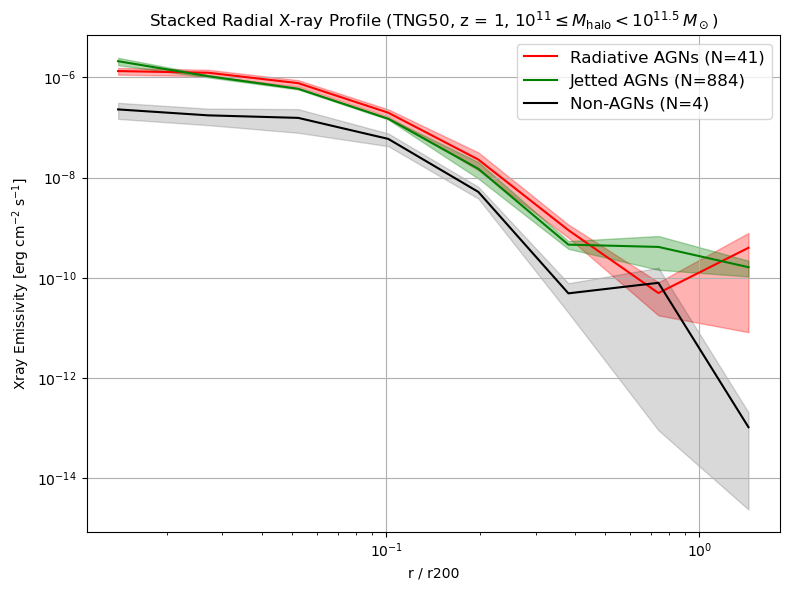

In [ ]:
bin_edges = np.logspace(np.log10(1e-2), np.log10(r_norm_max), nbins + 1)
bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])

hmn = r"$10^{11} \leq M_{\rm halo} < 10^{11.5} \, M_\odot$"
'''
hmv = ["1", "2", "3", "4"]

hmname = [
    r"$10^{11} \leq M_{\rm halo} < 10^{11.5} \, M_\odot$",
    r"$10^{11.5} \leq M_{\rm halo} < 10^{12} \, M_\odot$",
    r"$10^{12} \leq M_{\rm halo} < 10^{12.5} \, M_\odot$",
    r"$10^{12.5} \leq M_{\rm halo} < 10^{13} \, M_\odot$"
]
'''
#for hm, hmn in zip(hmv, hmname):
profiles_ha_agn = np.load(f"xray_profile2d4bins_{tag[0]}_{hm}.npz")
profiles_hn_agn = np.load(f"xray_profile2d4bins_{tag[2]}_{hm}.npz")
profiles_hn_non = np.load(f"xray_profile2d4bins_{tag[3]}_{hm}.npz")

data = np.load(f"accretor_agn50_hm{hm}.npz")          #ha_agn, ha_non, hn_agn, hn_non ids
ha_agn = data["ha_agn"]
hn_agn = data["hn_agn"]
hn_non = data["hn_non"]

avg_ha_agn = profiles_ha_agn["xray_mean"]
err_ha_agn = profiles_ha_agn["xray_sem"]

avg_hn_agn = profiles_hn_agn["xray_mean"]
err_hn_agn = profiles_hn_agn["xray_sem"]

avg_hn_non = profiles_hn_non["xray_mean"]
err_hn_non = profiles_hn_non["xray_sem"]

plt.figure(figsize=(8, 6))

# Efficient Accretors - AGN
plt.plot(bin_centers, avg_ha_agn, label=f"Radiative AGNs (N={len(ha_agn)})", color="red")
plt.fill_between(bin_centers, avg_ha_agn - err_ha_agn, avg_ha_agn + err_ha_agn,
                 color="red", alpha=0.3)

# Inefficient Accretors - AGN
plt.plot(bin_centers, avg_hn_agn, label=f"Jetted AGNs (N={len(hn_agn)})", color="green")
plt.fill_between(bin_centers, avg_hn_agn - err_hn_agn, avg_hn_agn + err_hn_agn,
                 color="green", alpha=0.3)

# Inefficient Accretors - Non-AGN
plt.plot(bin_centers, avg_hn_non, label=f"Non-AGNs (N={len(hn_non)})", color="black")
plt.fill_between(bin_centers, avg_hn_non - err_hn_non, avg_hn_non + err_hn_non,
                 color="black", alpha=0.15)

plt.xlabel("r / r200")
plt.ylabel("Xray Emissivity [erg cm$^{-2}$ s$^{-1}$]")
plt.title(f"Stacked Radial X-ray Profile (TNG50, z = 1, {hmn})")
plt.legend(fontsize=12)
plt.grid(True)
#plt.xlim(1e-2, 1.2)
#plt.ylim(1e-16, 1e-3)
plt.xscale("log")
plt.yscale("log")
plt.tight_layout()
plt.savefig(f"xray2d4bins_{hm}.png", dpi=900)
plt.show()

working


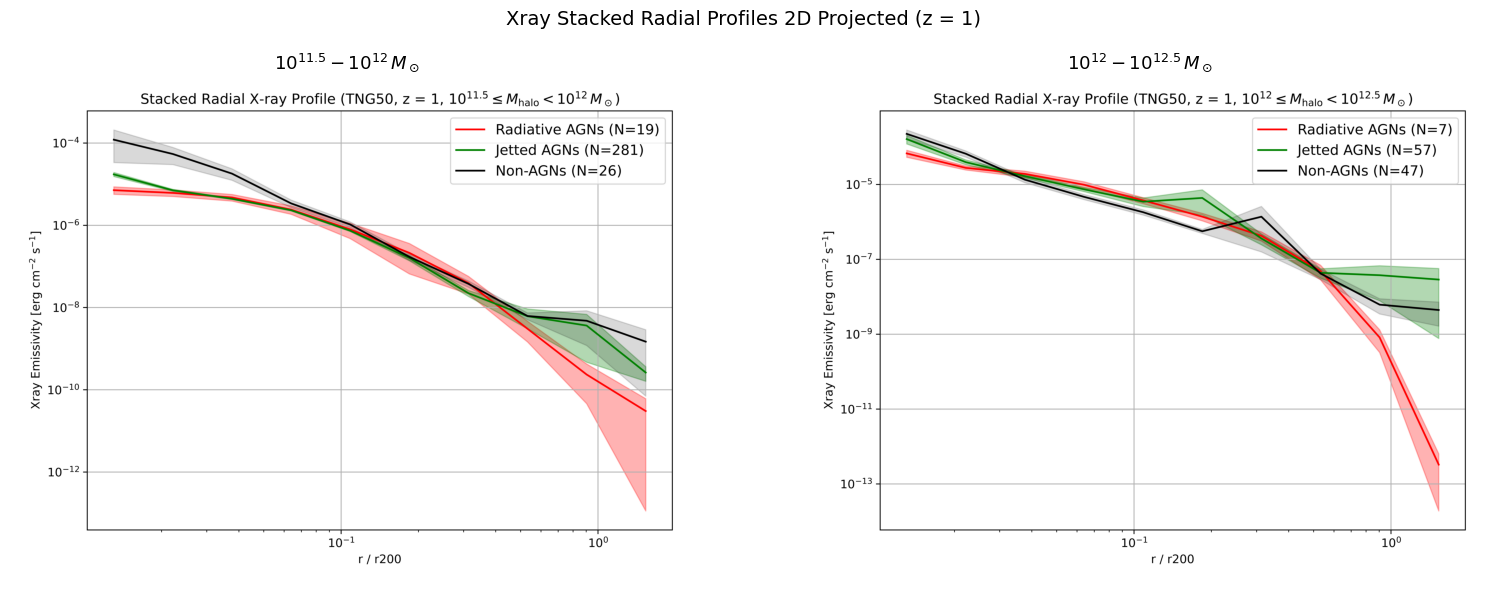

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

print("working")

quantities = ["xray2d4bins"]
hms = ["2", "3"]
hm_labels = [
    r"$10^{11.5} - 10^{12} \, M_\odot$",
    r"$10^{12} - 10^{12.5} \, M_\odot$"
]

fig, axes = plt.subplots(len(quantities), len(hms), figsize=(16, 6))

# Ensure axes is 2D
if len(quantities) == 1:
    axes = np.expand_dims(axes, axis=0)

for i, quantity in enumerate(quantities):
    for j, hm in enumerate(hms):
        filename = f"{quantity}_{hm}.png"
        try:
            img = Image.open(filename)
            ax = axes[i, j]
            ax.imshow(np.asarray(img))
            ax.axis('off')
            if i == 0:
                ax.set_title(hm_labels[j], fontsize=13)
            if j == 0:
                ax.set_ylabel(quantity.capitalize(), fontsize=10)
        except Exception as e:
            print(f"Could not load {filename}: {e}")
            axes[i, j].axis('off')

fig.suptitle("Xray Stacked Radial Profiles 2D Projected (z = 1)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
#plt.savefig("xray_2d4bins.pdf", dpi=1200)
plt.show()
